In [1]:
# Load packages
from datetime import datetime
import logging
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import scipy
import sys

In [2]:
# declare universal variables
CONDITION = 'severePE'
CONDITION_CLINICAL_DF = 'Severe PE'
SUFFIX = ' (protein)'

In [3]:
# Set up logger
os.remove('spearman.standardized.interomics.min.power.' + CONDITION + '.pairs.all.miniDP3.log')
logger = logging.getLogger('analytics')

# Set the logging level
logger.setLevel(logging.INFO)

# Define a log format
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# Create a console handler to output log messages to the console
console_handler = logging.StreamHandler()
console_handler.setFormatter(formatter)
logger.addHandler(console_handler)

# (Optional) Create a file handler to log messages to a file
file_handler = logging.FileHandler('spearman.standardized.interomics.min.power.' + CONDITION + '.pairs.all.miniDP3.log')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

In [4]:
dfpb = pd.read_table('../../data/proteins-final-adjusted.csv', sep=',', dtype={'Patient-ID':str})
dfmb = pd.read_table('../../data/metabolites-final-adjusted.csv', sep=',', dtype={'Patient-ID':str})
dfmirna = pd.read_table('../../data/mirna-final-adjusted.csv', sep=',', dtype={'Patient-ID':str})
dftb = pd.read_table('../../data/transcripts-final-adjusted.csv', sep=',', dtype={'Patient-ID':str})
dfph = pd.read_table('../../data/PlacentalHistopathologyReportsCleaned.csv', sep=',', dtype={'Patient-ID':str})
dfph2 = pd.read_table('../../data/PlacentalHistopathologySlideFeaturesCleaned.csv', sep=',', dtype={'Patient-ID':str})

dfp_analyte = pd.read_table('../../data/protein-meta-final.csv', sep=',')
dfm_analyte = pd.read_table('../../data/metabolites-meta-final.csv', sep=',')
dfmirna_analyte = pd.read_table('../../data/mirna-meta-final.csv', sep=',')
dft_analyte = pd.read_table('../../data/transcripts-meta-final.csv', sep=',')

df_clinical = pd.read_table('../../data/metadata-final.csv', sep=',', dtype={'Study_ID/ID':str})
df_clinical = df_clinical[df_clinical['Condition']==CONDITION_CLINICAL_DF]

In [5]:
dfpb.shape, dfmb.shape, dfmirna.shape, dftb.shape, dfph.shape, dfph2.shape, df_clinical.shape

((321, 352), (319, 866), (294, 450), (294, 9585), (275, 6), (348, 9), (75, 21))

# Set up annotations

In [6]:
metabolites = {}
for index, row in dfm_analyte.iterrows():
    metabolites[row['CHEMICAL_NAME']] = {'name': row['CHEMICAL_NAME'], 'sub_group': row['SUB_PATHWAY'], 'super_group': row['SUPER_PATHWAY']}
    
miRNAs = {}
for index, row in dfmirna_analyte.iterrows():
    miRNAs[row['Transcript']] = {'name': row['Transcript'], 'sub_group': None, 'super_group': None}
    
proteins = {}
for index, row in dfp_analyte.iterrows():
    proteins[row['Assay'] + SUFFIX] = {'name': row['Assay'], 'sub_group': None, 'super_group': row['Panel']}
    
transcripts = {}
for index, row in dft_analyte.iterrows():
    transcripts[row['Transcript']] = {'name': row['Transcript'], 'sub_group': None, 'super_group': None}
    
histopathology = {}
for item in dfph:
    if item != 'Patient-ID':
        histopathology[item] = {'name': item, 'sub_group': None, 'super_group': None}
for item in dfph2:
    if item != 'Patient-ID':
        histopathology[item] = {'name': item, 'sub_group': None, 'super_group': None}
        
# print the number of included analytes
print('Histopathology Features:', str(len(histopathology)))
print('Metabolites:', str(len(metabolites)))
print('miRNAs:', str(len(miRNAs)))
print('Proteins:', str(len(proteins)))
print('Transcripts:', str(len(transcripts)))
print('Total:', str(len(histopathology)+len(metabolites)+len(miRNAs)+len(proteins)+len(transcripts)))

Histopathology Features: 13
Metabolites: 1032
miRNAs: 2414
Proteins: 452
Transcripts: 51174
Total: 55085


# Merge against prot/met data

In [7]:
dfm_analyte = list(set(metabolites.keys()).intersection(dfmb.columns))
dfmirna_analyte = list(set(miRNAs.keys()).intersection(dfmirna.columns))
dfp_analyte = list(set(proteins.keys()).intersection(dfpb.columns))
dft_analyte = list(set(transcripts.keys()).intersection(dftb.columns))
dfph_measurement = ['MVM', 'FVM', 'AI', 'CI', 'Placental Abnormality']
dfph_measurement2 = ['DVH', 'AVM', 'Syncytial Knots', 'Segmental Avascular Villi', 'DVM', 'Villitis of Unknown Etiology', 'Diffuse Villous Edema', 'Chorangiosis']

# Get all analytes together
analytes = dfph_measurement + dfph_measurement2 + dfm_analyte + dfmirna_analyte + dfp_analyte + dft_analyte

# print the number of included analytes that pass missingness threshold
print('Histopathology Features:', str(len(dfph_measurement)+len(dfph_measurement2)))
print('Metabolites:', str(len(dfm_analyte)))
print('miRNAs:', str(len(dfmirna_analyte)))
print('Proteins:', str(len(dfp_analyte)))
print('Transcripts:', str(len(dft_analyte)))
print('Total:', str(len(analytes)))

Histopathology Features: 13
Metabolites: 865
miRNAs: 448
Proteins: 343
Transcripts: 9582
Total: 11251


In [8]:
df_clinical.head()

Patient-ID  Condition  LaborInitiation  MaternalAge  isWhite  isBlack   
2     KH-1132  Severe PE                0         31.0      0.0      0.0  \
3     KH-1149  Severe PE                0         29.0      0.0      0.0   
21    MJ-0128  Severe PE                0         19.0      0.0      1.0   
26    MJ-0296  Severe PE                0         36.0      1.0      0.0   
33    MJ-0363  Severe PE                0         19.0      0.0      1.0   

    isAsian  Ethnicity    WksGest  PregravidBMI  ...  Para  LaborOnset   
2       1.0        0.0  38.000000     26.297578  ...   0.0         0.0  \
3       0.0        0.0  33.857143     23.828125  ...   1.0         1.0   
21      0.0        0.0  36.000000     25.396825  ...   0.0         1.0   
26      0.0        0.0  34.000000     28.997474  ...   1.0         0.0   
33      0.0        0.0  38.857143     27.700831  ...   0.0         0.0   

    Smoker  IllicitDrugUser  DeliveryMethod  PregnancyRelatedHypertension   
2      0.0              0.0             0.0                             1  \
3      0.0              1.0             0.0                             1   
21     1.0              0.0             0.0                             1   
26     0.0              0.0             1.0                             1   
33     0.0              0.0             1.0                             1   

    FetalGrowthRestriction  Preeclampsia  InfSex  Birthweight  
2                        0             1     1.0       3490.0  
3                        0             1     0.0       1545.0  
21                       0             1     1.0       2635.0  
26                       0             1     0.0       1917.0  
33                       0             1     1.0       3130.0  

[5 rows x 21 columns]

In [9]:
df = df_clinical.merge(dfph[['Patient-ID'] + list(dfph_measurement)], on=['Patient-ID'], how='left')
print(df.shape)
df = df.merge(dfph2[['Patient-ID'] + list(dfph_measurement2)], on=['Patient-ID'], how='left')
print(df.shape)
df = df.merge(dfpb[['Patient-ID'] + list(dfp_analyte)], on=['Patient-ID'], how='inner')
print(df.shape)
df = df.merge(dfmb[['Patient-ID'] + list(dfm_analyte)], on=['Patient-ID'], how='left')
print(df.shape)
df = df.merge(dfmirna[['Patient-ID'] + list(dfmirna_analyte)], on=['Patient-ID'], how='left')
print(df.shape)
df = df.merge(dftb[['Patient-ID'] + list(dft_analyte)], on=['Patient-ID'], how='left')
print(df.shape)
df = df.fillna(-1)

(75, 26)
(75, 34)
(71, 377)
(71, 1242)
(71, 1690)
(71, 11272)


In [10]:
df.shape, dfpb.shape, dfmb.shape, dfmirna.shape, dftb.shape, dfph.shape, dfph2.shape, df_clinical.shape

((71, 11272),
 (321, 352),
 (319, 866),
 (294, 450),
 (294, 9585),
 (275, 6),
 (348, 9),
 (75, 21))

In [11]:
# Select a random subset of rows
np.random.seed(123)
num_rows_to_select = 30  # Set to smallest sample size
df = df.sample(n=num_rows_to_select)

In [12]:
df.shape

(30, 11272)

In [13]:
df['InfSex'].value_counts()

InfSex
0.0    15
1.0    15
Name: count, dtype: int64

In [14]:
df['isWhite'].value_counts()

isWhite
 1.0    19
 0.0    10
-1.0     1
Name: count, dtype: int64

In [15]:
df['isBlack'].value_counts()

isBlack
 0.0    21
 1.0     8
-1.0     1
Name: count, dtype: int64

In [16]:
df['isAsian'].value_counts()

isAsian
 0.0    28
-1.0     1
 1.0     1
Name: count, dtype: int64

In [17]:
df.head()

Patient-ID  Condition  LaborInitiation  MaternalAge  isWhite  isBlack   
8       MJ-0504  Severe PE                0         22.0     -1.0     -1.0  \
45  Mini-DP-137  Severe PE                0         30.0      1.0      0.0   
44  Mini-DP-136  Severe PE                0         21.0      1.0      0.0   
37  Mini-DP-128  Severe PE                0         39.0      1.0      0.0   
40  Mini-DP-131  Severe PE                0         37.0      1.0      0.0   

    isAsian  Ethnicity    WksGest  PregravidBMI  ...         JHY  CDC42BPB   
8      -1.0       -1.0  34.428571     30.385016  ...  202.397408    2660.0  \
45      0.0        0.0  37.428571     23.621620  ...  335.094003    4094.0   
44      0.0        0.0  36.285714     46.005149  ...  282.151976    3140.0   
37      0.0        0.0  40.285714     33.248158  ...  333.974946    3844.0   
40      0.0        0.0  34.142857     28.947223  ...   -1.000000      -1.0   

    ADSS2     GSN  FAM3A  MAP3K9  HERC2P9   H2AJ    CD81  C5orf22  
8   454.0  3366.0  618.0  1484.0    297.0  164.0   761.0    419.0  
45  558.0  3651.0  710.0  1473.0    417.0  273.0  1363.0    571.0  
44  477.0  3909.0  639.0  1449.0    280.0  263.0  1148.0    506.0  
37  545.0  3997.0  761.0  2002.0    359.0  279.0  1097.0    455.0  
40   -1.0    -1.0   -1.0    -1.0     -1.0   -1.0    -1.0     -1.0  

[5 rows x 11272 columns]

# Correlation network

In [18]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.sandbox.stats.multicomp
from statsmodels.genmod.families import family, links
import itertools

In [19]:
drop_cols = ['Patient-ID', 'Grav', 'DeliveryMethod', 
             'Para', 'PrePregWt_Kg', 'Ethnicity', 'isAsian', 
             'isBlack', 'WksGest', 'Condition', 'isWhite', 
             'Race', 'MaternalAge', 'Smoke', 'PregravidBMI',
             'HeightMeters']

# Pairwise GLM

In [20]:
def count_pairs(dat, analytes, proteins, metabolites, mirnas, transcripts, histopathology):

    # Create all possible pairs of inputs
    pairs = list(itertools.combinations(analytes, 2))
    logger.info('Created {} pairs'.format(len(pairs)))
         
    count = 0 
    done = 0
    skipped = 0
    completed = 0

    results = []
    columns = list(dat.columns)

    start_time = datetime.now()
    for (col1, col2) in pairs:

        if (col1 == col2):
            continue
                    
        if (col1 in histopathology.keys()) and (col2 in histopathology.keys()):
            continue
        
        if (col1 in metabolites.keys()) and (col2 in metabolites.keys()):
            continue
            
        if (col1 in mirnas.keys()) and (col2 in mirnas.keys()):
            continue

        if (col1 in proteins.keys()) and (col2 in proteins.keys()):
            continue
        
        if (col1 in transcripts.keys()) and (col2 in transcripts.keys()):
            continue
            
        if (col1 in proteins.keys()):
            name1 = proteins[col1]['name']
            subgroup1 = proteins[col1]['sub_group'] 
            supergroup1 = proteins[col1]['super_group']
            type1 = 'protein'
        elif (col1 in metabolites.keys()):
            name1 = metabolites[col1]['name']
            subgroup1 = metabolites[col1]['sub_group'] 
            supergroup1 = metabolites[col1]['super_group']
            type1 = 'metabolite'
        elif (col1 in mirnas.keys()):
            name1 = mirnas[col1]['name']
            subgroup1 = mirnas[col1]['sub_group'] 
            supergroup1 = mirnas[col1]['super_group']
            type1 = 'miRNA'
        elif (col1 in transcripts.keys()):
            name1 = transcripts[col1]['name']
            subgroup1 = transcripts[col1]['sub_group'] 
            supergroup1 = transcripts[col1]['super_group']
            type1 = 'transcript'
        elif (col1 in histopathology.keys()):
            name1 = histopathology[col1]['name']
            subgroup1 = histopathology[col1]['sub_group'] 
            supergroup1 = histopathology[col1]['super_group']
            type1 = 'histopathology'

        else:
            logger.warning('Col1 {} not found in any annotation'.format(col1))
            name1 = None
            subgroup1 = None
            supergroup1 = None
            type1 = None
            
        if (col2 in proteins.keys()):
            name2 = proteins[col2]['name']
            subgroup2 = proteins[col2]['sub_group'] 
            supergroup2 = proteins[col2]['super_group']
            type2 = 'protein'
        elif (col2 in metabolites.keys()):
            name2 = metabolites[col2]['name']
            subgroup2 = metabolites[col2]['sub_group'] 
            supergroup2 = metabolites[col2]['super_group']
            type2 = 'metabolite'
        elif (col2 in mirnas.keys()):
            name2 = mirnas[col2]['name']
            subgroup2 = mirnas[col2]['sub_group'] 
            supergroup2 = mirnas[col2]['super_group']
            type2 = 'miRNA'
        elif (col2 in transcripts.keys()):
            name2 = transcripts[col2]['name']
            subgroup2 = transcripts[col2]['sub_group'] 
            supergroup2 = transcripts[col2]['super_group']
            type2 = 'transcript'
        elif (col2 in histopathology.keys()):
            name2 = histopathology[col2]['name']
            subgroup2 = histopathology[col2]['sub_group'] 
            supergroup2 = histopathology[col2]['super_group']
            type2 = 'histopathology'
    
        else:
            logger.warning('Col2 {} not found in any annotation'.format(col2))
            name2 = None
            subgroup2 = None
            supergroup2 = None
            type2 = None
            
        count += 1
        
    print('Running {} pairs'.format(count))

count_pairs(df, analytes, proteins, metabolites, miRNAs, transcripts, histopathology)

2024-02-11 11:34:52,440 - analytics - INFO - Created 63286875 pairs


Running 16851765 pairs


In [21]:
def evaluate_effect_size(df, logger):
    # evaluate effect size - cohen's d
    df_no_effect = df[abs(df['coef'])<0.01]
    df_very_small = df[abs(df['coef'])>=0.01]
    df_very_small = df_very_small[abs(df_very_small['coef'])<0.1]
    df_small = df[abs(df['coef'])>=0.1]
    df_small = df_small[abs(df_small['coef'])<0.2]
    df_medium = df[abs(df['coef'])>=0.2]
    df_medium  = df_medium[abs(df_medium['coef'])<0.3]
    df_medium_large = df[abs(df['coef'])>=0.3]
    df_medium_large = df_medium_large[abs(df_medium_large['coef'])<0.5]
    df_large = df[abs(df['coef'])>=0.5]
    df_large = df_large[abs(df_large['coef'])<0.7]
    df_very_large = df[abs(df['coef'])>=0.7]
    df_very_large = df_very_large[abs(df_very_large['coef'])<0.9]
    df_huge = df[abs(df['coef'])>=0.9]
    
    # print info on effect sizes
    logger.info('Number of Analyte Pairs with No Monotonic Relationship: {}'.format(str(df_no_effect.shape[0])))
    logger.info('Number of Analyte Pairs with Very Weak Monotonic Relationship: {}'.format(str(df_very_small.shape[0])))
    logger.info('Number of Analyte Pairs with Weak Monotonic Relationship: {}'.format(str(df_small.shape[0])))
    logger.info('Number of Analyte Pairs with Moderate Monotonic Relationship: {}'.format(str(df_medium.shape[0])))
    logger.info('Number of Analyte Pairs with Moderate Strong Monotonic Relationship: {}'.format(str(df_medium_large.shape[0])))
    logger.info('Number of Analyte Pairs with Strong Monotonic Relationship: {}'.format(str(df_large.shape[0])))
    logger.info('Number of Analyte Pairs with Very Strong Monotonic Relationship: {}'.format(str(df_very_large.shape[0])))
    logger.info('Number of Analyte Pairs with Near Perfect Monotonic Relationship: {}'.format(str(df_huge.shape[0])))
    logger.info('\n')
    

def run_spearman_pairwise(dat, condition, analytes, proteins, metabolites, mirnas, transcripts, histopathology, max_run=None):

    # Create all possible pairs of inputs
    pairs = list(itertools.combinations(analytes, 2))
    logger.info('Created {} pairs'.format(len(pairs)))
    
    f_failed = open('failed.spearman.standardized.interomics.min.power.' + condition + '.pairs.all.miniDP3.txt', mode='w')
    f_output = 'spearman.standardized.interomics.min.power.' + condition + '.all.miniDP3.txt'
    f_output_sig = 'spearman.standardized.interomics.min.power.' + condition + '.sig.miniDP3.txt'
         
    count = 0 
    done = 0
    skipped = 0
    completed = 0

    results = []
    columns = list(dat.columns)

    start_time = datetime.now()
    for (col1, col2) in pairs:

        if (col1 == col2):
            continue
                           
        if (col1 in histopathology.keys()) and (col2 in histopathology.keys()):
            continue
        
        if (col1 in metabolites.keys()) and (col2 in metabolites.keys()):
            continue
            
        if (col1 in mirnas.keys()) and (col2 in mirnas.keys()):
            continue

        if (col1 in proteins.keys()) and (col2 in proteins.keys()):
            continue
        
        if (col1 in transcripts.keys()) and (col2 in transcripts.keys()):
            continue

        if (col1 in proteins.keys()):
            name1 = proteins[col1]['name']
            subgroup1 = proteins[col1]['sub_group'] 
            supergroup1 = proteins[col1]['super_group']
            type1 = 'protein'
        elif (col1 in metabolites.keys()):
            name1 = metabolites[col1]['name']
            subgroup1 = metabolites[col1]['sub_group'] 
            supergroup1 = metabolites[col1]['super_group']
            type1 = 'metabolite'
        elif (col1 in mirnas.keys()):
            name1 = mirnas[col1]['name']
            subgroup1 = mirnas[col1]['sub_group'] 
            supergroup1 = mirnas[col1]['super_group']
            type1 = 'miRNA'
        elif (col1 in transcripts.keys()):
            name1 = transcripts[col1]['name']
            subgroup1 = transcripts[col1]['sub_group'] 
            supergroup1 = transcripts[col1]['super_group']
            type1 = 'transcript'
        elif (col1 in histopathology.keys()):
            name1 = histopathology[col1]['name']
            subgroup1 = histopathology[col1]['sub_group'] 
            supergroup1 = histopathology[col1]['super_group']
            type1 = 'histopathology'
        else:
            logger.warning('Col1 {} not found in any annotation'.format(col1))
            name1 = None
            subgroup1 = None
            supergroup1 = None
            type1 = None
            
        if (col2 in proteins.keys()):
            name2 = proteins[col2]['name']
            subgroup2 = proteins[col2]['sub_group'] 
            supergroup2 = proteins[col2]['super_group']
            type2 = 'protein'
        elif (col2 in metabolites.keys()):
            name2 = metabolites[col2]['name']
            subgroup2 = metabolites[col2]['sub_group'] 
            supergroup2 = metabolites[col2]['super_group']
            type2 = 'metabolite'
        elif (col2 in mirnas.keys()):
            name2 = mirnas[col2]['name']
            subgroup2 = mirnas[col2]['sub_group'] 
            supergroup2 = mirnas[col2]['super_group']
            type2 = 'miRNA'
        elif (col2 in transcripts.keys()):
            name2 = transcripts[col2]['name']
            subgroup2 = transcripts[col2]['sub_group'] 
            supergroup2 = transcripts[col2]['super_group']
            type2 = 'transcript'
        elif (col2 in histopathology.keys()):
            name2 = histopathology[col2]['name']
            subgroup2 = histopathology[col2]['sub_group'] 
            supergroup2 = histopathology[col2]['super_group']
            type2 = 'histopathology'
        else:
            logger.warning('Col2 {} not found in any annotation'.format(col2))
            name2 = None
            subgroup2 = None
            supergroup2 = None
            type2 = None

        sub = dat[['Patient-ID', col1, col2]].copy()
        sub.rename(columns={col1:'analyte1'}, inplace=True)
        sub.rename(columns={col2:'analyte2'}, inplace=True)


        if (sub['analyte1'].skew() > 1.5) | (sub['analyte1'].skew() < -1.5):

            #logger.info('Setting gamma family for skewed analyte %s'%(col))

            # Set any zero values to 1/2 the smallest value
            sub.loc[sub['analyte1']==0, 'analyte1'] = (sub.loc[sub['analyte1']>0, 'analyte1'].min() / 2.0)
            

        # z-score transform dependent variable data
        if col2 not in histopathology.keys():
            sub['analyte2'] = sub['analyte2'].astype(np.float64)
            sub['analyte2'] = (sub['analyte2'] - sub['analyte2'].mean() ) / sub['analyte2'].std()

            
        try:
            coef, p = scipy.stats.spearmanr(sub['analyte1'], sub['analyte2'])
            results.append((col1, name1, type1, supergroup1, subgroup1, col2, name2, type2, supergroup2, subgroup2, coef, p))
            completed += 1

        except Exception as e:
            logger.info('Failed analytes {} {} with error {}'.format(col1, col2, str(e)))
            f_failed.write(col1 + '\t' + col2 + '\n')
            
            
        count += 1
        if (max_run is not None) and (count >= max_run):
            break
        
        if (count % 1000) == 0:
            elapsed_time = datetime.now() - start_time    
            logger.info('Finished {} in {:.3f} seconds (skipped {})'.format(count, elapsed_time.total_seconds(), skipped))
            
    df = pd.DataFrame(results, columns=['col1', 'name1', 'type1', 'supergroup1', 'subgroup1', 'col2', 'name2', 'type2', 'supergroup2', 'subgroup2', 'coef', 'p-value'])
    df.sort_values(['p-value'], ascending=True, inplace=True)
    f_failed.close()

    np.seterr(all='warn')
    logger.info('\nFinished analyzing all {} pairs!'.format(str(count)))
    logger.info('Number of analyte pairs with converged formula: {}'.format(str(df.shape[0])))
    (adj_pval_index, adj_pval, _, _) = statsmodels.sandbox.stats.multicomp.multipletests(df.loc[~df['p-value'].isnull(), 'p-value'], alpha=0.05, method='fdr_bh')
    df.loc[~df['p-value'].isnull(), 'pval_adj'] = adj_pval
    df.sort_values(['pval_adj'], ascending=True, inplace=True)
    df.to_csv(f_output, index=False, sep='\t')
    
    # filter for significance
    #df = df[df['pval_adj']<0.05]  #benjammini-hochman
    bonferroni_correction = 0.05/count
    df = df[df['p-value']<bonferroni_correction]  #bonferroni correction
    logger.info('\nBonferroni Correction: p<{}'.format(str(bonferroni_correction)))
    logger.info('Number of analyte pairs whose levels are significantly associated: {}'.format(str(df.shape[0])))
    df.to_csv(f_output_sig, index=False, sep='\t')
    
    # evaluate effect size - cohen's d
    logger.info('Effect Sizes (Cohen\'s D ) For Significant Correlations:')
    evaluate_effect_size(df, logger)
    logger.info('\nFinished all correlation analyses!')
    
    return df

In [22]:
os.remove('failed.spearman.standardized.interomics.min.power.' + CONDITION + '.pairs.all.miniDP3.txt')
os.remove('spearman.standardized.interomics.min.power.' + CONDITION + '.all.miniDP3.txt')
os.remove('spearman.standardized.interomics.min.power.' + CONDITION + '.sig.miniDP3.txt')

In [23]:
spearman_pairwise = run_spearman_pairwise(df, CONDITION, analytes, proteins, metabolites, miRNAs, transcripts, histopathology)

2024-02-11 11:35:55,590 - analytics - INFO - Created 63286875 pairs
2024-02-11 11:35:58,424 - analytics - INFO - Finished 1000 in 2.830 seconds (skipped 0)
2024-02-11 11:36:01,187 - analytics - INFO - Finished 2000 in 5.594 seconds (skipped 0)
2024-02-11 11:36:04,268 - analytics - INFO - Finished 3000 in 8.674 seconds (skipped 0)
2024-02-11 11:36:07,292 - analytics - INFO - Finished 4000 in 11.699 seconds (skipped 0)
2024-02-11 11:36:10,168 - analytics - INFO - Finished 5000 in 14.574 seconds (skipped 0)
2024-02-11 11:36:13,029 - analytics - INFO - Finished 6000 in 17.435 seconds (skipped 0)
2024-02-11 11:36:15,835 - analytics - INFO - Finished 7000 in 20.241 seconds (skipped 0)
2024-02-11 11:36:18,802 - analytics - INFO - Finished 8000 in 23.209 seconds (skipped 0)
2024-02-11 11:36:22,024 - analytics - INFO - Finished 9000 in 26.430 seconds (skipped 0)
2024-02-11 11:36:24,767 - analytics - INFO - Finished 10000 in 29.174 seconds (skipped 0)
2024-02-11 11:36:27,678 - analytics - INFO -

2024-02-11 11:39:43,996 - analytics - INFO - Finished 91000 in 228.403 seconds (skipped 0)
2024-02-11 11:39:46,654 - analytics - INFO - Finished 92000 in 231.060 seconds (skipped 0)
2024-02-11 11:39:49,429 - analytics - INFO - Finished 93000 in 233.836 seconds (skipped 0)
2024-02-11 11:39:52,182 - analytics - INFO - Finished 94000 in 236.588 seconds (skipped 0)
2024-02-11 11:39:54,893 - analytics - INFO - Finished 95000 in 239.299 seconds (skipped 0)
2024-02-11 11:39:57,608 - analytics - INFO - Finished 96000 in 242.014 seconds (skipped 0)
2024-02-11 11:40:00,208 - analytics - INFO - Finished 97000 in 244.615 seconds (skipped 0)
2024-02-11 11:40:02,803 - analytics - INFO - Finished 98000 in 247.210 seconds (skipped 0)
2024-02-11 11:40:05,542 - analytics - INFO - Finished 99000 in 249.948 seconds (skipped 0)
2024-02-11 11:40:08,281 - analytics - INFO - Finished 100000 in 252.687 seconds (skipped 0)
2024-02-11 11:40:10,988 - analytics - INFO - Finished 101000 in 255.395 seconds (skipped 

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
2024-02-11 11:41:12,383 - analytics - INFO - Finished 124000 in 316.789 seconds (skipped 0)
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-p

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
2024-02-11 11:41:27,527 - analytics - INFO - Finished 132000 in 331.933 seconds (skipped 0)
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-p

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

2024-02-11 11:41:57,158 - analytics - INFO - Finished 147000 in 361.565 seconds (skipped 0)
2024-02-11 11:41:59,439 - analytics - INFO - Finished 148000 in 363.845 seconds (skipped 0)
2024-02-11 11:42:01,791 - analytics - INFO - Finished 149000 in 366.197 seconds (skipped 0)
2024-02-11 11:42:04,028 - analytics - INFO - Finished 150000 in 368.434 seconds (skipped 0)
2024-02-11 11:42:06,164 - analytics - INFO - Finished 151000 in 370.570 seconds (skipped 0)
2024-02-11 11:42:08,445 - analytics - INFO - Finished 152000 in 372.851 seconds (skipped 0)
2024-02-11 11:42:10,774 - analytics - INFO - Finished 153000 in 375.180 seconds (skipped 0)
2024-02-11 11:42:13,137 - analytics - INFO - Finished 154000 in 377.543 seconds (skipped 0)
2024-02-11 11:42:15,447 - analytics - INFO - Finished 155000 in 379.854 seconds (skipped 0)
2024-02-11 11:42:17,782 - analytics - INFO - Finished 156000 in 382.189 seconds (skipped 0)
2024-02-11 11:42:20,003 - analytics - INFO - Finished 157000 in 384.410 seconds 

2024-02-11 11:45:45,274 - analytics - INFO - Finished 237000 in 589.680 seconds (skipped 0)
2024-02-11 11:45:48,014 - analytics - INFO - Finished 238000 in 592.420 seconds (skipped 0)
2024-02-11 11:45:50,719 - analytics - INFO - Finished 239000 in 595.125 seconds (skipped 0)
2024-02-11 11:45:53,349 - analytics - INFO - Finished 240000 in 597.755 seconds (skipped 0)
2024-02-11 11:45:55,645 - analytics - INFO - Finished 241000 in 600.052 seconds (skipped 0)
2024-02-11 11:45:57,959 - analytics - INFO - Finished 242000 in 602.365 seconds (skipped 0)
2024-02-11 11:46:00,043 - analytics - INFO - Finished 243000 in 604.449 seconds (skipped 0)
2024-02-11 11:46:02,246 - analytics - INFO - Finished 244000 in 606.653 seconds (skipped 0)
2024-02-11 11:46:04,487 - analytics - INFO - Finished 245000 in 608.893 seconds (skipped 0)
2024-02-11 11:46:06,795 - analytics - INFO - Finished 246000 in 611.201 seconds (skipped 0)
2024-02-11 11:46:09,069 - analytics - INFO - Finished 247000 in 613.476 seconds 

2024-02-11 11:49:26,396 - analytics - INFO - Finished 327000 in 810.803 seconds (skipped 0)
2024-02-11 11:49:29,202 - analytics - INFO - Finished 328000 in 813.608 seconds (skipped 0)
2024-02-11 11:49:31,895 - analytics - INFO - Finished 329000 in 816.301 seconds (skipped 0)
2024-02-11 11:49:34,739 - analytics - INFO - Finished 330000 in 819.145 seconds (skipped 0)
2024-02-11 11:49:37,517 - analytics - INFO - Finished 331000 in 821.923 seconds (skipped 0)
2024-02-11 11:49:40,339 - analytics - INFO - Finished 332000 in 824.745 seconds (skipped 0)
2024-02-11 11:49:43,052 - analytics - INFO - Finished 333000 in 827.459 seconds (skipped 0)
2024-02-11 11:49:45,203 - analytics - INFO - Finished 334000 in 829.609 seconds (skipped 0)
2024-02-11 11:49:47,506 - analytics - INFO - Finished 335000 in 831.912 seconds (skipped 0)
2024-02-11 11:49:49,820 - analytics - INFO - Finished 336000 in 834.227 seconds (skipped 0)
2024-02-11 11:49:52,873 - analytics - INFO - Finished 337000 in 837.279 seconds 

2024-02-11 11:53:07,710 - analytics - INFO - Finished 416000 in 1032.117 seconds (skipped 0)
2024-02-11 11:53:10,180 - analytics - INFO - Finished 417000 in 1034.586 seconds (skipped 0)
2024-02-11 11:53:12,450 - analytics - INFO - Finished 418000 in 1036.856 seconds (skipped 0)
2024-02-11 11:53:14,681 - analytics - INFO - Finished 419000 in 1039.088 seconds (skipped 0)
2024-02-11 11:53:16,982 - analytics - INFO - Finished 420000 in 1041.388 seconds (skipped 0)
2024-02-11 11:53:19,226 - analytics - INFO - Finished 421000 in 1043.633 seconds (skipped 0)
2024-02-11 11:53:21,795 - analytics - INFO - Finished 422000 in 1046.201 seconds (skipped 0)
2024-02-11 11:53:24,215 - analytics - INFO - Finished 423000 in 1048.622 seconds (skipped 0)
2024-02-11 11:53:26,670 - analytics - INFO - Finished 424000 in 1051.076 seconds (skipped 0)
2024-02-11 11:53:28,970 - analytics - INFO - Finished 425000 in 1053.377 seconds (skipped 0)
2024-02-11 11:53:31,249 - analytics - INFO - Finished 426000 in 1055.6

2024-02-11 11:56:53,670 - analytics - INFO - Finished 505000 in 1258.076 seconds (skipped 0)
2024-02-11 11:56:56,029 - analytics - INFO - Finished 506000 in 1260.436 seconds (skipped 0)
2024-02-11 11:56:58,312 - analytics - INFO - Finished 507000 in 1262.719 seconds (skipped 0)
2024-02-11 11:57:00,494 - analytics - INFO - Finished 508000 in 1264.901 seconds (skipped 0)
2024-02-11 11:57:02,738 - analytics - INFO - Finished 509000 in 1267.144 seconds (skipped 0)
2024-02-11 11:57:05,058 - analytics - INFO - Finished 510000 in 1269.464 seconds (skipped 0)
2024-02-11 11:57:07,244 - analytics - INFO - Finished 511000 in 1271.651 seconds (skipped 0)
2024-02-11 11:57:09,556 - analytics - INFO - Finished 512000 in 1273.962 seconds (skipped 0)
2024-02-11 11:57:11,890 - analytics - INFO - Finished 513000 in 1276.296 seconds (skipped 0)
2024-02-11 11:57:14,097 - analytics - INFO - Finished 514000 in 1278.504 seconds (skipped 0)
2024-02-11 11:57:16,326 - analytics - INFO - Finished 515000 in 1280.7

2024-02-11 12:00:26,285 - analytics - INFO - Finished 594000 in 1470.692 seconds (skipped 0)
2024-02-11 12:00:28,525 - analytics - INFO - Finished 595000 in 1472.932 seconds (skipped 0)
2024-02-11 12:00:30,585 - analytics - INFO - Finished 596000 in 1474.991 seconds (skipped 0)
2024-02-11 12:00:32,587 - analytics - INFO - Finished 597000 in 1476.993 seconds (skipped 0)
2024-02-11 12:00:34,624 - analytics - INFO - Finished 598000 in 1479.030 seconds (skipped 0)
2024-02-11 12:00:36,782 - analytics - INFO - Finished 599000 in 1481.188 seconds (skipped 0)
2024-02-11 12:00:38,970 - analytics - INFO - Finished 600000 in 1483.376 seconds (skipped 0)
2024-02-11 12:00:41,249 - analytics - INFO - Finished 601000 in 1485.655 seconds (skipped 0)
2024-02-11 12:00:43,551 - analytics - INFO - Finished 602000 in 1487.958 seconds (skipped 0)
2024-02-11 12:00:45,759 - analytics - INFO - Finished 603000 in 1490.166 seconds (skipped 0)
2024-02-11 12:00:47,998 - analytics - INFO - Finished 604000 in 1492.4

2024-02-11 12:04:09,800 - analytics - INFO - Finished 683000 in 1694.207 seconds (skipped 0)
2024-02-11 12:04:12,011 - analytics - INFO - Finished 684000 in 1696.417 seconds (skipped 0)
2024-02-11 12:04:14,322 - analytics - INFO - Finished 685000 in 1698.728 seconds (skipped 0)
2024-02-11 12:04:16,501 - analytics - INFO - Finished 686000 in 1700.907 seconds (skipped 0)
2024-02-11 12:04:18,664 - analytics - INFO - Finished 687000 in 1703.070 seconds (skipped 0)
2024-02-11 12:04:21,047 - analytics - INFO - Finished 688000 in 1705.453 seconds (skipped 0)
2024-02-11 12:04:23,322 - analytics - INFO - Finished 689000 in 1707.728 seconds (skipped 0)
2024-02-11 12:04:25,625 - analytics - INFO - Finished 690000 in 1710.032 seconds (skipped 0)
2024-02-11 12:04:27,985 - analytics - INFO - Finished 691000 in 1712.391 seconds (skipped 0)
2024-02-11 12:04:30,279 - analytics - INFO - Finished 692000 in 1714.685 seconds (skipped 0)
2024-02-11 12:04:32,665 - analytics - INFO - Finished 693000 in 1717.0

2024-02-11 12:07:49,304 - analytics - INFO - Finished 772000 in 1913.711 seconds (skipped 0)
2024-02-11 12:07:51,490 - analytics - INFO - Finished 773000 in 1915.896 seconds (skipped 0)
2024-02-11 12:07:53,814 - analytics - INFO - Finished 774000 in 1918.221 seconds (skipped 0)
2024-02-11 12:07:56,041 - analytics - INFO - Finished 775000 in 1920.447 seconds (skipped 0)
2024-02-11 12:07:58,293 - analytics - INFO - Finished 776000 in 1922.699 seconds (skipped 0)
2024-02-11 12:08:00,509 - analytics - INFO - Finished 777000 in 1924.915 seconds (skipped 0)
2024-02-11 12:08:02,852 - analytics - INFO - Finished 778000 in 1927.258 seconds (skipped 0)
2024-02-11 12:08:05,074 - analytics - INFO - Finished 779000 in 1929.481 seconds (skipped 0)
2024-02-11 12:08:07,333 - analytics - INFO - Finished 780000 in 1931.739 seconds (skipped 0)
2024-02-11 12:08:09,590 - analytics - INFO - Finished 781000 in 1933.997 seconds (skipped 0)
2024-02-11 12:08:11,988 - analytics - INFO - Finished 782000 in 1936.3

2024-02-11 12:11:16,208 - analytics - INFO - Finished 861000 in 2120.614 seconds (skipped 0)
2024-02-11 12:11:18,523 - analytics - INFO - Finished 862000 in 2122.929 seconds (skipped 0)
2024-02-11 12:11:21,652 - analytics - INFO - Finished 863000 in 2126.058 seconds (skipped 0)
2024-02-11 12:11:24,468 - analytics - INFO - Finished 864000 in 2128.874 seconds (skipped 0)
2024-02-11 12:11:27,209 - analytics - INFO - Finished 865000 in 2131.615 seconds (skipped 0)
2024-02-11 12:11:30,388 - analytics - INFO - Finished 866000 in 2134.794 seconds (skipped 0)
2024-02-11 12:11:33,186 - analytics - INFO - Finished 867000 in 2137.592 seconds (skipped 0)
2024-02-11 12:11:35,974 - analytics - INFO - Finished 868000 in 2140.380 seconds (skipped 0)
2024-02-11 12:11:38,744 - analytics - INFO - Finished 869000 in 2143.150 seconds (skipped 0)
2024-02-11 12:11:41,569 - analytics - INFO - Finished 870000 in 2145.975 seconds (skipped 0)
2024-02-11 12:11:44,354 - analytics - INFO - Finished 871000 in 2148.7

2024-02-11 12:15:03,303 - analytics - INFO - Finished 950000 in 2347.710 seconds (skipped 0)
2024-02-11 12:15:05,896 - analytics - INFO - Finished 951000 in 2350.302 seconds (skipped 0)
2024-02-11 12:15:08,231 - analytics - INFO - Finished 952000 in 2352.638 seconds (skipped 0)
2024-02-11 12:15:10,460 - analytics - INFO - Finished 953000 in 2354.866 seconds (skipped 0)
2024-02-11 12:15:12,735 - analytics - INFO - Finished 954000 in 2357.141 seconds (skipped 0)
2024-02-11 12:15:14,879 - analytics - INFO - Finished 955000 in 2359.285 seconds (skipped 0)
2024-02-11 12:15:16,945 - analytics - INFO - Finished 956000 in 2361.351 seconds (skipped 0)
2024-02-11 12:15:19,205 - analytics - INFO - Finished 957000 in 2363.612 seconds (skipped 0)
2024-02-11 12:15:21,921 - analytics - INFO - Finished 958000 in 2366.327 seconds (skipped 0)
2024-02-11 12:15:24,290 - analytics - INFO - Finished 959000 in 2368.696 seconds (skipped 0)
2024-02-11 12:15:26,613 - analytics - INFO - Finished 960000 in 2371.0

2024-02-11 12:18:36,078 - analytics - INFO - Finished 1038000 in 2560.484 seconds (skipped 0)
2024-02-11 12:18:38,358 - analytics - INFO - Finished 1039000 in 2562.765 seconds (skipped 0)
2024-02-11 12:18:40,591 - analytics - INFO - Finished 1040000 in 2564.997 seconds (skipped 0)
2024-02-11 12:18:42,848 - analytics - INFO - Finished 1041000 in 2567.255 seconds (skipped 0)
2024-02-11 12:18:45,190 - analytics - INFO - Finished 1042000 in 2569.596 seconds (skipped 0)
2024-02-11 12:18:47,403 - analytics - INFO - Finished 1043000 in 2571.809 seconds (skipped 0)
2024-02-11 12:18:49,634 - analytics - INFO - Finished 1044000 in 2574.040 seconds (skipped 0)
2024-02-11 12:18:51,870 - analytics - INFO - Finished 1045000 in 2576.276 seconds (skipped 0)
2024-02-11 12:18:54,128 - analytics - INFO - Finished 1046000 in 2578.534 seconds (skipped 0)
2024-02-11 12:18:56,430 - analytics - INFO - Finished 1047000 in 2580.836 seconds (skipped 0)
2024-02-11 12:18:58,719 - analytics - INFO - Finished 104800

2024-02-11 12:22:12,465 - analytics - INFO - Finished 1126000 in 2776.871 seconds (skipped 0)
2024-02-11 12:22:15,236 - analytics - INFO - Finished 1127000 in 2779.642 seconds (skipped 0)
2024-02-11 12:22:18,003 - analytics - INFO - Finished 1128000 in 2782.409 seconds (skipped 0)
2024-02-11 12:22:21,116 - analytics - INFO - Finished 1129000 in 2785.523 seconds (skipped 0)
2024-02-11 12:22:23,849 - analytics - INFO - Finished 1130000 in 2788.255 seconds (skipped 0)
2024-02-11 12:22:26,735 - analytics - INFO - Finished 1131000 in 2791.141 seconds (skipped 0)
2024-02-11 12:22:29,198 - analytics - INFO - Finished 1132000 in 2793.604 seconds (skipped 0)
2024-02-11 12:22:31,526 - analytics - INFO - Finished 1133000 in 2795.933 seconds (skipped 0)
2024-02-11 12:22:33,805 - analytics - INFO - Finished 1134000 in 2798.212 seconds (skipped 0)
2024-02-11 12:22:36,011 - analytics - INFO - Finished 1135000 in 2800.417 seconds (skipped 0)
2024-02-11 12:22:38,083 - analytics - INFO - Finished 113600

2024-02-11 12:25:49,726 - analytics - INFO - Finished 1214000 in 2994.132 seconds (skipped 0)
2024-02-11 12:25:51,943 - analytics - INFO - Finished 1215000 in 2996.349 seconds (skipped 0)
2024-02-11 12:25:54,229 - analytics - INFO - Finished 1216000 in 2998.636 seconds (skipped 0)
2024-02-11 12:25:56,444 - analytics - INFO - Finished 1217000 in 3000.850 seconds (skipped 0)
2024-02-11 12:25:58,481 - analytics - INFO - Finished 1218000 in 3002.888 seconds (skipped 0)
2024-02-11 12:26:00,655 - analytics - INFO - Finished 1219000 in 3005.061 seconds (skipped 0)
2024-02-11 12:26:02,969 - analytics - INFO - Finished 1220000 in 3007.375 seconds (skipped 0)
2024-02-11 12:26:05,285 - analytics - INFO - Finished 1221000 in 3009.691 seconds (skipped 0)
2024-02-11 12:26:07,605 - analytics - INFO - Finished 1222000 in 3012.012 seconds (skipped 0)
2024-02-11 12:26:09,760 - analytics - INFO - Finished 1223000 in 3014.167 seconds (skipped 0)
2024-02-11 12:26:12,073 - analytics - INFO - Finished 122400

2024-02-11 12:29:18,407 - analytics - INFO - Finished 1302000 in 3202.813 seconds (skipped 0)
2024-02-11 12:29:20,938 - analytics - INFO - Finished 1303000 in 3205.344 seconds (skipped 0)
2024-02-11 12:29:23,406 - analytics - INFO - Finished 1304000 in 3207.812 seconds (skipped 0)
2024-02-11 12:29:25,727 - analytics - INFO - Finished 1305000 in 3210.134 seconds (skipped 0)
2024-02-11 12:29:28,088 - analytics - INFO - Finished 1306000 in 3212.494 seconds (skipped 0)
2024-02-11 12:29:30,324 - analytics - INFO - Finished 1307000 in 3214.730 seconds (skipped 0)
2024-02-11 12:29:32,869 - analytics - INFO - Finished 1308000 in 3217.275 seconds (skipped 0)
2024-02-11 12:29:35,552 - analytics - INFO - Finished 1309000 in 3219.959 seconds (skipped 0)
2024-02-11 12:29:37,949 - analytics - INFO - Finished 1310000 in 3222.356 seconds (skipped 0)
2024-02-11 12:29:40,223 - analytics - INFO - Finished 1311000 in 3224.629 seconds (skipped 0)
2024-02-11 12:29:42,536 - analytics - INFO - Finished 131200

2024-02-11 12:32:53,537 - analytics - INFO - Finished 1390000 in 3417.944 seconds (skipped 0)
2024-02-11 12:32:55,869 - analytics - INFO - Finished 1391000 in 3420.275 seconds (skipped 0)
2024-02-11 12:32:58,612 - analytics - INFO - Finished 1392000 in 3423.018 seconds (skipped 0)
2024-02-11 12:33:01,358 - analytics - INFO - Finished 1393000 in 3425.764 seconds (skipped 0)
2024-02-11 12:33:04,125 - analytics - INFO - Finished 1394000 in 3428.531 seconds (skipped 0)
2024-02-11 12:33:06,720 - analytics - INFO - Finished 1395000 in 3431.126 seconds (skipped 0)
2024-02-11 12:33:09,192 - analytics - INFO - Finished 1396000 in 3433.598 seconds (skipped 0)
2024-02-11 12:33:11,920 - analytics - INFO - Finished 1397000 in 3436.326 seconds (skipped 0)
2024-02-11 12:33:14,770 - analytics - INFO - Finished 1398000 in 3439.177 seconds (skipped 0)
2024-02-11 12:33:17,505 - analytics - INFO - Finished 1399000 in 3441.911 seconds (skipped 0)
2024-02-11 12:33:20,305 - analytics - INFO - Finished 140000

2024-02-11 12:36:27,465 - analytics - INFO - Finished 1478000 in 3631.871 seconds (skipped 0)
2024-02-11 12:36:29,763 - analytics - INFO - Finished 1479000 in 3634.169 seconds (skipped 0)
2024-02-11 12:36:31,988 - analytics - INFO - Finished 1480000 in 3636.395 seconds (skipped 0)
2024-02-11 12:36:34,188 - analytics - INFO - Finished 1481000 in 3638.594 seconds (skipped 0)
2024-02-11 12:36:36,323 - analytics - INFO - Finished 1482000 in 3640.729 seconds (skipped 0)
2024-02-11 12:36:38,381 - analytics - INFO - Finished 1483000 in 3642.788 seconds (skipped 0)
2024-02-11 12:36:40,593 - analytics - INFO - Finished 1484000 in 3645.000 seconds (skipped 0)
2024-02-11 12:36:43,267 - analytics - INFO - Finished 1485000 in 3647.673 seconds (skipped 0)
2024-02-11 12:36:46,031 - analytics - INFO - Finished 1486000 in 3650.437 seconds (skipped 0)
2024-02-11 12:36:48,745 - analytics - INFO - Finished 1487000 in 3653.151 seconds (skipped 0)
2024-02-11 12:36:51,444 - analytics - INFO - Finished 148800

2024-02-11 12:40:14,771 - analytics - INFO - Finished 1566000 in 3859.178 seconds (skipped 0)
2024-02-11 12:40:17,398 - analytics - INFO - Finished 1567000 in 3861.805 seconds (skipped 0)
2024-02-11 12:40:19,694 - analytics - INFO - Finished 1568000 in 3864.100 seconds (skipped 0)
2024-02-11 12:40:22,260 - analytics - INFO - Finished 1569000 in 3866.666 seconds (skipped 0)
2024-02-11 12:40:24,625 - analytics - INFO - Finished 1570000 in 3869.032 seconds (skipped 0)
2024-02-11 12:40:26,984 - analytics - INFO - Finished 1571000 in 3871.391 seconds (skipped 0)
2024-02-11 12:40:29,241 - analytics - INFO - Finished 1572000 in 3873.647 seconds (skipped 0)
2024-02-11 12:40:31,463 - analytics - INFO - Finished 1573000 in 3875.869 seconds (skipped 0)
2024-02-11 12:40:33,710 - analytics - INFO - Finished 1574000 in 3878.116 seconds (skipped 0)
2024-02-11 12:40:35,932 - analytics - INFO - Finished 1575000 in 3880.339 seconds (skipped 0)
2024-02-11 12:40:38,230 - analytics - INFO - Finished 157600

2024-02-11 12:43:52,772 - analytics - INFO - Finished 1654000 in 4077.178 seconds (skipped 0)
2024-02-11 12:43:55,054 - analytics - INFO - Finished 1655000 in 4079.460 seconds (skipped 0)
2024-02-11 12:43:57,249 - analytics - INFO - Finished 1656000 in 4081.656 seconds (skipped 0)
2024-02-11 12:43:59,502 - analytics - INFO - Finished 1657000 in 4083.908 seconds (skipped 0)
2024-02-11 12:44:01,807 - analytics - INFO - Finished 1658000 in 4086.214 seconds (skipped 0)
2024-02-11 12:44:04,060 - analytics - INFO - Finished 1659000 in 4088.466 seconds (skipped 0)
2024-02-11 12:44:06,252 - analytics - INFO - Finished 1660000 in 4090.658 seconds (skipped 0)
2024-02-11 12:44:08,272 - analytics - INFO - Finished 1661000 in 4092.679 seconds (skipped 0)
2024-02-11 12:44:10,361 - analytics - INFO - Finished 1662000 in 4094.767 seconds (skipped 0)
2024-02-11 12:44:12,602 - analytics - INFO - Finished 1663000 in 4097.008 seconds (skipped 0)
2024-02-11 12:44:14,753 - analytics - INFO - Finished 166400

2024-02-11 12:47:25,602 - analytics - INFO - Finished 1742000 in 4290.008 seconds (skipped 0)
2024-02-11 12:47:27,857 - analytics - INFO - Finished 1743000 in 4292.263 seconds (skipped 0)
2024-02-11 12:47:30,116 - analytics - INFO - Finished 1744000 in 4294.522 seconds (skipped 0)
2024-02-11 12:47:32,410 - analytics - INFO - Finished 1745000 in 4296.817 seconds (skipped 0)
2024-02-11 12:47:34,674 - analytics - INFO - Finished 1746000 in 4299.080 seconds (skipped 0)
2024-02-11 12:47:36,774 - analytics - INFO - Finished 1747000 in 4301.180 seconds (skipped 0)
2024-02-11 12:47:38,894 - analytics - INFO - Finished 1748000 in 4303.300 seconds (skipped 0)
2024-02-11 12:47:41,160 - analytics - INFO - Finished 1749000 in 4305.566 seconds (skipped 0)
2024-02-11 12:47:43,408 - analytics - INFO - Finished 1750000 in 4307.814 seconds (skipped 0)
2024-02-11 12:47:45,651 - analytics - INFO - Finished 1751000 in 4310.058 seconds (skipped 0)
2024-02-11 12:47:47,979 - analytics - INFO - Finished 175200

2024-02-11 12:51:02,499 - analytics - INFO - Finished 1830000 in 4506.905 seconds (skipped 0)
2024-02-11 12:51:05,269 - analytics - INFO - Finished 1831000 in 4509.675 seconds (skipped 0)
2024-02-11 12:51:08,026 - analytics - INFO - Finished 1832000 in 4512.432 seconds (skipped 0)
2024-02-11 12:51:10,747 - analytics - INFO - Finished 1833000 in 4515.153 seconds (skipped 0)
2024-02-11 12:51:13,270 - analytics - INFO - Finished 1834000 in 4517.676 seconds (skipped 0)
2024-02-11 12:51:15,916 - analytics - INFO - Finished 1835000 in 4520.322 seconds (skipped 0)
2024-02-11 12:51:18,577 - analytics - INFO - Finished 1836000 in 4522.983 seconds (skipped 0)
2024-02-11 12:51:21,507 - analytics - INFO - Finished 1837000 in 4525.913 seconds (skipped 0)
2024-02-11 12:51:23,799 - analytics - INFO - Finished 1838000 in 4528.206 seconds (skipped 0)
2024-02-11 12:51:26,142 - analytics - INFO - Finished 1839000 in 4530.548 seconds (skipped 0)
2024-02-11 12:51:28,255 - analytics - INFO - Finished 184000

2024-02-11 12:54:28,745 - analytics - INFO - Finished 1918000 in 4713.151 seconds (skipped 0)
2024-02-11 12:54:30,931 - analytics - INFO - Finished 1919000 in 4715.338 seconds (skipped 0)
2024-02-11 12:54:33,309 - analytics - INFO - Finished 1920000 in 4717.715 seconds (skipped 0)
2024-02-11 12:54:35,475 - analytics - INFO - Finished 1921000 in 4719.881 seconds (skipped 0)
2024-02-11 12:54:37,777 - analytics - INFO - Finished 1922000 in 4722.184 seconds (skipped 0)
2024-02-11 12:54:40,024 - analytics - INFO - Finished 1923000 in 4724.431 seconds (skipped 0)
2024-02-11 12:54:42,360 - analytics - INFO - Finished 1924000 in 4726.766 seconds (skipped 0)
2024-02-11 12:54:44,635 - analytics - INFO - Finished 1925000 in 4729.041 seconds (skipped 0)
2024-02-11 12:54:46,875 - analytics - INFO - Finished 1926000 in 4731.281 seconds (skipped 0)
2024-02-11 12:54:49,004 - analytics - INFO - Finished 1927000 in 4733.410 seconds (skipped 0)
2024-02-11 12:54:51,244 - analytics - INFO - Finished 192800

2024-02-11 12:57:48,614 - analytics - INFO - Finished 2006000 in 4913.020 seconds (skipped 0)
2024-02-11 12:57:51,346 - analytics - INFO - Finished 2007000 in 4915.752 seconds (skipped 0)
2024-02-11 12:57:54,151 - analytics - INFO - Finished 2008000 in 4918.558 seconds (skipped 0)
2024-02-11 12:57:56,946 - analytics - INFO - Finished 2009000 in 4921.352 seconds (skipped 0)
2024-02-11 12:57:59,701 - analytics - INFO - Finished 2010000 in 4924.107 seconds (skipped 0)
2024-02-11 12:58:02,450 - analytics - INFO - Finished 2011000 in 4926.856 seconds (skipped 0)
2024-02-11 12:58:05,269 - analytics - INFO - Finished 2012000 in 4929.675 seconds (skipped 0)
2024-02-11 12:58:07,870 - analytics - INFO - Finished 2013000 in 4932.276 seconds (skipped 0)
2024-02-11 12:58:10,302 - analytics - INFO - Finished 2014000 in 4934.709 seconds (skipped 0)
2024-02-11 12:58:13,072 - analytics - INFO - Finished 2015000 in 4937.478 seconds (skipped 0)
2024-02-11 12:58:15,767 - analytics - INFO - Finished 201600

2024-02-11 13:01:39,100 - analytics - INFO - Finished 2094000 in 5143.506 seconds (skipped 0)
2024-02-11 13:01:41,706 - analytics - INFO - Finished 2095000 in 5146.113 seconds (skipped 0)
2024-02-11 13:01:44,442 - analytics - INFO - Finished 2096000 in 5148.848 seconds (skipped 0)
2024-02-11 13:01:47,168 - analytics - INFO - Finished 2097000 in 5151.574 seconds (skipped 0)
2024-02-11 13:01:49,898 - analytics - INFO - Finished 2098000 in 5154.304 seconds (skipped 0)
2024-02-11 13:01:52,643 - analytics - INFO - Finished 2099000 in 5157.049 seconds (skipped 0)
2024-02-11 13:01:55,138 - analytics - INFO - Finished 2100000 in 5159.544 seconds (skipped 0)
2024-02-11 13:01:57,833 - analytics - INFO - Finished 2101000 in 5162.239 seconds (skipped 0)
2024-02-11 13:02:00,638 - analytics - INFO - Finished 2102000 in 5165.044 seconds (skipped 0)
2024-02-11 13:02:03,382 - analytics - INFO - Finished 2103000 in 5167.789 seconds (skipped 0)
2024-02-11 13:02:06,140 - analytics - INFO - Finished 210400

2024-02-11 13:05:28,646 - analytics - INFO - Finished 2182000 in 5373.052 seconds (skipped 0)
2024-02-11 13:05:30,934 - analytics - INFO - Finished 2183000 in 5375.340 seconds (skipped 0)
2024-02-11 13:05:33,195 - analytics - INFO - Finished 2184000 in 5377.601 seconds (skipped 0)
2024-02-11 13:05:35,320 - analytics - INFO - Finished 2185000 in 5379.726 seconds (skipped 0)
2024-02-11 13:05:37,397 - analytics - INFO - Finished 2186000 in 5381.803 seconds (skipped 0)
2024-02-11 13:05:39,681 - analytics - INFO - Finished 2187000 in 5384.087 seconds (skipped 0)
2024-02-11 13:05:41,936 - analytics - INFO - Finished 2188000 in 5386.342 seconds (skipped 0)
2024-02-11 13:05:44,153 - analytics - INFO - Finished 2189000 in 5388.560 seconds (skipped 0)
2024-02-11 13:05:46,394 - analytics - INFO - Finished 2190000 in 5390.800 seconds (skipped 0)
2024-02-11 13:05:48,635 - analytics - INFO - Finished 2191000 in 5393.041 seconds (skipped 0)
2024-02-11 13:05:50,750 - analytics - INFO - Finished 219200

2024-02-11 13:08:53,939 - analytics - INFO - Finished 2270000 in 5578.345 seconds (skipped 0)
2024-02-11 13:08:56,670 - analytics - INFO - Finished 2271000 in 5581.077 seconds (skipped 0)
2024-02-11 13:08:59,451 - analytics - INFO - Finished 2272000 in 5583.858 seconds (skipped 0)
2024-02-11 13:09:02,070 - analytics - INFO - Finished 2273000 in 5586.476 seconds (skipped 0)
2024-02-11 13:09:04,278 - analytics - INFO - Finished 2274000 in 5588.684 seconds (skipped 0)
2024-02-11 13:09:06,269 - analytics - INFO - Finished 2275000 in 5590.675 seconds (skipped 0)
2024-02-11 13:09:08,285 - analytics - INFO - Finished 2276000 in 5592.692 seconds (skipped 0)
2024-02-11 13:09:10,327 - analytics - INFO - Finished 2277000 in 5594.733 seconds (skipped 0)
2024-02-11 13:09:12,676 - analytics - INFO - Finished 2278000 in 5597.082 seconds (skipped 0)
2024-02-11 13:09:14,902 - analytics - INFO - Finished 2279000 in 5599.308 seconds (skipped 0)
2024-02-11 13:09:17,190 - analytics - INFO - Finished 228000

2024-02-11 13:12:29,101 - analytics - INFO - Finished 2358000 in 5793.508 seconds (skipped 0)
2024-02-11 13:12:31,932 - analytics - INFO - Finished 2359000 in 5796.338 seconds (skipped 0)
2024-02-11 13:12:34,580 - analytics - INFO - Finished 2360000 in 5798.987 seconds (skipped 0)
2024-02-11 13:12:37,077 - analytics - INFO - Finished 2361000 in 5801.483 seconds (skipped 0)
2024-02-11 13:12:39,511 - analytics - INFO - Finished 2362000 in 5803.917 seconds (skipped 0)
2024-02-11 13:12:42,260 - analytics - INFO - Finished 2363000 in 5806.666 seconds (skipped 0)
2024-02-11 13:12:44,927 - analytics - INFO - Finished 2364000 in 5809.333 seconds (skipped 0)
2024-02-11 13:12:47,671 - analytics - INFO - Finished 2365000 in 5812.078 seconds (skipped 0)
2024-02-11 13:12:50,343 - analytics - INFO - Finished 2366000 in 5814.750 seconds (skipped 0)
2024-02-11 13:12:52,540 - analytics - INFO - Finished 2367000 in 5816.946 seconds (skipped 0)
2024-02-11 13:12:54,615 - analytics - INFO - Finished 236800

2024-02-11 13:16:13,183 - analytics - INFO - Finished 2446000 in 6017.589 seconds (skipped 0)
2024-02-11 13:16:15,646 - analytics - INFO - Finished 2447000 in 6020.052 seconds (skipped 0)
2024-02-11 13:16:18,384 - analytics - INFO - Finished 2448000 in 6022.790 seconds (skipped 0)
2024-02-11 13:16:21,309 - analytics - INFO - Finished 2449000 in 6025.716 seconds (skipped 0)
2024-02-11 13:16:24,210 - analytics - INFO - Finished 2450000 in 6028.616 seconds (skipped 0)
2024-02-11 13:16:27,220 - analytics - INFO - Finished 2451000 in 6031.627 seconds (skipped 0)
2024-02-11 13:16:29,855 - analytics - INFO - Finished 2452000 in 6034.262 seconds (skipped 0)
2024-02-11 13:16:32,435 - analytics - INFO - Finished 2453000 in 6036.841 seconds (skipped 0)
2024-02-11 13:16:35,173 - analytics - INFO - Finished 2454000 in 6039.579 seconds (skipped 0)
2024-02-11 13:16:37,910 - analytics - INFO - Finished 2455000 in 6042.316 seconds (skipped 0)
2024-02-11 13:16:40,675 - analytics - INFO - Finished 245600

2024-02-11 13:19:47,355 - analytics - INFO - Finished 2534000 in 6231.761 seconds (skipped 0)
2024-02-11 13:19:49,593 - analytics - INFO - Finished 2535000 in 6234.000 seconds (skipped 0)
2024-02-11 13:19:51,834 - analytics - INFO - Finished 2536000 in 6236.240 seconds (skipped 0)
2024-02-11 13:19:54,025 - analytics - INFO - Finished 2537000 in 6238.431 seconds (skipped 0)
2024-02-11 13:19:56,246 - analytics - INFO - Finished 2538000 in 6240.652 seconds (skipped 0)
2024-02-11 13:19:58,557 - analytics - INFO - Finished 2539000 in 6242.964 seconds (skipped 0)
2024-02-11 13:20:00,847 - analytics - INFO - Finished 2540000 in 6245.253 seconds (skipped 0)
2024-02-11 13:20:03,092 - analytics - INFO - Finished 2541000 in 6247.498 seconds (skipped 0)
2024-02-11 13:20:05,339 - analytics - INFO - Finished 2542000 in 6249.745 seconds (skipped 0)
2024-02-11 13:20:07,921 - analytics - INFO - Finished 2543000 in 6252.327 seconds (skipped 0)
2024-02-11 13:20:10,611 - analytics - INFO - Finished 254400

2024-02-11 13:23:40,235 - analytics - INFO - Finished 2622000 in 6464.641 seconds (skipped 0)
2024-02-11 13:23:42,309 - analytics - INFO - Finished 2623000 in 6466.715 seconds (skipped 0)
2024-02-11 13:23:44,508 - analytics - INFO - Finished 2624000 in 6468.914 seconds (skipped 0)
2024-02-11 13:23:46,759 - analytics - INFO - Finished 2625000 in 6471.165 seconds (skipped 0)
2024-02-11 13:23:48,996 - analytics - INFO - Finished 2626000 in 6473.402 seconds (skipped 0)
2024-02-11 13:23:51,306 - analytics - INFO - Finished 2627000 in 6475.712 seconds (skipped 0)
2024-02-11 13:23:53,614 - analytics - INFO - Finished 2628000 in 6478.020 seconds (skipped 0)
2024-02-11 13:23:55,712 - analytics - INFO - Finished 2629000 in 6480.119 seconds (skipped 0)
2024-02-11 13:23:57,922 - analytics - INFO - Finished 2630000 in 6482.328 seconds (skipped 0)
2024-02-11 13:24:00,175 - analytics - INFO - Finished 2631000 in 6484.581 seconds (skipped 0)
2024-02-11 13:24:02,425 - analytics - INFO - Finished 263200

2024-02-11 13:27:04,051 - analytics - INFO - Finished 2710000 in 6668.457 seconds (skipped 0)
2024-02-11 13:27:06,435 - analytics - INFO - Finished 2711000 in 6670.842 seconds (skipped 0)
2024-02-11 13:27:08,848 - analytics - INFO - Finished 2712000 in 6673.254 seconds (skipped 0)
2024-02-11 13:27:11,166 - analytics - INFO - Finished 2713000 in 6675.572 seconds (skipped 0)
2024-02-11 13:27:13,531 - analytics - INFO - Finished 2714000 in 6677.937 seconds (skipped 0)
2024-02-11 13:27:15,880 - analytics - INFO - Finished 2715000 in 6680.286 seconds (skipped 0)
2024-02-11 13:27:18,118 - analytics - INFO - Finished 2716000 in 6682.524 seconds (skipped 0)
2024-02-11 13:27:20,648 - analytics - INFO - Finished 2717000 in 6685.055 seconds (skipped 0)
2024-02-11 13:27:23,302 - analytics - INFO - Finished 2718000 in 6687.708 seconds (skipped 0)
2024-02-11 13:27:26,073 - analytics - INFO - Finished 2719000 in 6690.480 seconds (skipped 0)
2024-02-11 13:27:28,952 - analytics - INFO - Finished 272000

2024-02-11 13:30:33,083 - analytics - INFO - Finished 2798000 in 6877.489 seconds (skipped 0)
2024-02-11 13:30:35,291 - analytics - INFO - Finished 2799000 in 6879.697 seconds (skipped 0)
2024-02-11 13:30:37,539 - analytics - INFO - Finished 2800000 in 6881.945 seconds (skipped 0)
2024-02-11 13:30:39,784 - analytics - INFO - Finished 2801000 in 6884.190 seconds (skipped 0)
2024-02-11 13:30:42,298 - analytics - INFO - Finished 2802000 in 6886.705 seconds (skipped 0)
2024-02-11 13:30:44,898 - analytics - INFO - Finished 2803000 in 6889.304 seconds (skipped 0)
2024-02-11 13:30:47,564 - analytics - INFO - Finished 2804000 in 6891.971 seconds (skipped 0)
2024-02-11 13:30:50,269 - analytics - INFO - Finished 2805000 in 6894.675 seconds (skipped 0)
2024-02-11 13:30:53,021 - analytics - INFO - Finished 2806000 in 6897.428 seconds (skipped 0)
2024-02-11 13:30:55,771 - analytics - INFO - Finished 2807000 in 6900.177 seconds (skipped 0)
2024-02-11 13:30:58,443 - analytics - INFO - Finished 280800

2024-02-11 13:34:10,839 - analytics - INFO - Finished 2886000 in 7095.246 seconds (skipped 0)
2024-02-11 13:34:13,449 - analytics - INFO - Finished 2887000 in 7097.856 seconds (skipped 0)
2024-02-11 13:34:16,181 - analytics - INFO - Finished 2888000 in 7100.587 seconds (skipped 0)
2024-02-11 13:34:18,819 - analytics - INFO - Finished 2889000 in 7103.225 seconds (skipped 0)
2024-02-11 13:34:21,988 - analytics - INFO - Finished 2890000 in 7106.394 seconds (skipped 0)
2024-02-11 13:34:24,796 - analytics - INFO - Finished 2891000 in 7109.202 seconds (skipped 0)
2024-02-11 13:34:27,602 - analytics - INFO - Finished 2892000 in 7112.009 seconds (skipped 0)
2024-02-11 13:34:30,290 - analytics - INFO - Finished 2893000 in 7114.696 seconds (skipped 0)
2024-02-11 13:34:33,144 - analytics - INFO - Finished 2894000 in 7117.551 seconds (skipped 0)
2024-02-11 13:34:35,731 - analytics - INFO - Finished 2895000 in 7120.137 seconds (skipped 0)
2024-02-11 13:34:38,834 - analytics - INFO - Finished 289600

2024-02-11 13:37:55,983 - analytics - INFO - Finished 2974000 in 7320.390 seconds (skipped 0)
2024-02-11 13:37:57,974 - analytics - INFO - Finished 2975000 in 7322.380 seconds (skipped 0)
2024-02-11 13:38:00,154 - analytics - INFO - Finished 2976000 in 7324.560 seconds (skipped 0)
2024-02-11 13:38:02,401 - analytics - INFO - Finished 2977000 in 7326.808 seconds (skipped 0)
2024-02-11 13:38:04,698 - analytics - INFO - Finished 2978000 in 7329.104 seconds (skipped 0)
2024-02-11 13:38:07,477 - analytics - INFO - Finished 2979000 in 7331.883 seconds (skipped 0)
2024-02-11 13:38:10,126 - analytics - INFO - Finished 2980000 in 7334.532 seconds (skipped 0)
2024-02-11 13:38:12,785 - analytics - INFO - Finished 2981000 in 7337.191 seconds (skipped 0)
2024-02-11 13:38:15,497 - analytics - INFO - Finished 2982000 in 7339.903 seconds (skipped 0)
2024-02-11 13:38:18,263 - analytics - INFO - Finished 2983000 in 7342.669 seconds (skipped 0)
2024-02-11 13:38:21,302 - analytics - INFO - Finished 298400

2024-02-11 13:41:25,676 - analytics - INFO - Finished 3062000 in 7530.083 seconds (skipped 0)
2024-02-11 13:41:28,463 - analytics - INFO - Finished 3063000 in 7532.870 seconds (skipped 0)
2024-02-11 13:41:30,893 - analytics - INFO - Finished 3064000 in 7535.300 seconds (skipped 0)
2024-02-11 13:41:33,497 - analytics - INFO - Finished 3065000 in 7537.903 seconds (skipped 0)
2024-02-11 13:41:36,230 - analytics - INFO - Finished 3066000 in 7540.637 seconds (skipped 0)
2024-02-11 13:41:38,949 - analytics - INFO - Finished 3067000 in 7543.355 seconds (skipped 0)
2024-02-11 13:41:41,584 - analytics - INFO - Finished 3068000 in 7545.991 seconds (skipped 0)
2024-02-11 13:41:44,404 - analytics - INFO - Finished 3069000 in 7548.810 seconds (skipped 0)
2024-02-11 13:41:47,088 - analytics - INFO - Finished 3070000 in 7551.495 seconds (skipped 0)
2024-02-11 13:41:49,784 - analytics - INFO - Finished 3071000 in 7554.190 seconds (skipped 0)
2024-02-11 13:41:52,235 - analytics - INFO - Finished 307200

2024-02-11 13:45:12,538 - analytics - INFO - Finished 3150000 in 7756.944 seconds (skipped 0)
2024-02-11 13:45:15,246 - analytics - INFO - Finished 3151000 in 7759.652 seconds (skipped 0)
2024-02-11 13:45:18,121 - analytics - INFO - Finished 3152000 in 7762.527 seconds (skipped 0)
2024-02-11 13:45:21,423 - analytics - INFO - Finished 3153000 in 7765.830 seconds (skipped 0)
2024-02-11 13:45:24,230 - analytics - INFO - Finished 3154000 in 7768.636 seconds (skipped 0)
2024-02-11 13:45:26,622 - analytics - INFO - Finished 3155000 in 7771.028 seconds (skipped 0)
2024-02-11 13:45:28,905 - analytics - INFO - Finished 3156000 in 7773.311 seconds (skipped 0)
2024-02-11 13:45:31,118 - analytics - INFO - Finished 3157000 in 7775.525 seconds (skipped 0)
2024-02-11 13:45:33,332 - analytics - INFO - Finished 3158000 in 7777.739 seconds (skipped 0)
2024-02-11 13:45:35,577 - analytics - INFO - Finished 3159000 in 7779.983 seconds (skipped 0)
2024-02-11 13:45:37,653 - analytics - INFO - Finished 316000

2024-02-11 13:48:43,413 - analytics - INFO - Finished 3238000 in 7967.820 seconds (skipped 0)
2024-02-11 13:48:46,113 - analytics - INFO - Finished 3239000 in 7970.520 seconds (skipped 0)
2024-02-11 13:48:48,936 - analytics - INFO - Finished 3240000 in 7973.342 seconds (skipped 0)
2024-02-11 13:48:51,688 - analytics - INFO - Finished 3241000 in 7976.094 seconds (skipped 0)
2024-02-11 13:48:54,481 - analytics - INFO - Finished 3242000 in 7978.888 seconds (skipped 0)
2024-02-11 13:48:57,155 - analytics - INFO - Finished 3243000 in 7981.561 seconds (skipped 0)
2024-02-11 13:48:59,894 - analytics - INFO - Finished 3244000 in 7984.300 seconds (skipped 0)
2024-02-11 13:49:02,634 - analytics - INFO - Finished 3245000 in 7987.040 seconds (skipped 0)
2024-02-11 13:49:05,358 - analytics - INFO - Finished 3246000 in 7989.765 seconds (skipped 0)
2024-02-11 13:49:08,114 - analytics - INFO - Finished 3247000 in 7992.521 seconds (skipped 0)
2024-02-11 13:49:10,644 - analytics - INFO - Finished 324800

2024-02-11 13:52:12,041 - analytics - INFO - Finished 3326000 in 8176.447 seconds (skipped 0)
2024-02-11 13:52:14,832 - analytics - INFO - Finished 3327000 in 8179.238 seconds (skipped 0)
2024-02-11 13:52:17,558 - analytics - INFO - Finished 3328000 in 8181.965 seconds (skipped 0)
2024-02-11 13:52:20,175 - analytics - INFO - Finished 3329000 in 8184.581 seconds (skipped 0)
2024-02-11 13:52:23,230 - analytics - INFO - Finished 3330000 in 8187.636 seconds (skipped 0)
2024-02-11 13:52:26,058 - analytics - INFO - Finished 3331000 in 8190.464 seconds (skipped 0)
2024-02-11 13:52:28,840 - analytics - INFO - Finished 3332000 in 8193.247 seconds (skipped 0)
2024-02-11 13:52:31,545 - analytics - INFO - Finished 3333000 in 8195.951 seconds (skipped 0)
2024-02-11 13:52:34,203 - analytics - INFO - Finished 3334000 in 8198.609 seconds (skipped 0)
2024-02-11 13:52:36,716 - analytics - INFO - Finished 3335000 in 8201.123 seconds (skipped 0)
2024-02-11 13:52:39,164 - analytics - INFO - Finished 333600

2024-02-11 13:56:01,499 - analytics - INFO - Finished 3414000 in 8405.905 seconds (skipped 0)
2024-02-11 13:56:03,722 - analytics - INFO - Finished 3415000 in 8408.128 seconds (skipped 0)
2024-02-11 13:56:05,855 - analytics - INFO - Finished 3416000 in 8410.261 seconds (skipped 0)
2024-02-11 13:56:08,037 - analytics - INFO - Finished 3417000 in 8412.443 seconds (skipped 0)
2024-02-11 13:56:10,258 - analytics - INFO - Finished 3418000 in 8414.664 seconds (skipped 0)
2024-02-11 13:56:12,548 - analytics - INFO - Finished 3419000 in 8416.955 seconds (skipped 0)
2024-02-11 13:56:14,811 - analytics - INFO - Finished 3420000 in 8419.217 seconds (skipped 0)
2024-02-11 13:56:17,107 - analytics - INFO - Finished 3421000 in 8421.513 seconds (skipped 0)
2024-02-11 13:56:19,163 - analytics - INFO - Finished 3422000 in 8423.569 seconds (skipped 0)
2024-02-11 13:56:21,377 - analytics - INFO - Finished 3423000 in 8425.783 seconds (skipped 0)
2024-02-11 13:56:23,775 - analytics - INFO - Finished 342400

2024-02-11 13:59:44,005 - analytics - INFO - Finished 3502000 in 8628.412 seconds (skipped 0)
2024-02-11 13:59:46,732 - analytics - INFO - Finished 3503000 in 8631.138 seconds (skipped 0)
2024-02-11 13:59:49,441 - analytics - INFO - Finished 3504000 in 8633.848 seconds (skipped 0)
2024-02-11 13:59:51,931 - analytics - INFO - Finished 3505000 in 8636.337 seconds (skipped 0)
2024-02-11 13:59:54,557 - analytics - INFO - Finished 3506000 in 8638.963 seconds (skipped 0)
2024-02-11 13:59:57,259 - analytics - INFO - Finished 3507000 in 8641.665 seconds (skipped 0)
2024-02-11 13:59:59,672 - analytics - INFO - Finished 3508000 in 8644.078 seconds (skipped 0)
2024-02-11 14:00:02,074 - analytics - INFO - Finished 3509000 in 8646.481 seconds (skipped 0)
2024-02-11 14:00:04,335 - analytics - INFO - Finished 3510000 in 8648.741 seconds (skipped 0)
2024-02-11 14:00:06,545 - analytics - INFO - Finished 3511000 in 8650.952 seconds (skipped 0)
2024-02-11 14:00:08,561 - analytics - INFO - Finished 351200

2024-02-11 14:03:12,024 - analytics - INFO - Finished 3590000 in 8836.430 seconds (skipped 0)
2024-02-11 14:03:14,213 - analytics - INFO - Finished 3591000 in 8838.619 seconds (skipped 0)
2024-02-11 14:03:16,543 - analytics - INFO - Finished 3592000 in 8840.949 seconds (skipped 0)
2024-02-11 14:03:18,829 - analytics - INFO - Finished 3593000 in 8843.235 seconds (skipped 0)
2024-02-11 14:03:21,328 - analytics - INFO - Finished 3594000 in 8845.734 seconds (skipped 0)
2024-02-11 14:03:24,061 - analytics - INFO - Finished 3595000 in 8848.467 seconds (skipped 0)
2024-02-11 14:03:26,439 - analytics - INFO - Finished 3596000 in 8850.846 seconds (skipped 0)
2024-02-11 14:03:28,720 - analytics - INFO - Finished 3597000 in 8853.126 seconds (skipped 0)
2024-02-11 14:03:31,059 - analytics - INFO - Finished 3598000 in 8855.466 seconds (skipped 0)
2024-02-11 14:03:33,378 - analytics - INFO - Finished 3599000 in 8857.784 seconds (skipped 0)
2024-02-11 14:03:35,647 - analytics - INFO - Finished 360000

2024-02-11 14:06:43,749 - analytics - INFO - Finished 3678000 in 9048.156 seconds (skipped 0)
2024-02-11 14:06:46,092 - analytics - INFO - Finished 3679000 in 9050.499 seconds (skipped 0)
2024-02-11 14:06:48,255 - analytics - INFO - Finished 3680000 in 9052.661 seconds (skipped 0)
2024-02-11 14:06:50,517 - analytics - INFO - Finished 3681000 in 9054.923 seconds (skipped 0)
2024-02-11 14:06:52,795 - analytics - INFO - Finished 3682000 in 9057.201 seconds (skipped 0)
2024-02-11 14:06:55,070 - analytics - INFO - Finished 3683000 in 9059.477 seconds (skipped 0)
2024-02-11 14:06:57,504 - analytics - INFO - Finished 3684000 in 9061.910 seconds (skipped 0)
2024-02-11 14:06:59,879 - analytics - INFO - Finished 3685000 in 9064.285 seconds (skipped 0)
2024-02-11 14:07:02,083 - analytics - INFO - Finished 3686000 in 9066.489 seconds (skipped 0)
2024-02-11 14:07:04,358 - analytics - INFO - Finished 3687000 in 9068.764 seconds (skipped 0)
2024-02-11 14:07:06,547 - analytics - INFO - Finished 368800

2024-02-11 14:10:25,986 - analytics - INFO - Finished 3766000 in 9270.393 seconds (skipped 0)
2024-02-11 14:10:28,426 - analytics - INFO - Finished 3767000 in 9272.832 seconds (skipped 0)
2024-02-11 14:10:30,591 - analytics - INFO - Finished 3768000 in 9274.997 seconds (skipped 0)
2024-02-11 14:10:32,768 - analytics - INFO - Finished 3769000 in 9277.175 seconds (skipped 0)
2024-02-11 14:10:35,021 - analytics - INFO - Finished 3770000 in 9279.427 seconds (skipped 0)
2024-02-11 14:10:37,213 - analytics - INFO - Finished 3771000 in 9281.620 seconds (skipped 0)
2024-02-11 14:10:39,445 - analytics - INFO - Finished 3772000 in 9283.852 seconds (skipped 0)
2024-02-11 14:10:41,786 - analytics - INFO - Finished 3773000 in 9286.192 seconds (skipped 0)
2024-02-11 14:10:43,998 - analytics - INFO - Finished 3774000 in 9288.404 seconds (skipped 0)
2024-02-11 14:10:46,161 - analytics - INFO - Finished 3775000 in 9290.567 seconds (skipped 0)
2024-02-11 14:10:48,364 - analytics - INFO - Finished 377600

2024-02-11 14:14:07,871 - analytics - INFO - Finished 3854000 in 9492.277 seconds (skipped 0)
2024-02-11 14:14:10,607 - analytics - INFO - Finished 3855000 in 9495.014 seconds (skipped 0)
2024-02-11 14:14:13,344 - analytics - INFO - Finished 3856000 in 9497.751 seconds (skipped 0)
2024-02-11 14:14:16,115 - analytics - INFO - Finished 3857000 in 9500.521 seconds (skipped 0)
2024-02-11 14:14:18,712 - analytics - INFO - Finished 3858000 in 9503.119 seconds (skipped 0)
2024-02-11 14:14:21,818 - analytics - INFO - Finished 3859000 in 9506.224 seconds (skipped 0)
2024-02-11 14:14:24,444 - analytics - INFO - Finished 3860000 in 9508.850 seconds (skipped 0)
2024-02-11 14:14:26,823 - analytics - INFO - Finished 3861000 in 9511.229 seconds (skipped 0)
2024-02-11 14:14:29,085 - analytics - INFO - Finished 3862000 in 9513.492 seconds (skipped 0)
2024-02-11 14:14:31,255 - analytics - INFO - Finished 3863000 in 9515.661 seconds (skipped 0)
2024-02-11 14:14:33,624 - analytics - INFO - Finished 386400

2024-02-11 14:17:42,295 - analytics - INFO - Finished 3942000 in 9706.701 seconds (skipped 0)
2024-02-11 14:17:44,774 - analytics - INFO - Finished 3943000 in 9709.180 seconds (skipped 0)
2024-02-11 14:17:46,992 - analytics - INFO - Finished 3944000 in 9711.398 seconds (skipped 0)
2024-02-11 14:17:49,284 - analytics - INFO - Finished 3945000 in 9713.690 seconds (skipped 0)
2024-02-11 14:17:51,559 - analytics - INFO - Finished 3946000 in 9715.965 seconds (skipped 0)
2024-02-11 14:17:53,827 - analytics - INFO - Finished 3947000 in 9718.233 seconds (skipped 0)
2024-02-11 14:17:56,018 - analytics - INFO - Finished 3948000 in 9720.424 seconds (skipped 0)
2024-02-11 14:17:58,373 - analytics - INFO - Finished 3949000 in 9722.779 seconds (skipped 0)
2024-02-11 14:18:00,681 - analytics - INFO - Finished 3950000 in 9725.087 seconds (skipped 0)
2024-02-11 14:18:02,983 - analytics - INFO - Finished 3951000 in 9727.390 seconds (skipped 0)
2024-02-11 14:18:05,127 - analytics - INFO - Finished 395200

2024-02-11 14:21:25,482 - analytics - INFO - Finished 4030000 in 9929.888 seconds (skipped 0)
2024-02-11 14:21:27,811 - analytics - INFO - Finished 4031000 in 9932.217 seconds (skipped 0)
2024-02-11 14:21:30,071 - analytics - INFO - Finished 4032000 in 9934.478 seconds (skipped 0)
2024-02-11 14:21:32,347 - analytics - INFO - Finished 4033000 in 9936.753 seconds (skipped 0)
2024-02-11 14:21:34,580 - analytics - INFO - Finished 4034000 in 9938.986 seconds (skipped 0)
2024-02-11 14:21:36,907 - analytics - INFO - Finished 4035000 in 9941.313 seconds (skipped 0)
2024-02-11 14:21:39,190 - analytics - INFO - Finished 4036000 in 9943.596 seconds (skipped 0)
2024-02-11 14:21:41,971 - analytics - INFO - Finished 4037000 in 9946.377 seconds (skipped 0)
2024-02-11 14:21:44,638 - analytics - INFO - Finished 4038000 in 9949.044 seconds (skipped 0)
2024-02-11 14:21:47,398 - analytics - INFO - Finished 4039000 in 9951.804 seconds (skipped 0)
2024-02-11 14:21:50,040 - analytics - INFO - Finished 404000

2024-02-11 14:25:08,377 - analytics - INFO - Finished 4117000 in 10152.783 seconds (skipped 0)
2024-02-11 14:25:10,602 - analytics - INFO - Finished 4118000 in 10155.008 seconds (skipped 0)
2024-02-11 14:25:12,930 - analytics - INFO - Finished 4119000 in 10157.336 seconds (skipped 0)
2024-02-11 14:25:15,649 - analytics - INFO - Finished 4120000 in 10160.056 seconds (skipped 0)
2024-02-11 14:25:18,369 - analytics - INFO - Finished 4121000 in 10162.775 seconds (skipped 0)
2024-02-11 14:25:21,408 - analytics - INFO - Finished 4122000 in 10165.814 seconds (skipped 0)
2024-02-11 14:25:24,181 - analytics - INFO - Finished 4123000 in 10168.587 seconds (skipped 0)
2024-02-11 14:25:26,899 - analytics - INFO - Finished 4124000 in 10171.305 seconds (skipped 0)
2024-02-11 14:25:29,658 - analytics - INFO - Finished 4125000 in 10174.065 seconds (skipped 0)
2024-02-11 14:25:32,329 - analytics - INFO - Finished 4126000 in 10176.735 seconds (skipped 0)
2024-02-11 14:25:34,981 - analytics - INFO - Finis

2024-02-11 14:28:44,734 - analytics - INFO - Finished 4204000 in 10369.141 seconds (skipped 0)
2024-02-11 14:28:46,947 - analytics - INFO - Finished 4205000 in 10371.354 seconds (skipped 0)
2024-02-11 14:28:49,010 - analytics - INFO - Finished 4206000 in 10373.417 seconds (skipped 0)
2024-02-11 14:28:51,186 - analytics - INFO - Finished 4207000 in 10375.593 seconds (skipped 0)
2024-02-11 14:28:53,446 - analytics - INFO - Finished 4208000 in 10377.852 seconds (skipped 0)
2024-02-11 14:28:55,668 - analytics - INFO - Finished 4209000 in 10380.074 seconds (skipped 0)
2024-02-11 14:28:57,940 - analytics - INFO - Finished 4210000 in 10382.346 seconds (skipped 0)
2024-02-11 14:29:00,220 - analytics - INFO - Finished 4211000 in 10384.626 seconds (skipped 0)
2024-02-11 14:29:02,426 - analytics - INFO - Finished 4212000 in 10386.833 seconds (skipped 0)
2024-02-11 14:29:04,617 - analytics - INFO - Finished 4213000 in 10389.023 seconds (skipped 0)
2024-02-11 14:29:06,850 - analytics - INFO - Finis

2024-02-11 14:32:13,345 - analytics - INFO - Finished 4291000 in 10577.752 seconds (skipped 0)
2024-02-11 14:32:16,057 - analytics - INFO - Finished 4292000 in 10580.463 seconds (skipped 0)
2024-02-11 14:32:18,786 - analytics - INFO - Finished 4293000 in 10583.193 seconds (skipped 0)
2024-02-11 14:32:21,933 - analytics - INFO - Finished 4294000 in 10586.340 seconds (skipped 0)
2024-02-11 14:32:24,789 - analytics - INFO - Finished 4295000 in 10589.195 seconds (skipped 0)
2024-02-11 14:32:27,668 - analytics - INFO - Finished 4296000 in 10592.074 seconds (skipped 0)
2024-02-11 14:32:30,397 - analytics - INFO - Finished 4297000 in 10594.804 seconds (skipped 0)
2024-02-11 14:32:33,107 - analytics - INFO - Finished 4298000 in 10597.513 seconds (skipped 0)
2024-02-11 14:32:35,718 - analytics - INFO - Finished 4299000 in 10600.125 seconds (skipped 0)
2024-02-11 14:32:38,463 - analytics - INFO - Finished 4300000 in 10602.869 seconds (skipped 0)
2024-02-11 14:32:41,143 - analytics - INFO - Finis

2024-02-11 14:35:46,907 - analytics - INFO - Finished 4378000 in 10791.313 seconds (skipped 0)
2024-02-11 14:35:49,445 - analytics - INFO - Finished 4379000 in 10793.851 seconds (skipped 0)
2024-02-11 14:35:52,274 - analytics - INFO - Finished 4380000 in 10796.680 seconds (skipped 0)
2024-02-11 14:35:55,001 - analytics - INFO - Finished 4381000 in 10799.407 seconds (skipped 0)
2024-02-11 14:35:57,712 - analytics - INFO - Finished 4382000 in 10802.118 seconds (skipped 0)
2024-02-11 14:36:00,250 - analytics - INFO - Finished 4383000 in 10804.657 seconds (skipped 0)
2024-02-11 14:36:02,757 - analytics - INFO - Finished 4384000 in 10807.163 seconds (skipped 0)
2024-02-11 14:36:05,350 - analytics - INFO - Finished 4385000 in 10809.756 seconds (skipped 0)
2024-02-11 14:36:08,065 - analytics - INFO - Finished 4386000 in 10812.471 seconds (skipped 0)
2024-02-11 14:36:10,804 - analytics - INFO - Finished 4387000 in 10815.210 seconds (skipped 0)
2024-02-11 14:36:13,594 - analytics - INFO - Finis

2024-02-11 14:39:11,305 - analytics - INFO - Finished 4465000 in 10995.711 seconds (skipped 0)
2024-02-11 14:39:13,532 - analytics - INFO - Finished 4466000 in 10997.938 seconds (skipped 0)
2024-02-11 14:39:15,765 - analytics - INFO - Finished 4467000 in 11000.172 seconds (skipped 0)
2024-02-11 14:39:18,052 - analytics - INFO - Finished 4468000 in 11002.458 seconds (skipped 0)
2024-02-11 14:39:20,064 - analytics - INFO - Finished 4469000 in 11004.470 seconds (skipped 0)
2024-02-11 14:39:22,531 - analytics - INFO - Finished 4470000 in 11006.937 seconds (skipped 0)
2024-02-11 14:39:24,864 - analytics - INFO - Finished 4471000 in 11009.270 seconds (skipped 0)
2024-02-11 14:39:27,377 - analytics - INFO - Finished 4472000 in 11011.783 seconds (skipped 0)
2024-02-11 14:39:30,080 - analytics - INFO - Finished 4473000 in 11014.486 seconds (skipped 0)
2024-02-11 14:39:33,073 - analytics - INFO - Finished 4474000 in 11017.480 seconds (skipped 0)
2024-02-11 14:39:35,711 - analytics - INFO - Finis

2024-02-11 14:42:57,310 - analytics - INFO - Finished 4552000 in 11221.716 seconds (skipped 0)
2024-02-11 14:43:00,011 - analytics - INFO - Finished 4553000 in 11224.417 seconds (skipped 0)
2024-02-11 14:43:02,637 - analytics - INFO - Finished 4554000 in 11227.043 seconds (skipped 0)
2024-02-11 14:43:05,166 - analytics - INFO - Finished 4555000 in 11229.572 seconds (skipped 0)
2024-02-11 14:43:07,385 - analytics - INFO - Finished 4556000 in 11231.791 seconds (skipped 0)
2024-02-11 14:43:09,626 - analytics - INFO - Finished 4557000 in 11234.033 seconds (skipped 0)
2024-02-11 14:43:11,904 - analytics - INFO - Finished 4558000 in 11236.310 seconds (skipped 0)
2024-02-11 14:43:14,166 - analytics - INFO - Finished 4559000 in 11238.572 seconds (skipped 0)
2024-02-11 14:43:16,283 - analytics - INFO - Finished 4560000 in 11240.689 seconds (skipped 0)
2024-02-11 14:43:18,318 - analytics - INFO - Finished 4561000 in 11242.725 seconds (skipped 0)
2024-02-11 14:43:20,323 - analytics - INFO - Finis

2024-02-11 14:46:34,714 - analytics - INFO - Finished 4639000 in 11439.120 seconds (skipped 0)
2024-02-11 14:46:36,831 - analytics - INFO - Finished 4640000 in 11441.238 seconds (skipped 0)
2024-02-11 14:46:39,063 - analytics - INFO - Finished 4641000 in 11443.470 seconds (skipped 0)
2024-02-11 14:46:41,329 - analytics - INFO - Finished 4642000 in 11445.735 seconds (skipped 0)
2024-02-11 14:46:43,632 - analytics - INFO - Finished 4643000 in 11448.038 seconds (skipped 0)
2024-02-11 14:46:45,938 - analytics - INFO - Finished 4644000 in 11450.344 seconds (skipped 0)
2024-02-11 14:46:48,208 - analytics - INFO - Finished 4645000 in 11452.615 seconds (skipped 0)
2024-02-11 14:46:50,349 - analytics - INFO - Finished 4646000 in 11454.756 seconds (skipped 0)
2024-02-11 14:46:52,335 - analytics - INFO - Finished 4647000 in 11456.741 seconds (skipped 0)
2024-02-11 14:46:54,343 - analytics - INFO - Finished 4648000 in 11458.749 seconds (skipped 0)
2024-02-11 14:46:56,873 - analytics - INFO - Finis

2024-02-11 14:49:59,429 - analytics - INFO - Finished 4726000 in 11643.835 seconds (skipped 0)
2024-02-11 14:50:01,700 - analytics - INFO - Finished 4727000 in 11646.106 seconds (skipped 0)
2024-02-11 14:50:03,981 - analytics - INFO - Finished 4728000 in 11648.388 seconds (skipped 0)
2024-02-11 14:50:06,250 - analytics - INFO - Finished 4729000 in 11650.656 seconds (skipped 0)
2024-02-11 14:50:08,596 - analytics - INFO - Finished 4730000 in 11653.002 seconds (skipped 0)
2024-02-11 14:50:10,646 - analytics - INFO - Finished 4731000 in 11655.052 seconds (skipped 0)
2024-02-11 14:50:13,221 - analytics - INFO - Finished 4732000 in 11657.627 seconds (skipped 0)
2024-02-11 14:50:16,028 - analytics - INFO - Finished 4733000 in 11660.435 seconds (skipped 0)
2024-02-11 14:50:18,816 - analytics - INFO - Finished 4734000 in 11663.222 seconds (skipped 0)
2024-02-11 14:50:21,962 - analytics - INFO - Finished 4735000 in 11666.368 seconds (skipped 0)
2024-02-11 14:50:24,845 - analytics - INFO - Finis

2024-02-11 14:53:30,794 - analytics - INFO - Finished 4813000 in 11855.200 seconds (skipped 0)
2024-02-11 14:53:33,114 - analytics - INFO - Finished 4814000 in 11857.520 seconds (skipped 0)
2024-02-11 14:53:35,830 - analytics - INFO - Finished 4815000 in 11860.236 seconds (skipped 0)
2024-02-11 14:53:38,603 - analytics - INFO - Finished 4816000 in 11863.010 seconds (skipped 0)
2024-02-11 14:53:41,354 - analytics - INFO - Finished 4817000 in 11865.760 seconds (skipped 0)
2024-02-11 14:53:44,055 - analytics - INFO - Finished 4818000 in 11868.461 seconds (skipped 0)
2024-02-11 14:53:46,579 - analytics - INFO - Finished 4819000 in 11870.985 seconds (skipped 0)
2024-02-11 14:53:49,258 - analytics - INFO - Finished 4820000 in 11873.664 seconds (skipped 0)
2024-02-11 14:53:52,067 - analytics - INFO - Finished 4821000 in 11876.473 seconds (skipped 0)
2024-02-11 14:53:54,752 - analytics - INFO - Finished 4822000 in 11879.158 seconds (skipped 0)
2024-02-11 14:53:57,501 - analytics - INFO - Finis

2024-02-11 14:56:50,966 - analytics - INFO - Finished 4900000 in 12055.372 seconds (skipped 0)
2024-02-11 14:56:53,231 - analytics - INFO - Finished 4901000 in 12057.638 seconds (skipped 0)
2024-02-11 14:56:55,496 - analytics - INFO - Finished 4902000 in 12059.903 seconds (skipped 0)
2024-02-11 14:56:57,759 - analytics - INFO - Finished 4903000 in 12062.165 seconds (skipped 0)
2024-02-11 14:57:00,021 - analytics - INFO - Finished 4904000 in 12064.428 seconds (skipped 0)
2024-02-11 14:57:02,341 - analytics - INFO - Finished 4905000 in 12066.747 seconds (skipped 0)
2024-02-11 14:57:04,508 - analytics - INFO - Finished 4906000 in 12068.915 seconds (skipped 0)
2024-02-11 14:57:06,498 - analytics - INFO - Finished 4907000 in 12070.904 seconds (skipped 0)
2024-02-11 14:57:08,814 - analytics - INFO - Finished 4908000 in 12073.220 seconds (skipped 0)
2024-02-11 14:57:11,048 - analytics - INFO - Finished 4909000 in 12075.454 seconds (skipped 0)
2024-02-11 14:57:13,282 - analytics - INFO - Finis

2024-02-11 15:00:29,511 - analytics - INFO - Finished 4987000 in 12273.917 seconds (skipped 0)
2024-02-11 15:00:31,615 - analytics - INFO - Finished 4988000 in 12276.022 seconds (skipped 0)
2024-02-11 15:00:33,857 - analytics - INFO - Finished 4989000 in 12278.264 seconds (skipped 0)
2024-02-11 15:00:36,098 - analytics - INFO - Finished 4990000 in 12280.505 seconds (skipped 0)
2024-02-11 15:00:38,849 - analytics - INFO - Finished 4991000 in 12283.255 seconds (skipped 0)
2024-02-11 15:00:41,567 - analytics - INFO - Finished 4992000 in 12285.973 seconds (skipped 0)
2024-02-11 15:00:44,311 - analytics - INFO - Finished 4993000 in 12288.717 seconds (skipped 0)
2024-02-11 15:00:47,102 - analytics - INFO - Finished 4994000 in 12291.508 seconds (skipped 0)
2024-02-11 15:00:49,808 - analytics - INFO - Finished 4995000 in 12294.215 seconds (skipped 0)
2024-02-11 15:00:52,959 - analytics - INFO - Finished 4996000 in 12297.365 seconds (skipped 0)
2024-02-11 15:00:56,159 - analytics - INFO - Finis

2024-02-11 15:04:05,946 - analytics - INFO - Finished 5074000 in 12490.352 seconds (skipped 0)
2024-02-11 15:04:08,168 - analytics - INFO - Finished 5075000 in 12492.574 seconds (skipped 0)
2024-02-11 15:04:10,420 - analytics - INFO - Finished 5076000 in 12494.826 seconds (skipped 0)
2024-02-11 15:04:12,705 - analytics - INFO - Finished 5077000 in 12497.111 seconds (skipped 0)
2024-02-11 15:04:14,915 - analytics - INFO - Finished 5078000 in 12499.321 seconds (skipped 0)
2024-02-11 15:04:17,064 - analytics - INFO - Finished 5079000 in 12501.471 seconds (skipped 0)
2024-02-11 15:04:19,276 - analytics - INFO - Finished 5080000 in 12503.682 seconds (skipped 0)
2024-02-11 15:04:21,856 - analytics - INFO - Finished 5081000 in 12506.263 seconds (skipped 0)
2024-02-11 15:04:24,147 - analytics - INFO - Finished 5082000 in 12508.554 seconds (skipped 0)
2024-02-11 15:04:26,462 - analytics - INFO - Finished 5083000 in 12510.869 seconds (skipped 0)
2024-02-11 15:04:28,751 - analytics - INFO - Finis

2024-02-11 15:07:32,737 - analytics - INFO - Finished 5161000 in 12697.143 seconds (skipped 0)
2024-02-11 15:07:34,969 - analytics - INFO - Finished 5162000 in 12699.375 seconds (skipped 0)
2024-02-11 15:07:37,326 - analytics - INFO - Finished 5163000 in 12701.733 seconds (skipped 0)
2024-02-11 15:07:39,575 - analytics - INFO - Finished 5164000 in 12703.982 seconds (skipped 0)
2024-02-11 15:07:41,843 - analytics - INFO - Finished 5165000 in 12706.249 seconds (skipped 0)
2024-02-11 15:07:44,072 - analytics - INFO - Finished 5166000 in 12708.478 seconds (skipped 0)
2024-02-11 15:07:46,566 - analytics - INFO - Finished 5167000 in 12710.973 seconds (skipped 0)
2024-02-11 15:07:49,393 - analytics - INFO - Finished 5168000 in 12713.799 seconds (skipped 0)
2024-02-11 15:07:52,046 - analytics - INFO - Finished 5169000 in 12716.452 seconds (skipped 0)
2024-02-11 15:07:54,826 - analytics - INFO - Finished 5170000 in 12719.232 seconds (skipped 0)
2024-02-11 15:07:57,561 - analytics - INFO - Finis

2024-02-11 15:11:04,188 - analytics - INFO - Finished 5248000 in 12908.594 seconds (skipped 0)
2024-02-11 15:11:06,368 - analytics - INFO - Finished 5249000 in 12910.775 seconds (skipped 0)
2024-02-11 15:11:08,580 - analytics - INFO - Finished 5250000 in 12912.986 seconds (skipped 0)
2024-02-11 15:11:10,875 - analytics - INFO - Finished 5251000 in 12915.281 seconds (skipped 0)
2024-02-11 15:11:13,143 - analytics - INFO - Finished 5252000 in 12917.549 seconds (skipped 0)
2024-02-11 15:11:15,328 - analytics - INFO - Finished 5253000 in 12919.734 seconds (skipped 0)
2024-02-11 15:11:17,397 - analytics - INFO - Finished 5254000 in 12921.803 seconds (skipped 0)
2024-02-11 15:11:19,748 - analytics - INFO - Finished 5255000 in 12924.155 seconds (skipped 0)
2024-02-11 15:11:22,301 - analytics - INFO - Finished 5256000 in 12926.707 seconds (skipped 0)
2024-02-11 15:11:24,581 - analytics - INFO - Finished 5257000 in 12928.987 seconds (skipped 0)
2024-02-11 15:11:26,950 - analytics - INFO - Finis

2024-02-11 15:14:26,575 - analytics - INFO - Finished 5335000 in 13110.982 seconds (skipped 0)
2024-02-11 15:14:29,377 - analytics - INFO - Finished 5336000 in 13113.783 seconds (skipped 0)
2024-02-11 15:14:32,156 - analytics - INFO - Finished 5337000 in 13116.562 seconds (skipped 0)
2024-02-11 15:14:34,720 - analytics - INFO - Finished 5338000 in 13119.127 seconds (skipped 0)
2024-02-11 15:14:37,245 - analytics - INFO - Finished 5339000 in 13121.652 seconds (skipped 0)
2024-02-11 15:14:39,993 - analytics - INFO - Finished 5340000 in 13124.400 seconds (skipped 0)
2024-02-11 15:14:42,767 - analytics - INFO - Finished 5341000 in 13127.174 seconds (skipped 0)
2024-02-11 15:14:45,491 - analytics - INFO - Finished 5342000 in 13129.898 seconds (skipped 0)
2024-02-11 15:14:48,194 - analytics - INFO - Finished 5343000 in 13132.600 seconds (skipped 0)
2024-02-11 15:14:50,377 - analytics - INFO - Finished 5344000 in 13134.783 seconds (skipped 0)
2024-02-11 15:14:52,666 - analytics - INFO - Finis

2024-02-11 15:17:52,867 - analytics - INFO - Finished 5422000 in 13317.274 seconds (skipped 0)
2024-02-11 15:17:55,382 - analytics - INFO - Finished 5423000 in 13319.789 seconds (skipped 0)
2024-02-11 15:17:57,953 - analytics - INFO - Finished 5424000 in 13322.359 seconds (skipped 0)
2024-02-11 15:18:00,698 - analytics - INFO - Finished 5425000 in 13325.104 seconds (skipped 0)
2024-02-11 15:18:03,466 - analytics - INFO - Finished 5426000 in 13327.872 seconds (skipped 0)
2024-02-11 15:18:05,691 - analytics - INFO - Finished 5427000 in 13330.097 seconds (skipped 0)
2024-02-11 15:18:07,913 - analytics - INFO - Finished 5428000 in 13332.320 seconds (skipped 0)
2024-02-11 15:18:10,100 - analytics - INFO - Finished 5429000 in 13334.506 seconds (skipped 0)
2024-02-11 15:18:12,327 - analytics - INFO - Finished 5430000 in 13336.734 seconds (skipped 0)
2024-02-11 15:18:14,537 - analytics - INFO - Finished 5431000 in 13338.943 seconds (skipped 0)
2024-02-11 15:18:16,748 - analytics - INFO - Finis

2024-02-11 15:21:21,972 - analytics - INFO - Finished 5509000 in 13526.378 seconds (skipped 0)
2024-02-11 15:21:24,208 - analytics - INFO - Finished 5510000 in 13528.615 seconds (skipped 0)
2024-02-11 15:21:26,555 - analytics - INFO - Finished 5511000 in 13530.962 seconds (skipped 0)
2024-02-11 15:21:28,755 - analytics - INFO - Finished 5512000 in 13533.162 seconds (skipped 0)
2024-02-11 15:21:30,937 - analytics - INFO - Finished 5513000 in 13535.343 seconds (skipped 0)
2024-02-11 15:21:33,173 - analytics - INFO - Finished 5514000 in 13537.580 seconds (skipped 0)
2024-02-11 15:21:35,388 - analytics - INFO - Finished 5515000 in 13539.795 seconds (skipped 0)
2024-02-11 15:21:37,574 - analytics - INFO - Finished 5516000 in 13541.980 seconds (skipped 0)
2024-02-11 15:21:39,821 - analytics - INFO - Finished 5517000 in 13544.227 seconds (skipped 0)
2024-02-11 15:21:42,134 - analytics - INFO - Finished 5518000 in 13546.541 seconds (skipped 0)
2024-02-11 15:21:44,348 - analytics - INFO - Finis

2024-02-11 15:24:58,516 - analytics - INFO - Finished 5596000 in 13742.923 seconds (skipped 0)
2024-02-11 15:25:01,248 - analytics - INFO - Finished 5597000 in 13745.654 seconds (skipped 0)
2024-02-11 15:25:03,925 - analytics - INFO - Finished 5598000 in 13748.332 seconds (skipped 0)
2024-02-11 15:25:06,603 - analytics - INFO - Finished 5599000 in 13751.009 seconds (skipped 0)
2024-02-11 15:25:09,157 - analytics - INFO - Finished 5600000 in 13753.564 seconds (skipped 0)
2024-02-11 15:25:11,851 - analytics - INFO - Finished 5601000 in 13756.258 seconds (skipped 0)
2024-02-11 15:25:14,583 - analytics - INFO - Finished 5602000 in 13758.990 seconds (skipped 0)
2024-02-11 15:25:17,252 - analytics - INFO - Finished 5603000 in 13761.658 seconds (skipped 0)
2024-02-11 15:25:19,899 - analytics - INFO - Finished 5604000 in 13764.306 seconds (skipped 0)
2024-02-11 15:25:22,892 - analytics - INFO - Finished 5605000 in 13767.298 seconds (skipped 0)
2024-02-11 15:25:25,717 - analytics - INFO - Finis

2024-02-11 15:28:40,867 - analytics - INFO - Finished 5683000 in 13965.273 seconds (skipped 0)
2024-02-11 15:28:43,249 - analytics - INFO - Finished 5684000 in 13967.656 seconds (skipped 0)
2024-02-11 15:28:45,548 - analytics - INFO - Finished 5685000 in 13969.955 seconds (skipped 0)
2024-02-11 15:28:47,656 - analytics - INFO - Finished 5686000 in 13972.063 seconds (skipped 0)
2024-02-11 15:28:49,892 - analytics - INFO - Finished 5687000 in 13974.298 seconds (skipped 0)
2024-02-11 15:28:52,262 - analytics - INFO - Finished 5688000 in 13976.668 seconds (skipped 0)
2024-02-11 15:28:54,674 - analytics - INFO - Finished 5689000 in 13979.080 seconds (skipped 0)
2024-02-11 15:28:57,020 - analytics - INFO - Finished 5690000 in 13981.426 seconds (skipped 0)
2024-02-11 15:28:59,382 - analytics - INFO - Finished 5691000 in 13983.788 seconds (skipped 0)
2024-02-11 15:29:01,697 - analytics - INFO - Finished 5692000 in 13986.103 seconds (skipped 0)
2024-02-11 15:29:03,691 - analytics - INFO - Finis

2024-02-11 15:32:15,353 - analytics - INFO - Finished 5770000 in 14179.759 seconds (skipped 0)
2024-02-11 15:32:18,069 - analytics - INFO - Finished 5771000 in 14182.476 seconds (skipped 0)
2024-02-11 15:32:21,126 - analytics - INFO - Finished 5772000 in 14185.532 seconds (skipped 0)
2024-02-11 15:32:24,156 - analytics - INFO - Finished 5773000 in 14188.562 seconds (skipped 0)
2024-02-11 15:32:26,939 - analytics - INFO - Finished 5774000 in 14191.345 seconds (skipped 0)
2024-02-11 15:32:29,495 - analytics - INFO - Finished 5775000 in 14193.901 seconds (skipped 0)
2024-02-11 15:32:32,207 - analytics - INFO - Finished 5776000 in 14196.614 seconds (skipped 0)
2024-02-11 15:32:34,946 - analytics - INFO - Finished 5777000 in 14199.352 seconds (skipped 0)
2024-02-11 15:32:37,734 - analytics - INFO - Finished 5778000 in 14202.141 seconds (skipped 0)
2024-02-11 15:32:40,465 - analytics - INFO - Finished 5779000 in 14204.871 seconds (skipped 0)
2024-02-11 15:32:43,021 - analytics - INFO - Finis

2024-02-11 15:35:49,354 - analytics - INFO - Finished 5857000 in 14393.760 seconds (skipped 0)
2024-02-11 15:35:51,568 - analytics - INFO - Finished 5858000 in 14395.974 seconds (skipped 0)
2024-02-11 15:35:53,823 - analytics - INFO - Finished 5859000 in 14398.229 seconds (skipped 0)
2024-02-11 15:35:56,099 - analytics - INFO - Finished 5860000 in 14400.505 seconds (skipped 0)
2024-02-11 15:35:58,373 - analytics - INFO - Finished 5861000 in 14402.779 seconds (skipped 0)
2024-02-11 15:36:00,473 - analytics - INFO - Finished 5862000 in 14404.879 seconds (skipped 0)
2024-02-11 15:36:02,774 - analytics - INFO - Finished 5863000 in 14407.180 seconds (skipped 0)
2024-02-11 15:36:05,012 - analytics - INFO - Finished 5864000 in 14409.418 seconds (skipped 0)
2024-02-11 15:36:07,392 - analytics - INFO - Finished 5865000 in 14411.798 seconds (skipped 0)
2024-02-11 15:36:09,742 - analytics - INFO - Finished 5866000 in 14414.149 seconds (skipped 0)
2024-02-11 15:36:11,972 - analytics - INFO - Finis

2024-02-11 15:39:20,310 - analytics - INFO - Finished 5944000 in 14604.716 seconds (skipped 0)
2024-02-11 15:39:22,784 - analytics - INFO - Finished 5945000 in 14607.191 seconds (skipped 0)
2024-02-11 15:39:24,974 - analytics - INFO - Finished 5946000 in 14609.380 seconds (skipped 0)
2024-02-11 15:39:27,290 - analytics - INFO - Finished 5947000 in 14611.697 seconds (skipped 0)
2024-02-11 15:39:29,615 - analytics - INFO - Finished 5948000 in 14614.021 seconds (skipped 0)
2024-02-11 15:39:31,943 - analytics - INFO - Finished 5949000 in 14616.349 seconds (skipped 0)
2024-02-11 15:39:34,143 - analytics - INFO - Finished 5950000 in 14618.550 seconds (skipped 0)
2024-02-11 15:39:36,185 - analytics - INFO - Finished 5951000 in 14620.591 seconds (skipped 0)
2024-02-11 15:39:38,417 - analytics - INFO - Finished 5952000 in 14622.823 seconds (skipped 0)
2024-02-11 15:39:40,632 - analytics - INFO - Finished 5953000 in 14625.038 seconds (skipped 0)
2024-02-11 15:39:42,850 - analytics - INFO - Finis

2024-02-11 15:42:48,767 - analytics - INFO - Finished 6031000 in 14813.173 seconds (skipped 0)
2024-02-11 15:42:51,038 - analytics - INFO - Finished 6032000 in 14815.444 seconds (skipped 0)
2024-02-11 15:42:53,274 - analytics - INFO - Finished 6033000 in 14817.680 seconds (skipped 0)
2024-02-11 15:42:55,507 - analytics - INFO - Finished 6034000 in 14819.913 seconds (skipped 0)
2024-02-11 15:42:57,570 - analytics - INFO - Finished 6035000 in 14821.976 seconds (skipped 0)
2024-02-11 15:42:59,817 - analytics - INFO - Finished 6036000 in 14824.224 seconds (skipped 0)
2024-02-11 15:43:02,055 - analytics - INFO - Finished 6037000 in 14826.461 seconds (skipped 0)
2024-02-11 15:43:04,353 - analytics - INFO - Finished 6038000 in 14828.759 seconds (skipped 0)
2024-02-11 15:43:06,642 - analytics - INFO - Finished 6039000 in 14831.049 seconds (skipped 0)
2024-02-11 15:43:08,915 - analytics - INFO - Finished 6040000 in 14833.321 seconds (skipped 0)
2024-02-11 15:43:11,038 - analytics - INFO - Finis

2024-02-11 15:46:14,132 - analytics - INFO - Finished 6118000 in 15018.538 seconds (skipped 0)
2024-02-11 15:46:16,155 - analytics - INFO - Finished 6119000 in 15020.561 seconds (skipped 0)
2024-02-11 15:46:18,390 - analytics - INFO - Finished 6120000 in 15022.796 seconds (skipped 0)
2024-02-11 15:46:20,770 - analytics - INFO - Finished 6121000 in 15025.176 seconds (skipped 0)
2024-02-11 15:46:23,054 - analytics - INFO - Finished 6122000 in 15027.461 seconds (skipped 0)
2024-02-11 15:46:25,352 - analytics - INFO - Finished 6123000 in 15029.758 seconds (skipped 0)
2024-02-11 15:46:27,615 - analytics - INFO - Finished 6124000 in 15032.021 seconds (skipped 0)
2024-02-11 15:46:29,807 - analytics - INFO - Finished 6125000 in 15034.214 seconds (skipped 0)
2024-02-11 15:46:31,915 - analytics - INFO - Finished 6126000 in 15036.321 seconds (skipped 0)
2024-02-11 15:46:34,105 - analytics - INFO - Finished 6127000 in 15038.512 seconds (skipped 0)
2024-02-11 15:46:36,323 - analytics - INFO - Finis

2024-02-11 15:49:51,759 - analytics - INFO - Finished 6205000 in 15236.165 seconds (skipped 0)
2024-02-11 15:49:54,025 - analytics - INFO - Finished 6206000 in 15238.432 seconds (skipped 0)
2024-02-11 15:49:56,331 - analytics - INFO - Finished 6207000 in 15240.738 seconds (skipped 0)
2024-02-11 15:49:58,554 - analytics - INFO - Finished 6208000 in 15242.960 seconds (skipped 0)
2024-02-11 15:50:00,787 - analytics - INFO - Finished 6209000 in 15245.193 seconds (skipped 0)
2024-02-11 15:50:03,014 - analytics - INFO - Finished 6210000 in 15247.421 seconds (skipped 0)
2024-02-11 15:50:05,227 - analytics - INFO - Finished 6211000 in 15249.633 seconds (skipped 0)
2024-02-11 15:50:07,500 - analytics - INFO - Finished 6212000 in 15251.906 seconds (skipped 0)
2024-02-11 15:50:09,772 - analytics - INFO - Finished 6213000 in 15254.179 seconds (skipped 0)
2024-02-11 15:50:12,077 - analytics - INFO - Finished 6214000 in 15256.484 seconds (skipped 0)
2024-02-11 15:50:14,631 - analytics - INFO - Finis

2024-02-11 15:53:24,343 - analytics - INFO - Finished 6292000 in 15448.749 seconds (skipped 0)
2024-02-11 15:53:27,198 - analytics - INFO - Finished 6293000 in 15451.605 seconds (skipped 0)
2024-02-11 15:53:29,984 - analytics - INFO - Finished 6294000 in 15454.391 seconds (skipped 0)
2024-02-11 15:53:32,737 - analytics - INFO - Finished 6295000 in 15457.143 seconds (skipped 0)
2024-02-11 15:53:35,316 - analytics - INFO - Finished 6296000 in 15459.722 seconds (skipped 0)
2024-02-11 15:53:37,891 - analytics - INFO - Finished 6297000 in 15462.297 seconds (skipped 0)
2024-02-11 15:53:40,320 - analytics - INFO - Finished 6298000 in 15464.726 seconds (skipped 0)
2024-02-11 15:53:42,566 - analytics - INFO - Finished 6299000 in 15466.972 seconds (skipped 0)
2024-02-11 15:53:44,802 - analytics - INFO - Finished 6300000 in 15469.209 seconds (skipped 0)
2024-02-11 15:53:47,050 - analytics - INFO - Finished 6301000 in 15471.457 seconds (skipped 0)
2024-02-11 15:53:49,248 - analytics - INFO - Finis

2024-02-11 15:56:51,670 - analytics - INFO - Finished 6379000 in 15656.076 seconds (skipped 0)
2024-02-11 15:56:54,485 - analytics - INFO - Finished 6380000 in 15658.891 seconds (skipped 0)
2024-02-11 15:56:56,894 - analytics - INFO - Finished 6381000 in 15661.301 seconds (skipped 0)
2024-02-11 15:56:59,219 - analytics - INFO - Finished 6382000 in 15663.625 seconds (skipped 0)
2024-02-11 15:57:01,442 - analytics - INFO - Finished 6383000 in 15665.849 seconds (skipped 0)
2024-02-11 15:57:03,614 - analytics - INFO - Finished 6384000 in 15668.020 seconds (skipped 0)
2024-02-11 15:57:06,127 - analytics - INFO - Finished 6385000 in 15670.534 seconds (skipped 0)
2024-02-11 15:57:08,418 - analytics - INFO - Finished 6386000 in 15672.825 seconds (skipped 0)
2024-02-11 15:57:10,674 - analytics - INFO - Finished 6387000 in 15675.081 seconds (skipped 0)
2024-02-11 15:57:12,880 - analytics - INFO - Finished 6388000 in 15677.287 seconds (skipped 0)
2024-02-11 15:57:15,161 - analytics - INFO - Finis

2024-02-11 16:00:30,421 - analytics - INFO - Finished 6466000 in 15874.827 seconds (skipped 0)
2024-02-11 16:00:32,694 - analytics - INFO - Finished 6467000 in 15877.100 seconds (skipped 0)
2024-02-11 16:00:34,929 - analytics - INFO - Finished 6468000 in 15879.335 seconds (skipped 0)
2024-02-11 16:00:37,150 - analytics - INFO - Finished 6469000 in 15881.557 seconds (skipped 0)
2024-02-11 16:00:39,352 - analytics - INFO - Finished 6470000 in 15883.759 seconds (skipped 0)
2024-02-11 16:00:41,575 - analytics - INFO - Finished 6471000 in 15885.981 seconds (skipped 0)
2024-02-11 16:00:43,850 - analytics - INFO - Finished 6472000 in 15888.256 seconds (skipped 0)
2024-02-11 16:00:46,181 - analytics - INFO - Finished 6473000 in 15890.587 seconds (skipped 0)
2024-02-11 16:00:48,325 - analytics - INFO - Finished 6474000 in 15892.732 seconds (skipped 0)
2024-02-11 16:00:50,394 - analytics - INFO - Finished 6475000 in 15894.800 seconds (skipped 0)
2024-02-11 16:00:52,619 - analytics - INFO - Finis

2024-02-11 16:04:02,540 - analytics - INFO - Finished 6553000 in 16086.946 seconds (skipped 0)
2024-02-11 16:04:05,263 - analytics - INFO - Finished 6554000 in 16089.669 seconds (skipped 0)
2024-02-11 16:04:08,087 - analytics - INFO - Finished 6555000 in 16092.493 seconds (skipped 0)
2024-02-11 16:04:10,897 - analytics - INFO - Finished 6556000 in 16095.303 seconds (skipped 0)
2024-02-11 16:04:13,371 - analytics - INFO - Finished 6557000 in 16097.778 seconds (skipped 0)
2024-02-11 16:04:15,376 - analytics - INFO - Finished 6558000 in 16099.783 seconds (skipped 0)
2024-02-11 16:04:17,408 - analytics - INFO - Finished 6559000 in 16101.814 seconds (skipped 0)
2024-02-11 16:04:19,402 - analytics - INFO - Finished 6560000 in 16103.808 seconds (skipped 0)
2024-02-11 16:04:21,868 - analytics - INFO - Finished 6561000 in 16106.275 seconds (skipped 0)
2024-02-11 16:04:24,287 - analytics - INFO - Finished 6562000 in 16108.693 seconds (skipped 0)
2024-02-11 16:04:26,588 - analytics - INFO - Finis

2024-02-11 16:07:39,487 - analytics - INFO - Finished 6640000 in 16303.893 seconds (skipped 0)
2024-02-11 16:07:42,057 - analytics - INFO - Finished 6641000 in 16306.464 seconds (skipped 0)
2024-02-11 16:07:44,725 - analytics - INFO - Finished 6642000 in 16309.132 seconds (skipped 0)
2024-02-11 16:07:47,454 - analytics - INFO - Finished 6643000 in 16311.861 seconds (skipped 0)
2024-02-11 16:07:50,180 - analytics - INFO - Finished 6644000 in 16314.587 seconds (skipped 0)
2024-02-11 16:07:52,931 - analytics - INFO - Finished 6645000 in 16317.337 seconds (skipped 0)
2024-02-11 16:07:55,562 - analytics - INFO - Finished 6646000 in 16319.968 seconds (skipped 0)
2024-02-11 16:07:58,440 - analytics - INFO - Finished 6647000 in 16322.846 seconds (skipped 0)
2024-02-11 16:08:01,253 - analytics - INFO - Finished 6648000 in 16325.659 seconds (skipped 0)
2024-02-11 16:08:04,016 - analytics - INFO - Finished 6649000 in 16328.422 seconds (skipped 0)
2024-02-11 16:08:06,931 - analytics - INFO - Finis

2024-02-11 16:11:18,380 - analytics - INFO - Finished 6727000 in 16522.786 seconds (skipped 0)
2024-02-11 16:11:20,829 - analytics - INFO - Finished 6728000 in 16525.236 seconds (skipped 0)
2024-02-11 16:11:23,157 - analytics - INFO - Finished 6729000 in 16527.563 seconds (skipped 0)
2024-02-11 16:11:25,471 - analytics - INFO - Finished 6730000 in 16529.877 seconds (skipped 0)
2024-02-11 16:11:27,980 - analytics - INFO - Finished 6731000 in 16532.386 seconds (skipped 0)
2024-02-11 16:11:30,305 - analytics - INFO - Finished 6732000 in 16534.712 seconds (skipped 0)
2024-02-11 16:11:32,501 - analytics - INFO - Finished 6733000 in 16536.907 seconds (skipped 0)
2024-02-11 16:11:34,725 - analytics - INFO - Finished 6734000 in 16539.131 seconds (skipped 0)
2024-02-11 16:11:36,917 - analytics - INFO - Finished 6735000 in 16541.323 seconds (skipped 0)
2024-02-11 16:11:39,137 - analytics - INFO - Finished 6736000 in 16543.544 seconds (skipped 0)
2024-02-11 16:11:41,408 - analytics - INFO - Finis

2024-02-11 16:14:45,248 - analytics - INFO - Finished 6814000 in 16729.654 seconds (skipped 0)
2024-02-11 16:14:47,547 - analytics - INFO - Finished 6815000 in 16731.953 seconds (skipped 0)
2024-02-11 16:14:49,746 - analytics - INFO - Finished 6816000 in 16734.153 seconds (skipped 0)
2024-02-11 16:14:52,008 - analytics - INFO - Finished 6817000 in 16736.414 seconds (skipped 0)
2024-02-11 16:14:54,247 - analytics - INFO - Finished 6818000 in 16738.654 seconds (skipped 0)
2024-02-11 16:14:56,462 - analytics - INFO - Finished 6819000 in 16740.868 seconds (skipped 0)
2024-02-11 16:14:58,697 - analytics - INFO - Finished 6820000 in 16743.103 seconds (skipped 0)
2024-02-11 16:15:00,956 - analytics - INFO - Finished 6821000 in 16745.362 seconds (skipped 0)
2024-02-11 16:15:03,193 - analytics - INFO - Finished 6822000 in 16747.599 seconds (skipped 0)
2024-02-11 16:15:05,450 - analytics - INFO - Finished 6823000 in 16749.857 seconds (skipped 0)
2024-02-11 16:15:07,594 - analytics - INFO - Finis

2024-02-11 16:18:16,051 - analytics - INFO - Finished 6901000 in 16940.457 seconds (skipped 0)
2024-02-11 16:18:18,355 - analytics - INFO - Finished 6902000 in 16942.761 seconds (skipped 0)
2024-02-11 16:18:20,734 - analytics - INFO - Finished 6903000 in 16945.140 seconds (skipped 0)
2024-02-11 16:18:22,953 - analytics - INFO - Finished 6904000 in 16947.360 seconds (skipped 0)
2024-02-11 16:18:25,045 - analytics - INFO - Finished 6905000 in 16949.451 seconds (skipped 0)
2024-02-11 16:18:27,114 - analytics - INFO - Finished 6906000 in 16951.520 seconds (skipped 0)
2024-02-11 16:18:29,401 - analytics - INFO - Finished 6907000 in 16953.807 seconds (skipped 0)
2024-02-11 16:18:31,648 - analytics - INFO - Finished 6908000 in 16956.054 seconds (skipped 0)
2024-02-11 16:18:33,911 - analytics - INFO - Finished 6909000 in 16958.318 seconds (skipped 0)
2024-02-11 16:18:36,475 - analytics - INFO - Finished 6910000 in 16960.882 seconds (skipped 0)
2024-02-11 16:18:39,188 - analytics - INFO - Finis

2024-02-11 16:21:59,122 - analytics - INFO - Finished 6988000 in 17163.528 seconds (skipped 0)
2024-02-11 16:22:01,873 - analytics - INFO - Finished 6989000 in 17166.279 seconds (skipped 0)
2024-02-11 16:22:04,650 - analytics - INFO - Finished 6990000 in 17169.056 seconds (skipped 0)
2024-02-11 16:22:07,380 - analytics - INFO - Finished 6991000 in 17171.786 seconds (skipped 0)
2024-02-11 16:22:10,090 - analytics - INFO - Finished 6992000 in 17174.496 seconds (skipped 0)
2024-02-11 16:22:12,363 - analytics - INFO - Finished 6993000 in 17176.769 seconds (skipped 0)
2024-02-11 16:22:14,356 - analytics - INFO - Finished 6994000 in 17178.762 seconds (skipped 0)
2024-02-11 16:22:16,524 - analytics - INFO - Finished 6995000 in 17180.931 seconds (skipped 0)
2024-02-11 16:22:18,809 - analytics - INFO - Finished 6996000 in 17183.215 seconds (skipped 0)
2024-02-11 16:22:21,255 - analytics - INFO - Finished 6997000 in 17185.662 seconds (skipped 0)
2024-02-11 16:22:23,546 - analytics - INFO - Finis

2024-02-11 16:25:30,833 - analytics - INFO - Finished 7075000 in 17375.239 seconds (skipped 0)
2024-02-11 16:25:33,326 - analytics - INFO - Finished 7076000 in 17377.733 seconds (skipped 0)
2024-02-11 16:25:36,003 - analytics - INFO - Finished 7077000 in 17380.409 seconds (skipped 0)
2024-02-11 16:25:38,789 - analytics - INFO - Finished 7078000 in 17383.195 seconds (skipped 0)
2024-02-11 16:25:41,583 - analytics - INFO - Finished 7079000 in 17385.989 seconds (skipped 0)
2024-02-11 16:25:44,284 - analytics - INFO - Finished 7080000 in 17388.690 seconds (skipped 0)
2024-02-11 16:25:46,916 - analytics - INFO - Finished 7081000 in 17391.322 seconds (skipped 0)
2024-02-11 16:25:49,631 - analytics - INFO - Finished 7082000 in 17394.037 seconds (skipped 0)
2024-02-11 16:25:52,278 - analytics - INFO - Finished 7083000 in 17396.684 seconds (skipped 0)
2024-02-11 16:25:55,012 - analytics - INFO - Finished 7084000 in 17399.418 seconds (skipped 0)
2024-02-11 16:25:57,864 - analytics - INFO - Finis

2024-02-11 16:29:06,444 - analytics - INFO - Finished 7162000 in 17590.850 seconds (skipped 0)
2024-02-11 16:29:09,226 - analytics - INFO - Finished 7163000 in 17593.632 seconds (skipped 0)
2024-02-11 16:29:11,824 - analytics - INFO - Finished 7164000 in 17596.231 seconds (skipped 0)
2024-02-11 16:29:14,517 - analytics - INFO - Finished 7165000 in 17598.923 seconds (skipped 0)
2024-02-11 16:29:17,245 - analytics - INFO - Finished 7166000 in 17601.652 seconds (skipped 0)
2024-02-11 16:29:21,446 - analytics - INFO - Finished 7167000 in 17605.852 seconds (skipped 0)
2024-02-11 16:29:24,241 - analytics - INFO - Finished 7168000 in 17608.647 seconds (skipped 0)
2024-02-11 16:29:26,772 - analytics - INFO - Finished 7169000 in 17611.178 seconds (skipped 0)
2024-02-11 16:29:29,059 - analytics - INFO - Finished 7170000 in 17613.465 seconds (skipped 0)
2024-02-11 16:29:31,319 - analytics - INFO - Finished 7171000 in 17615.725 seconds (skipped 0)
2024-02-11 16:29:33,733 - analytics - INFO - Finis

2024-02-11 16:32:55,231 - analytics - INFO - Finished 7249000 in 17819.638 seconds (skipped 0)
2024-02-11 16:32:58,013 - analytics - INFO - Finished 7250000 in 17822.419 seconds (skipped 0)
2024-02-11 16:33:00,709 - analytics - INFO - Finished 7251000 in 17825.115 seconds (skipped 0)
2024-02-11 16:33:03,544 - analytics - INFO - Finished 7252000 in 17827.950 seconds (skipped 0)
2024-02-11 16:33:06,180 - analytics - INFO - Finished 7253000 in 17830.586 seconds (skipped 0)
2024-02-11 16:33:08,748 - analytics - INFO - Finished 7254000 in 17833.155 seconds (skipped 0)
2024-02-11 16:33:11,496 - analytics - INFO - Finished 7255000 in 17835.902 seconds (skipped 0)
2024-02-11 16:33:14,259 - analytics - INFO - Finished 7256000 in 17838.665 seconds (skipped 0)
2024-02-11 16:33:16,986 - analytics - INFO - Finished 7257000 in 17841.392 seconds (skipped 0)
2024-02-11 16:33:19,718 - analytics - INFO - Finished 7258000 in 17844.125 seconds (skipped 0)
2024-02-11 16:33:22,754 - analytics - INFO - Finis

2024-02-11 16:36:33,791 - analytics - INFO - Finished 7336000 in 18038.197 seconds (skipped 0)
2024-02-11 16:36:36,061 - analytics - INFO - Finished 7337000 in 18040.467 seconds (skipped 0)
2024-02-11 16:36:38,316 - analytics - INFO - Finished 7338000 in 18042.723 seconds (skipped 0)
2024-02-11 16:36:40,562 - analytics - INFO - Finished 7339000 in 18044.968 seconds (skipped 0)
2024-02-11 16:36:42,769 - analytics - INFO - Finished 7340000 in 18047.176 seconds (skipped 0)
2024-02-11 16:36:44,948 - analytics - INFO - Finished 7341000 in 18049.354 seconds (skipped 0)
2024-02-11 16:36:47,133 - analytics - INFO - Finished 7342000 in 18051.539 seconds (skipped 0)
2024-02-11 16:36:49,346 - analytics - INFO - Finished 7343000 in 18053.752 seconds (skipped 0)
2024-02-11 16:36:51,638 - analytics - INFO - Finished 7344000 in 18056.045 seconds (skipped 0)
2024-02-11 16:36:53,917 - analytics - INFO - Finished 7345000 in 18058.324 seconds (skipped 0)
2024-02-11 16:36:56,149 - analytics - INFO - Finis

2024-02-11 16:40:01,251 - analytics - INFO - Finished 7423000 in 18245.658 seconds (skipped 0)
2024-02-11 16:40:03,924 - analytics - INFO - Finished 7424000 in 18248.331 seconds (skipped 0)
2024-02-11 16:40:06,613 - analytics - INFO - Finished 7425000 in 18251.019 seconds (skipped 0)
2024-02-11 16:40:09,310 - analytics - INFO - Finished 7426000 in 18253.716 seconds (skipped 0)
2024-02-11 16:40:12,076 - analytics - INFO - Finished 7427000 in 18256.483 seconds (skipped 0)
2024-02-11 16:40:14,744 - analytics - INFO - Finished 7428000 in 18259.151 seconds (skipped 0)
2024-02-11 16:40:16,936 - analytics - INFO - Finished 7429000 in 18261.342 seconds (skipped 0)
2024-02-11 16:40:18,951 - analytics - INFO - Finished 7430000 in 18263.357 seconds (skipped 0)
2024-02-11 16:40:21,266 - analytics - INFO - Finished 7431000 in 18265.673 seconds (skipped 0)
2024-02-11 16:40:23,479 - analytics - INFO - Finished 7432000 in 18267.885 seconds (skipped 0)
2024-02-11 16:40:25,737 - analytics - INFO - Finis

2024-02-11 16:43:30,577 - analytics - INFO - Finished 7510000 in 18454.984 seconds (skipped 0)
2024-02-11 16:43:32,931 - analytics - INFO - Finished 7511000 in 18457.337 seconds (skipped 0)
2024-02-11 16:43:35,611 - analytics - INFO - Finished 7512000 in 18460.018 seconds (skipped 0)
2024-02-11 16:43:38,242 - analytics - INFO - Finished 7513000 in 18462.648 seconds (skipped 0)
2024-02-11 16:43:40,829 - analytics - INFO - Finished 7514000 in 18465.235 seconds (skipped 0)
2024-02-11 16:43:43,533 - analytics - INFO - Finished 7515000 in 18467.940 seconds (skipped 0)
2024-02-11 16:43:46,241 - analytics - INFO - Finished 7516000 in 18470.647 seconds (skipped 0)
2024-02-11 16:43:48,972 - analytics - INFO - Finished 7517000 in 18473.378 seconds (skipped 0)
2024-02-11 16:43:51,635 - analytics - INFO - Finished 7518000 in 18476.041 seconds (skipped 0)
2024-02-11 16:43:54,177 - analytics - INFO - Finished 7519000 in 18478.584 seconds (skipped 0)
2024-02-11 16:43:56,731 - analytics - INFO - Finis

2024-02-11 16:47:01,920 - analytics - INFO - Finished 7597000 in 18666.327 seconds (skipped 0)
2024-02-11 16:47:04,632 - analytics - INFO - Finished 7598000 in 18669.038 seconds (skipped 0)
2024-02-11 16:47:07,406 - analytics - INFO - Finished 7599000 in 18671.813 seconds (skipped 0)
2024-02-11 16:47:10,084 - analytics - INFO - Finished 7600000 in 18674.490 seconds (skipped 0)
2024-02-11 16:47:12,872 - analytics - INFO - Finished 7601000 in 18677.278 seconds (skipped 0)
2024-02-11 16:47:15,637 - analytics - INFO - Finished 7602000 in 18680.044 seconds (skipped 0)
2024-02-11 16:47:18,340 - analytics - INFO - Finished 7603000 in 18682.746 seconds (skipped 0)
2024-02-11 16:47:21,117 - analytics - INFO - Finished 7604000 in 18685.523 seconds (skipped 0)
2024-02-11 16:47:23,531 - analytics - INFO - Finished 7605000 in 18687.938 seconds (skipped 0)
2024-02-11 16:47:25,834 - analytics - INFO - Finished 7606000 in 18690.240 seconds (skipped 0)
2024-02-11 16:47:28,216 - analytics - INFO - Finis

2024-02-11 16:50:41,970 - analytics - INFO - Finished 7684000 in 18886.376 seconds (skipped 0)
2024-02-11 16:50:44,209 - analytics - INFO - Finished 7685000 in 18888.615 seconds (skipped 0)
2024-02-11 16:50:46,483 - analytics - INFO - Finished 7686000 in 18890.889 seconds (skipped 0)
2024-02-11 16:50:48,692 - analytics - INFO - Finished 7687000 in 18893.099 seconds (skipped 0)
2024-02-11 16:50:51,359 - analytics - INFO - Finished 7688000 in 18895.765 seconds (skipped 0)
2024-02-11 16:50:54,184 - analytics - INFO - Finished 7689000 in 18898.591 seconds (skipped 0)
2024-02-11 16:50:56,865 - analytics - INFO - Finished 7690000 in 18901.272 seconds (skipped 0)
2024-02-11 16:50:59,700 - analytics - INFO - Finished 7691000 in 18904.107 seconds (skipped 0)
2024-02-11 16:51:02,399 - analytics - INFO - Finished 7692000 in 18906.806 seconds (skipped 0)
2024-02-11 16:51:05,209 - analytics - INFO - Finished 7693000 in 18909.615 seconds (skipped 0)
2024-02-11 16:51:07,936 - analytics - INFO - Finis

2024-02-11 16:54:24,987 - analytics - INFO - Finished 7771000 in 19109.394 seconds (skipped 0)
2024-02-11 16:54:27,861 - analytics - INFO - Finished 7772000 in 19112.267 seconds (skipped 0)
2024-02-11 16:54:30,669 - analytics - INFO - Finished 7773000 in 19115.075 seconds (skipped 0)
2024-02-11 16:54:33,546 - analytics - INFO - Finished 7774000 in 19117.953 seconds (skipped 0)
2024-02-11 16:54:36,351 - analytics - INFO - Finished 7775000 in 19120.757 seconds (skipped 0)
2024-02-11 16:54:39,123 - analytics - INFO - Finished 7776000 in 19123.530 seconds (skipped 0)
2024-02-11 16:54:41,600 - analytics - INFO - Finished 7777000 in 19126.006 seconds (skipped 0)
2024-02-11 16:54:44,254 - analytics - INFO - Finished 7778000 in 19128.660 seconds (skipped 0)
2024-02-11 16:54:47,019 - analytics - INFO - Finished 7779000 in 19131.425 seconds (skipped 0)
2024-02-11 16:54:49,791 - analytics - INFO - Finished 7780000 in 19134.198 seconds (skipped 0)
2024-02-11 16:54:52,548 - analytics - INFO - Finis

2024-02-11 16:58:09,401 - analytics - INFO - Finished 7858000 in 19333.807 seconds (skipped 0)
2024-02-11 16:58:11,550 - analytics - INFO - Finished 7859000 in 19335.956 seconds (skipped 0)
2024-02-11 16:58:13,849 - analytics - INFO - Finished 7860000 in 19338.255 seconds (skipped 0)
2024-02-11 16:58:16,089 - analytics - INFO - Finished 7861000 in 19340.496 seconds (skipped 0)
2024-02-11 16:58:18,359 - analytics - INFO - Finished 7862000 in 19342.765 seconds (skipped 0)
2024-02-11 16:58:20,916 - analytics - INFO - Finished 7863000 in 19345.323 seconds (skipped 0)
2024-02-11 16:58:23,328 - analytics - INFO - Finished 7864000 in 19347.734 seconds (skipped 0)
2024-02-11 16:58:25,855 - analytics - INFO - Finished 7865000 in 19350.262 seconds (skipped 0)
2024-02-11 16:58:28,451 - analytics - INFO - Finished 7866000 in 19352.858 seconds (skipped 0)
2024-02-11 16:58:31,139 - analytics - INFO - Finished 7867000 in 19355.546 seconds (skipped 0)
2024-02-11 16:58:33,990 - analytics - INFO - Finis

2024-02-11 17:01:32,351 - analytics - INFO - Finished 7945000 in 19536.758 seconds (skipped 0)
2024-02-11 17:01:35,098 - analytics - INFO - Finished 7946000 in 19539.504 seconds (skipped 0)
2024-02-11 17:01:37,672 - analytics - INFO - Finished 7947000 in 19542.078 seconds (skipped 0)
2024-02-11 17:01:39,955 - analytics - INFO - Finished 7948000 in 19544.362 seconds (skipped 0)
2024-02-11 17:01:42,311 - analytics - INFO - Finished 7949000 in 19546.717 seconds (skipped 0)
2024-02-11 17:01:44,575 - analytics - INFO - Finished 7950000 in 19548.981 seconds (skipped 0)
2024-02-11 17:01:46,693 - analytics - INFO - Finished 7951000 in 19551.099 seconds (skipped 0)
2024-02-11 17:01:48,717 - analytics - INFO - Finished 7952000 in 19553.123 seconds (skipped 0)
2024-02-11 17:01:50,755 - analytics - INFO - Finished 7953000 in 19555.162 seconds (skipped 0)
2024-02-11 17:01:52,921 - analytics - INFO - Finished 7954000 in 19557.327 seconds (skipped 0)
2024-02-11 17:01:55,129 - analytics - INFO - Finis

2024-02-11 17:05:07,646 - analytics - INFO - Finished 8032000 in 19752.052 seconds (skipped 0)
2024-02-11 17:05:09,757 - analytics - INFO - Finished 8033000 in 19754.163 seconds (skipped 0)
2024-02-11 17:05:11,916 - analytics - INFO - Finished 8034000 in 19756.323 seconds (skipped 0)
2024-02-11 17:05:14,155 - analytics - INFO - Finished 8035000 in 19758.562 seconds (skipped 0)
2024-02-11 17:05:16,395 - analytics - INFO - Finished 8036000 in 19760.801 seconds (skipped 0)
2024-02-11 17:05:18,791 - analytics - INFO - Finished 8037000 in 19763.197 seconds (skipped 0)
2024-02-11 17:05:21,329 - analytics - INFO - Finished 8038000 in 19765.735 seconds (skipped 0)
2024-02-11 17:05:23,576 - analytics - INFO - Finished 8039000 in 19767.983 seconds (skipped 0)
2024-02-11 17:05:25,886 - analytics - INFO - Finished 8040000 in 19770.293 seconds (skipped 0)
2024-02-11 17:05:28,174 - analytics - INFO - Finished 8041000 in 19772.580 seconds (skipped 0)
2024-02-11 17:05:30,314 - analytics - INFO - Finis

2024-02-11 17:08:46,530 - analytics - INFO - Finished 8119000 in 19970.936 seconds (skipped 0)
2024-02-11 17:08:49,223 - analytics - INFO - Finished 8120000 in 19973.629 seconds (skipped 0)
2024-02-11 17:08:51,991 - analytics - INFO - Finished 8121000 in 19976.397 seconds (skipped 0)
2024-02-11 17:08:54,675 - analytics - INFO - Finished 8122000 in 19979.082 seconds (skipped 0)
2024-02-11 17:08:57,389 - analytics - INFO - Finished 8123000 in 19981.796 seconds (skipped 0)
2024-02-11 17:08:59,880 - analytics - INFO - Finished 8124000 in 19984.287 seconds (skipped 0)
2024-02-11 17:09:02,602 - analytics - INFO - Finished 8125000 in 19987.009 seconds (skipped 0)
2024-02-11 17:09:05,320 - analytics - INFO - Finished 8126000 in 19989.727 seconds (skipped 0)
2024-02-11 17:09:08,159 - analytics - INFO - Finished 8127000 in 19992.565 seconds (skipped 0)
2024-02-11 17:09:10,872 - analytics - INFO - Finished 8128000 in 19995.279 seconds (skipped 0)
2024-02-11 17:09:13,477 - analytics - INFO - Finis

2024-02-11 17:12:13,698 - analytics - INFO - Finished 8206000 in 20178.105 seconds (skipped 0)
2024-02-11 17:12:15,871 - analytics - INFO - Finished 8207000 in 20180.278 seconds (skipped 0)
2024-02-11 17:12:17,869 - analytics - INFO - Finished 8208000 in 20182.275 seconds (skipped 0)
2024-02-11 17:12:19,904 - analytics - INFO - Finished 8209000 in 20184.311 seconds (skipped 0)
2024-02-11 17:12:22,309 - analytics - INFO - Finished 8210000 in 20186.715 seconds (skipped 0)
2024-02-11 17:12:24,547 - analytics - INFO - Finished 8211000 in 20188.953 seconds (skipped 0)
2024-02-11 17:12:26,792 - analytics - INFO - Finished 8212000 in 20191.199 seconds (skipped 0)
2024-02-11 17:12:29,074 - analytics - INFO - Finished 8213000 in 20193.480 seconds (skipped 0)
2024-02-11 17:12:31,305 - analytics - INFO - Finished 8214000 in 20195.711 seconds (skipped 0)
2024-02-11 17:12:33,563 - analytics - INFO - Finished 8215000 in 20197.970 seconds (skipped 0)
2024-02-11 17:12:35,774 - analytics - INFO - Finis

2024-02-11 17:15:48,301 - analytics - INFO - Finished 8293000 in 20392.708 seconds (skipped 0)
2024-02-11 17:15:50,278 - analytics - INFO - Finished 8294000 in 20394.684 seconds (skipped 0)
2024-02-11 17:15:52,304 - analytics - INFO - Finished 8295000 in 20396.711 seconds (skipped 0)
2024-02-11 17:15:54,362 - analytics - INFO - Finished 8296000 in 20398.769 seconds (skipped 0)
2024-02-11 17:15:56,600 - analytics - INFO - Finished 8297000 in 20401.007 seconds (skipped 0)
2024-02-11 17:15:58,948 - analytics - INFO - Finished 8298000 in 20403.355 seconds (skipped 0)
2024-02-11 17:16:01,182 - analytics - INFO - Finished 8299000 in 20405.589 seconds (skipped 0)
2024-02-11 17:16:03,824 - analytics - INFO - Finished 8300000 in 20408.230 seconds (skipped 0)
2024-02-11 17:16:06,561 - analytics - INFO - Finished 8301000 in 20410.967 seconds (skipped 0)
2024-02-11 17:16:09,233 - analytics - INFO - Finished 8302000 in 20413.640 seconds (skipped 0)
2024-02-11 17:16:11,962 - analytics - INFO - Finis

2024-02-11 17:19:16,406 - analytics - INFO - Finished 8380000 in 20600.813 seconds (skipped 0)
2024-02-11 17:19:18,697 - analytics - INFO - Finished 8381000 in 20603.103 seconds (skipped 0)
2024-02-11 17:19:21,187 - analytics - INFO - Finished 8382000 in 20605.593 seconds (skipped 0)
2024-02-11 17:19:23,877 - analytics - INFO - Finished 8383000 in 20608.283 seconds (skipped 0)
2024-02-11 17:19:26,608 - analytics - INFO - Finished 8384000 in 20611.014 seconds (skipped 0)
2024-02-11 17:19:29,307 - analytics - INFO - Finished 8385000 in 20613.713 seconds (skipped 0)
2024-02-11 17:19:32,158 - analytics - INFO - Finished 8386000 in 20616.565 seconds (skipped 0)
2024-02-11 17:19:35,006 - analytics - INFO - Finished 8387000 in 20619.412 seconds (skipped 0)
2024-02-11 17:19:37,676 - analytics - INFO - Finished 8388000 in 20622.082 seconds (skipped 0)
2024-02-11 17:19:40,329 - analytics - INFO - Finished 8389000 in 20624.735 seconds (skipped 0)
2024-02-11 17:19:43,102 - analytics - INFO - Finis

2024-02-11 17:23:01,061 - analytics - INFO - Finished 8467000 in 20825.467 seconds (skipped 0)
2024-02-11 17:23:03,859 - analytics - INFO - Finished 8468000 in 20828.266 seconds (skipped 0)
2024-02-11 17:23:06,513 - analytics - INFO - Finished 8469000 in 20830.919 seconds (skipped 0)
2024-02-11 17:23:09,311 - analytics - INFO - Finished 8470000 in 20833.717 seconds (skipped 0)
2024-02-11 17:23:12,094 - analytics - INFO - Finished 8471000 in 20836.501 seconds (skipped 0)
2024-02-11 17:23:14,825 - analytics - INFO - Finished 8472000 in 20839.231 seconds (skipped 0)
2024-02-11 17:23:17,613 - analytics - INFO - Finished 8473000 in 20842.019 seconds (skipped 0)
2024-02-11 17:23:20,087 - analytics - INFO - Finished 8474000 in 20844.494 seconds (skipped 0)
2024-02-11 17:23:23,128 - analytics - INFO - Finished 8475000 in 20847.534 seconds (skipped 0)
2024-02-11 17:23:25,734 - analytics - INFO - Finished 8476000 in 20850.140 seconds (skipped 0)
2024-02-11 17:23:28,075 - analytics - INFO - Finis

2024-02-11 17:26:31,607 - analytics - INFO - Finished 8554000 in 21036.013 seconds (skipped 0)
2024-02-11 17:26:33,823 - analytics - INFO - Finished 8555000 in 21038.230 seconds (skipped 0)
2024-02-11 17:26:36,070 - analytics - INFO - Finished 8556000 in 21040.477 seconds (skipped 0)
2024-02-11 17:26:38,314 - analytics - INFO - Finished 8557000 in 21042.720 seconds (skipped 0)
2024-02-11 17:26:40,540 - analytics - INFO - Finished 8558000 in 21044.946 seconds (skipped 0)
2024-02-11 17:26:43,054 - analytics - INFO - Finished 8559000 in 21047.461 seconds (skipped 0)
2024-02-11 17:26:45,622 - analytics - INFO - Finished 8560000 in 21050.028 seconds (skipped 0)
2024-02-11 17:26:48,395 - analytics - INFO - Finished 8561000 in 21052.802 seconds (skipped 0)
2024-02-11 17:26:51,087 - analytics - INFO - Finished 8562000 in 21055.494 seconds (skipped 0)
2024-02-11 17:26:53,878 - analytics - INFO - Finished 8563000 in 21058.284 seconds (skipped 0)
2024-02-11 17:26:56,569 - analytics - INFO - Finis

2024-02-11 17:30:03,037 - analytics - INFO - Finished 8641000 in 21247.444 seconds (skipped 0)
2024-02-11 17:30:05,299 - analytics - INFO - Finished 8642000 in 21249.705 seconds (skipped 0)
2024-02-11 17:30:07,531 - analytics - INFO - Finished 8643000 in 21251.938 seconds (skipped 0)
2024-02-11 17:30:09,623 - analytics - INFO - Finished 8644000 in 21254.030 seconds (skipped 0)
2024-02-11 17:30:11,587 - analytics - INFO - Finished 8645000 in 21255.993 seconds (skipped 0)
2024-02-11 17:30:13,888 - analytics - INFO - Finished 8646000 in 21258.294 seconds (skipped 0)
2024-02-11 17:30:16,185 - analytics - INFO - Finished 8647000 in 21260.591 seconds (skipped 0)
2024-02-11 17:30:18,464 - analytics - INFO - Finished 8648000 in 21262.870 seconds (skipped 0)
2024-02-11 17:30:20,966 - analytics - INFO - Finished 8649000 in 21265.372 seconds (skipped 0)
2024-02-11 17:30:23,314 - analytics - INFO - Finished 8650000 in 21267.721 seconds (skipped 0)
2024-02-11 17:30:25,480 - analytics - INFO - Finis

2024-02-11 17:33:32,584 - analytics - INFO - Finished 8728000 in 21456.990 seconds (skipped 0)
2024-02-11 17:33:34,784 - analytics - INFO - Finished 8729000 in 21459.190 seconds (skipped 0)
2024-02-11 17:33:36,974 - analytics - INFO - Finished 8730000 in 21461.380 seconds (skipped 0)
2024-02-11 17:33:39,221 - analytics - INFO - Finished 8731000 in 21463.627 seconds (skipped 0)
2024-02-11 17:33:41,486 - analytics - INFO - Finished 8732000 in 21465.892 seconds (skipped 0)
2024-02-11 17:33:43,679 - analytics - INFO - Finished 8733000 in 21468.085 seconds (skipped 0)
2024-02-11 17:33:46,011 - analytics - INFO - Finished 8734000 in 21470.417 seconds (skipped 0)
2024-02-11 17:33:48,324 - analytics - INFO - Finished 8735000 in 21472.730 seconds (skipped 0)
2024-02-11 17:33:51,073 - analytics - INFO - Finished 8736000 in 21475.480 seconds (skipped 0)
2024-02-11 17:33:53,816 - analytics - INFO - Finished 8737000 in 21478.222 seconds (skipped 0)
2024-02-11 17:33:56,549 - analytics - INFO - Finis

2024-02-11 17:37:09,628 - analytics - INFO - Finished 8815000 in 21674.034 seconds (skipped 0)
2024-02-11 17:37:12,315 - analytics - INFO - Finished 8816000 in 21676.721 seconds (skipped 0)
2024-02-11 17:37:14,951 - analytics - INFO - Finished 8817000 in 21679.357 seconds (skipped 0)
2024-02-11 17:37:17,658 - analytics - INFO - Finished 8818000 in 21682.064 seconds (skipped 0)
2024-02-11 17:37:19,929 - analytics - INFO - Finished 8819000 in 21684.336 seconds (skipped 0)
2024-02-11 17:37:22,456 - analytics - INFO - Finished 8820000 in 21686.862 seconds (skipped 0)
2024-02-11 17:37:24,727 - analytics - INFO - Finished 8821000 in 21689.133 seconds (skipped 0)
2024-02-11 17:37:26,997 - analytics - INFO - Finished 8822000 in 21691.403 seconds (skipped 0)
2024-02-11 17:37:29,228 - analytics - INFO - Finished 8823000 in 21693.634 seconds (skipped 0)
2024-02-11 17:37:31,334 - analytics - INFO - Finished 8824000 in 21695.740 seconds (skipped 0)
2024-02-11 17:37:33,602 - analytics - INFO - Finis

2024-02-11 17:40:29,922 - analytics - INFO - Finished 8902000 in 21874.329 seconds (skipped 0)
2024-02-11 17:40:32,188 - analytics - INFO - Finished 8903000 in 21876.594 seconds (skipped 0)
2024-02-11 17:40:34,396 - analytics - INFO - Finished 8904000 in 21878.802 seconds (skipped 0)
2024-02-11 17:40:36,533 - analytics - INFO - Finished 8905000 in 21880.939 seconds (skipped 0)
2024-02-11 17:40:38,718 - analytics - INFO - Finished 8906000 in 21883.124 seconds (skipped 0)
2024-02-11 17:40:40,947 - analytics - INFO - Finished 8907000 in 21885.353 seconds (skipped 0)
2024-02-11 17:40:43,256 - analytics - INFO - Finished 8908000 in 21887.662 seconds (skipped 0)
2024-02-11 17:40:45,491 - analytics - INFO - Finished 8909000 in 21889.897 seconds (skipped 0)
2024-02-11 17:40:47,710 - analytics - INFO - Finished 8910000 in 21892.117 seconds (skipped 0)
2024-02-11 17:40:49,761 - analytics - INFO - Finished 8911000 in 21894.167 seconds (skipped 0)
2024-02-11 17:40:52,048 - analytics - INFO - Finis

2024-02-11 17:44:02,765 - analytics - INFO - Finished 8989000 in 22087.172 seconds (skipped 0)
2024-02-11 17:44:04,956 - analytics - INFO - Finished 8990000 in 22089.363 seconds (skipped 0)
2024-02-11 17:44:07,124 - analytics - INFO - Finished 8991000 in 22091.531 seconds (skipped 0)
2024-02-11 17:44:09,377 - analytics - INFO - Finished 8992000 in 22093.783 seconds (skipped 0)
2024-02-11 17:44:11,585 - analytics - INFO - Finished 8993000 in 22095.992 seconds (skipped 0)
2024-02-11 17:44:13,859 - analytics - INFO - Finished 8994000 in 22098.265 seconds (skipped 0)
2024-02-11 17:44:16,069 - analytics - INFO - Finished 8995000 in 22100.475 seconds (skipped 0)
2024-02-11 17:44:18,321 - analytics - INFO - Finished 8996000 in 22102.727 seconds (skipped 0)
2024-02-11 17:44:20,384 - analytics - INFO - Finished 8997000 in 22104.790 seconds (skipped 0)
2024-02-11 17:44:22,747 - analytics - INFO - Finished 8998000 in 22107.154 seconds (skipped 0)
2024-02-11 17:44:24,953 - analytics - INFO - Finis

2024-02-11 17:47:28,643 - analytics - INFO - Finished 9076000 in 22293.050 seconds (skipped 0)
2024-02-11 17:47:30,939 - analytics - INFO - Finished 9077000 in 22295.345 seconds (skipped 0)
2024-02-11 17:47:33,597 - analytics - INFO - Finished 9078000 in 22298.003 seconds (skipped 0)
2024-02-11 17:47:36,232 - analytics - INFO - Finished 9079000 in 22300.638 seconds (skipped 0)
2024-02-11 17:47:38,936 - analytics - INFO - Finished 9080000 in 22303.343 seconds (skipped 0)
2024-02-11 17:47:41,726 - analytics - INFO - Finished 9081000 in 22306.133 seconds (skipped 0)
2024-02-11 17:47:44,426 - analytics - INFO - Finished 9082000 in 22308.832 seconds (skipped 0)
2024-02-11 17:47:47,153 - analytics - INFO - Finished 9083000 in 22311.560 seconds (skipped 0)
2024-02-11 17:47:49,714 - analytics - INFO - Finished 9084000 in 22314.120 seconds (skipped 0)
2024-02-11 17:47:52,301 - analytics - INFO - Finished 9085000 in 22316.707 seconds (skipped 0)
2024-02-11 17:47:55,049 - analytics - INFO - Finis

2024-02-11 17:50:49,780 - analytics - INFO - Finished 9163000 in 22494.186 seconds (skipped 0)
2024-02-11 17:50:51,988 - analytics - INFO - Finished 9164000 in 22496.394 seconds (skipped 0)
2024-02-11 17:50:54,284 - analytics - INFO - Finished 9165000 in 22498.690 seconds (skipped 0)
2024-02-11 17:50:56,537 - analytics - INFO - Finished 9166000 in 22500.943 seconds (skipped 0)
2024-02-11 17:50:58,834 - analytics - INFO - Finished 9167000 in 22503.240 seconds (skipped 0)
2024-02-11 17:51:00,879 - analytics - INFO - Finished 9168000 in 22505.285 seconds (skipped 0)
2024-02-11 17:51:02,869 - analytics - INFO - Finished 9169000 in 22507.275 seconds (skipped 0)
2024-02-11 17:51:04,866 - analytics - INFO - Finished 9170000 in 22509.272 seconds (skipped 0)
2024-02-11 17:51:06,999 - analytics - INFO - Finished 9171000 in 22511.406 seconds (skipped 0)
2024-02-11 17:51:09,183 - analytics - INFO - Finished 9172000 in 22513.589 seconds (skipped 0)
2024-02-11 17:51:11,373 - analytics - INFO - Finis

2024-02-11 17:54:03,915 - analytics - INFO - Finished 9250000 in 22688.322 seconds (skipped 0)
2024-02-11 17:54:06,167 - analytics - INFO - Finished 9251000 in 22690.573 seconds (skipped 0)
2024-02-11 17:54:08,459 - analytics - INFO - Finished 9252000 in 22692.865 seconds (skipped 0)
2024-02-11 17:54:10,700 - analytics - INFO - Finished 9253000 in 22695.107 seconds (skipped 0)
2024-02-11 17:54:12,882 - analytics - INFO - Finished 9254000 in 22697.288 seconds (skipped 0)
2024-02-11 17:54:14,917 - analytics - INFO - Finished 9255000 in 22699.323 seconds (skipped 0)
2024-02-11 17:54:17,140 - analytics - INFO - Finished 9256000 in 22701.546 seconds (skipped 0)
2024-02-11 17:54:19,376 - analytics - INFO - Finished 9257000 in 22703.782 seconds (skipped 0)
2024-02-11 17:54:21,968 - analytics - INFO - Finished 9258000 in 22706.374 seconds (skipped 0)
2024-02-11 17:54:24,809 - analytics - INFO - Finished 9259000 in 22709.215 seconds (skipped 0)
2024-02-11 17:54:27,708 - analytics - INFO - Finis

2024-02-11 17:57:22,494 - analytics - INFO - Finished 9337000 in 22886.901 seconds (skipped 0)
2024-02-11 17:57:24,840 - analytics - INFO - Finished 9338000 in 22889.247 seconds (skipped 0)
2024-02-11 17:57:27,147 - analytics - INFO - Finished 9339000 in 22891.553 seconds (skipped 0)
2024-02-11 17:57:29,432 - analytics - INFO - Finished 9340000 in 22893.838 seconds (skipped 0)
2024-02-11 17:57:31,768 - analytics - INFO - Finished 9341000 in 22896.174 seconds (skipped 0)
2024-02-11 17:57:33,981 - analytics - INFO - Finished 9342000 in 22898.387 seconds (skipped 0)
2024-02-11 17:57:36,145 - analytics - INFO - Finished 9343000 in 22900.552 seconds (skipped 0)
2024-02-11 17:57:38,284 - analytics - INFO - Finished 9344000 in 22902.690 seconds (skipped 0)
2024-02-11 17:57:40,509 - analytics - INFO - Finished 9345000 in 22904.916 seconds (skipped 0)
2024-02-11 17:57:42,839 - analytics - INFO - Finished 9346000 in 22907.245 seconds (skipped 0)
2024-02-11 17:57:45,189 - analytics - INFO - Finis

2024-02-11 18:00:39,718 - analytics - INFO - Finished 9424000 in 23084.124 seconds (skipped 0)
2024-02-11 18:00:41,965 - analytics - INFO - Finished 9425000 in 23086.372 seconds (skipped 0)
2024-02-11 18:00:44,281 - analytics - INFO - Finished 9426000 in 23088.687 seconds (skipped 0)
2024-02-11 18:00:46,744 - analytics - INFO - Finished 9427000 in 23091.150 seconds (skipped 0)
2024-02-11 18:00:49,033 - analytics - INFO - Finished 9428000 in 23093.439 seconds (skipped 0)
2024-02-11 18:00:51,249 - analytics - INFO - Finished 9429000 in 23095.655 seconds (skipped 0)
2024-02-11 18:00:53,506 - analytics - INFO - Finished 9430000 in 23097.913 seconds (skipped 0)
2024-02-11 18:00:55,696 - analytics - INFO - Finished 9431000 in 23100.103 seconds (skipped 0)
2024-02-11 18:00:57,985 - analytics - INFO - Finished 9432000 in 23102.391 seconds (skipped 0)
2024-02-11 18:01:00,197 - analytics - INFO - Finished 9433000 in 23104.603 seconds (skipped 0)
2024-02-11 18:01:02,458 - analytics - INFO - Finis

2024-02-11 18:04:02,471 - analytics - INFO - Finished 9511000 in 23286.878 seconds (skipped 0)
2024-02-11 18:04:05,237 - analytics - INFO - Finished 9512000 in 23289.644 seconds (skipped 0)
2024-02-11 18:04:07,990 - analytics - INFO - Finished 9513000 in 23292.397 seconds (skipped 0)
2024-02-11 18:04:10,750 - analytics - INFO - Finished 9514000 in 23295.156 seconds (skipped 0)
2024-02-11 18:04:13,544 - analytics - INFO - Finished 9515000 in 23297.950 seconds (skipped 0)
2024-02-11 18:04:16,082 - analytics - INFO - Finished 9516000 in 23300.488 seconds (skipped 0)
2024-02-11 18:04:18,291 - analytics - INFO - Finished 9517000 in 23302.698 seconds (skipped 0)
2024-02-11 18:04:20,811 - analytics - INFO - Finished 9518000 in 23305.217 seconds (skipped 0)
2024-02-11 18:04:22,991 - analytics - INFO - Finished 9519000 in 23307.397 seconds (skipped 0)
2024-02-11 18:04:25,270 - analytics - INFO - Finished 9520000 in 23309.676 seconds (skipped 0)
2024-02-11 18:04:27,472 - analytics - INFO - Finis

2024-02-11 18:07:25,903 - analytics - INFO - Finished 9598000 in 23490.309 seconds (skipped 0)
2024-02-11 18:07:28,148 - analytics - INFO - Finished 9599000 in 23492.554 seconds (skipped 0)
2024-02-11 18:07:30,350 - analytics - INFO - Finished 9600000 in 23494.757 seconds (skipped 0)
2024-02-11 18:07:32,555 - analytics - INFO - Finished 9601000 in 23496.962 seconds (skipped 0)
2024-02-11 18:07:34,598 - analytics - INFO - Finished 9602000 in 23499.004 seconds (skipped 0)
2024-02-11 18:07:36,623 - analytics - INFO - Finished 9603000 in 23501.029 seconds (skipped 0)
2024-02-11 18:07:38,786 - analytics - INFO - Finished 9604000 in 23503.193 seconds (skipped 0)
2024-02-11 18:07:41,060 - analytics - INFO - Finished 9605000 in 23505.466 seconds (skipped 0)
2024-02-11 18:07:43,446 - analytics - INFO - Finished 9606000 in 23507.852 seconds (skipped 0)
2024-02-11 18:07:45,752 - analytics - INFO - Finished 9607000 in 23510.158 seconds (skipped 0)
2024-02-11 18:07:48,010 - analytics - INFO - Finis

2024-02-11 18:10:41,608 - analytics - INFO - Finished 9685000 in 23686.014 seconds (skipped 0)
2024-02-11 18:10:43,641 - analytics - INFO - Finished 9686000 in 23688.047 seconds (skipped 0)
2024-02-11 18:10:45,880 - analytics - INFO - Finished 9687000 in 23690.287 seconds (skipped 0)
2024-02-11 18:10:48,104 - analytics - INFO - Finished 9688000 in 23692.510 seconds (skipped 0)
2024-02-11 18:10:50,375 - analytics - INFO - Finished 9689000 in 23694.781 seconds (skipped 0)
2024-02-11 18:10:52,653 - analytics - INFO - Finished 9690000 in 23697.060 seconds (skipped 0)
2024-02-11 18:10:54,954 - analytics - INFO - Finished 9691000 in 23699.360 seconds (skipped 0)
2024-02-11 18:10:57,134 - analytics - INFO - Finished 9692000 in 23701.540 seconds (skipped 0)
2024-02-11 18:10:59,393 - analytics - INFO - Finished 9693000 in 23703.800 seconds (skipped 0)
2024-02-11 18:11:01,582 - analytics - INFO - Finished 9694000 in 23705.988 seconds (skipped 0)
2024-02-11 18:11:03,852 - analytics - INFO - Finis

2024-02-11 18:14:04,657 - analytics - INFO - Finished 9772000 in 23889.063 seconds (skipped 0)
2024-02-11 18:14:07,425 - analytics - INFO - Finished 9773000 in 23891.831 seconds (skipped 0)
2024-02-11 18:14:10,111 - analytics - INFO - Finished 9774000 in 23894.517 seconds (skipped 0)
2024-02-11 18:14:12,406 - analytics - INFO - Finished 9775000 in 23896.812 seconds (skipped 0)
2024-02-11 18:14:14,662 - analytics - INFO - Finished 9776000 in 23899.068 seconds (skipped 0)
2024-02-11 18:14:16,963 - analytics - INFO - Finished 9777000 in 23901.370 seconds (skipped 0)
2024-02-11 18:14:19,220 - analytics - INFO - Finished 9778000 in 23903.626 seconds (skipped 0)
2024-02-11 18:14:21,702 - analytics - INFO - Finished 9779000 in 23906.108 seconds (skipped 0)
2024-02-11 18:14:23,925 - analytics - INFO - Finished 9780000 in 23908.331 seconds (skipped 0)
2024-02-11 18:14:26,200 - analytics - INFO - Finished 9781000 in 23910.607 seconds (skipped 0)
2024-02-11 18:14:28,494 - analytics - INFO - Finis

2024-02-11 18:17:26,179 - analytics - INFO - Finished 9859000 in 24090.585 seconds (skipped 0)
2024-02-11 18:17:28,450 - analytics - INFO - Finished 9860000 in 24092.856 seconds (skipped 0)
2024-02-11 18:17:30,706 - analytics - INFO - Finished 9861000 in 24095.112 seconds (skipped 0)
2024-02-11 18:17:32,919 - analytics - INFO - Finished 9862000 in 24097.326 seconds (skipped 0)
2024-02-11 18:17:35,171 - analytics - INFO - Finished 9863000 in 24099.578 seconds (skipped 0)
2024-02-11 18:17:37,461 - analytics - INFO - Finished 9864000 in 24101.867 seconds (skipped 0)
2024-02-11 18:17:39,707 - analytics - INFO - Finished 9865000 in 24104.113 seconds (skipped 0)
2024-02-11 18:17:41,988 - analytics - INFO - Finished 9866000 in 24106.394 seconds (skipped 0)
2024-02-11 18:17:44,216 - analytics - INFO - Finished 9867000 in 24108.622 seconds (skipped 0)
2024-02-11 18:17:46,445 - analytics - INFO - Finished 9868000 in 24110.852 seconds (skipped 0)
2024-02-11 18:17:48,669 - analytics - INFO - Finis

2024-02-11 18:20:46,690 - analytics - INFO - Finished 9946000 in 24291.097 seconds (skipped 0)
2024-02-11 18:20:48,864 - analytics - INFO - Finished 9947000 in 24293.271 seconds (skipped 0)
2024-02-11 18:20:51,123 - analytics - INFO - Finished 9948000 in 24295.529 seconds (skipped 0)
2024-02-11 18:20:53,381 - analytics - INFO - Finished 9949000 in 24297.788 seconds (skipped 0)
2024-02-11 18:20:55,688 - analytics - INFO - Finished 9950000 in 24300.094 seconds (skipped 0)
2024-02-11 18:20:57,950 - analytics - INFO - Finished 9951000 in 24302.356 seconds (skipped 0)
2024-02-11 18:21:00,101 - analytics - INFO - Finished 9952000 in 24304.508 seconds (skipped 0)
2024-02-11 18:21:02,151 - analytics - INFO - Finished 9953000 in 24306.557 seconds (skipped 0)
2024-02-11 18:21:04,220 - analytics - INFO - Finished 9954000 in 24308.626 seconds (skipped 0)
2024-02-11 18:21:06,463 - analytics - INFO - Finished 9955000 in 24310.870 seconds (skipped 0)
2024-02-11 18:21:08,752 - analytics - INFO - Finis

2024-02-11 18:24:00,269 - analytics - INFO - Finished 10032000 in 24484.675 seconds (skipped 0)
2024-02-11 18:24:02,535 - analytics - INFO - Finished 10033000 in 24486.941 seconds (skipped 0)
2024-02-11 18:24:04,599 - analytics - INFO - Finished 10034000 in 24489.005 seconds (skipped 0)
2024-02-11 18:24:06,823 - analytics - INFO - Finished 10035000 in 24491.230 seconds (skipped 0)
2024-02-11 18:24:09,052 - analytics - INFO - Finished 10036000 in 24493.458 seconds (skipped 0)
2024-02-11 18:24:11,271 - analytics - INFO - Finished 10037000 in 24495.677 seconds (skipped 0)
2024-02-11 18:24:13,819 - analytics - INFO - Finished 10038000 in 24498.225 seconds (skipped 0)
2024-02-11 18:24:16,042 - analytics - INFO - Finished 10039000 in 24500.449 seconds (skipped 0)
2024-02-11 18:24:18,202 - analytics - INFO - Finished 10040000 in 24502.608 seconds (skipped 0)
2024-02-11 18:24:20,396 - analytics - INFO - Finished 10041000 in 24504.803 seconds (skipped 0)
2024-02-11 18:24:22,853 - analytics - IN

2024-02-11 18:27:14,643 - analytics - INFO - Finished 10118000 in 24679.049 seconds (skipped 0)
2024-02-11 18:27:16,805 - analytics - INFO - Finished 10119000 in 24681.211 seconds (skipped 0)
2024-02-11 18:27:19,043 - analytics - INFO - Finished 10120000 in 24683.449 seconds (skipped 0)
2024-02-11 18:27:21,640 - analytics - INFO - Finished 10121000 in 24686.047 seconds (skipped 0)
2024-02-11 18:27:24,000 - analytics - INFO - Finished 10122000 in 24688.406 seconds (skipped 0)
2024-02-11 18:27:26,310 - analytics - INFO - Finished 10123000 in 24690.716 seconds (skipped 0)
2024-02-11 18:27:28,621 - analytics - INFO - Finished 10124000 in 24693.027 seconds (skipped 0)
2024-02-11 18:27:30,742 - analytics - INFO - Finished 10125000 in 24695.148 seconds (skipped 0)
2024-02-11 18:27:32,999 - analytics - INFO - Finished 10126000 in 24697.405 seconds (skipped 0)
2024-02-11 18:27:35,192 - analytics - INFO - Finished 10127000 in 24699.599 seconds (skipped 0)
2024-02-11 18:27:37,485 - analytics - IN

2024-02-11 18:30:29,306 - analytics - INFO - Finished 10204000 in 24873.713 seconds (skipped 0)
2024-02-11 18:30:31,538 - analytics - INFO - Finished 10205000 in 24875.944 seconds (skipped 0)
2024-02-11 18:30:33,735 - analytics - INFO - Finished 10206000 in 24878.141 seconds (skipped 0)
2024-02-11 18:30:35,721 - analytics - INFO - Finished 10207000 in 24880.127 seconds (skipped 0)
2024-02-11 18:30:37,790 - analytics - INFO - Finished 10208000 in 24882.196 seconds (skipped 0)
2024-02-11 18:30:40,009 - analytics - INFO - Finished 10209000 in 24884.415 seconds (skipped 0)
2024-02-11 18:30:42,256 - analytics - INFO - Finished 10210000 in 24886.662 seconds (skipped 0)
2024-02-11 18:30:44,520 - analytics - INFO - Finished 10211000 in 24888.926 seconds (skipped 0)
2024-02-11 18:30:46,771 - analytics - INFO - Finished 10212000 in 24891.178 seconds (skipped 0)
2024-02-11 18:30:49,061 - analytics - INFO - Finished 10213000 in 24893.467 seconds (skipped 0)
2024-02-11 18:30:51,195 - analytics - IN

2024-02-11 18:33:46,588 - analytics - INFO - Finished 10290000 in 25070.994 seconds (skipped 0)
2024-02-11 18:33:48,934 - analytics - INFO - Finished 10291000 in 25073.340 seconds (skipped 0)
2024-02-11 18:33:51,328 - analytics - INFO - Finished 10292000 in 25075.734 seconds (skipped 0)
2024-02-11 18:33:53,516 - analytics - INFO - Finished 10293000 in 25077.922 seconds (skipped 0)
2024-02-11 18:33:55,711 - analytics - INFO - Finished 10294000 in 25080.117 seconds (skipped 0)
2024-02-11 18:33:57,760 - analytics - INFO - Finished 10295000 in 25082.166 seconds (skipped 0)
2024-02-11 18:33:59,959 - analytics - INFO - Finished 10296000 in 25084.365 seconds (skipped 0)
2024-02-11 18:34:02,204 - analytics - INFO - Finished 10297000 in 25086.610 seconds (skipped 0)
2024-02-11 18:34:04,481 - analytics - INFO - Finished 10298000 in 25088.887 seconds (skipped 0)
2024-02-11 18:34:06,725 - analytics - INFO - Finished 10299000 in 25091.131 seconds (skipped 0)
2024-02-11 18:34:09,079 - analytics - IN

2024-02-11 18:37:08,888 - analytics - INFO - Finished 10376000 in 25273.294 seconds (skipped 0)
2024-02-11 18:37:11,222 - analytics - INFO - Finished 10377000 in 25275.629 seconds (skipped 0)
2024-02-11 18:37:13,358 - analytics - INFO - Finished 10378000 in 25277.765 seconds (skipped 0)
2024-02-11 18:37:15,361 - analytics - INFO - Finished 10379000 in 25279.768 seconds (skipped 0)
2024-02-11 18:37:17,615 - analytics - INFO - Finished 10380000 in 25282.022 seconds (skipped 0)
2024-02-11 18:37:19,793 - analytics - INFO - Finished 10381000 in 25284.199 seconds (skipped 0)
2024-02-11 18:37:22,395 - analytics - INFO - Finished 10382000 in 25286.801 seconds (skipped 0)
2024-02-11 18:37:24,726 - analytics - INFO - Finished 10383000 in 25289.132 seconds (skipped 0)
2024-02-11 18:37:27,060 - analytics - INFO - Finished 10384000 in 25291.466 seconds (skipped 0)
2024-02-11 18:37:29,272 - analytics - INFO - Finished 10385000 in 25293.678 seconds (skipped 0)
2024-02-11 18:37:31,289 - analytics - IN

2024-02-11 18:40:23,127 - analytics - INFO - Finished 10462000 in 25467.534 seconds (skipped 0)
2024-02-11 18:40:25,426 - analytics - INFO - Finished 10463000 in 25469.832 seconds (skipped 0)
2024-02-11 18:40:27,706 - analytics - INFO - Finished 10464000 in 25472.113 seconds (skipped 0)
2024-02-11 18:40:29,877 - analytics - INFO - Finished 10465000 in 25474.284 seconds (skipped 0)
2024-02-11 18:40:32,193 - analytics - INFO - Finished 10466000 in 25476.599 seconds (skipped 0)
2024-02-11 18:40:34,397 - analytics - INFO - Finished 10467000 in 25478.803 seconds (skipped 0)
2024-02-11 18:40:36,693 - analytics - INFO - Finished 10468000 in 25481.099 seconds (skipped 0)
2024-02-11 18:40:39,019 - analytics - INFO - Finished 10469000 in 25483.425 seconds (skipped 0)
2024-02-11 18:40:41,317 - analytics - INFO - Finished 10470000 in 25485.723 seconds (skipped 0)
2024-02-11 18:40:43,465 - analytics - INFO - Finished 10471000 in 25487.871 seconds (skipped 0)
2024-02-11 18:40:45,540 - analytics - IN

2024-02-11 18:43:36,667 - analytics - INFO - Finished 10548000 in 25661.074 seconds (skipped 0)
2024-02-11 18:43:38,705 - analytics - INFO - Finished 10549000 in 25663.111 seconds (skipped 0)
2024-02-11 18:43:40,906 - analytics - INFO - Finished 10550000 in 25665.312 seconds (skipped 0)
2024-02-11 18:43:43,191 - analytics - INFO - Finished 10551000 in 25667.597 seconds (skipped 0)
2024-02-11 18:43:45,415 - analytics - INFO - Finished 10552000 in 25669.821 seconds (skipped 0)
2024-02-11 18:43:47,700 - analytics - INFO - Finished 10553000 in 25672.106 seconds (skipped 0)
2024-02-11 18:43:50,011 - analytics - INFO - Finished 10554000 in 25674.417 seconds (skipped 0)
2024-02-11 18:43:52,325 - analytics - INFO - Finished 10555000 in 25676.731 seconds (skipped 0)
2024-02-11 18:43:54,389 - analytics - INFO - Finished 10556000 in 25678.796 seconds (skipped 0)
2024-02-11 18:43:56,619 - analytics - INFO - Finished 10557000 in 25681.026 seconds (skipped 0)
2024-02-11 18:43:58,900 - analytics - IN

2024-02-11 18:46:50,522 - analytics - INFO - Finished 10634000 in 25854.928 seconds (skipped 0)
2024-02-11 18:46:52,777 - analytics - INFO - Finished 10635000 in 25857.183 seconds (skipped 0)
2024-02-11 18:46:54,938 - analytics - INFO - Finished 10636000 in 25859.344 seconds (skipped 0)
2024-02-11 18:46:56,998 - analytics - INFO - Finished 10637000 in 25861.404 seconds (skipped 0)
2024-02-11 18:46:59,351 - analytics - INFO - Finished 10638000 in 25863.757 seconds (skipped 0)
2024-02-11 18:47:01,608 - analytics - INFO - Finished 10639000 in 25866.015 seconds (skipped 0)
2024-02-11 18:47:03,920 - analytics - INFO - Finished 10640000 in 25868.327 seconds (skipped 0)
2024-02-11 18:47:06,190 - analytics - INFO - Finished 10641000 in 25870.596 seconds (skipped 0)
2024-02-11 18:47:08,377 - analytics - INFO - Finished 10642000 in 25872.783 seconds (skipped 0)
2024-02-11 18:47:10,563 - analytics - INFO - Finished 10643000 in 25874.969 seconds (skipped 0)
2024-02-11 18:47:13,059 - analytics - IN

2024-02-11 18:50:01,340 - analytics - INFO - Finished 10720000 in 26045.746 seconds (skipped 0)
2024-02-11 18:50:03,484 - analytics - INFO - Finished 10721000 in 26047.891 seconds (skipped 0)
2024-02-11 18:50:05,727 - analytics - INFO - Finished 10722000 in 26050.134 seconds (skipped 0)
2024-02-11 18:50:08,034 - analytics - INFO - Finished 10723000 in 26052.440 seconds (skipped 0)
2024-02-11 18:50:10,356 - analytics - INFO - Finished 10724000 in 26054.762 seconds (skipped 0)
2024-02-11 18:50:12,599 - analytics - INFO - Finished 10725000 in 26057.006 seconds (skipped 0)
2024-02-11 18:50:14,903 - analytics - INFO - Finished 10726000 in 26059.310 seconds (skipped 0)
2024-02-11 18:50:17,199 - analytics - INFO - Finished 10727000 in 26061.606 seconds (skipped 0)
2024-02-11 18:50:19,341 - analytics - INFO - Finished 10728000 in 26063.747 seconds (skipped 0)
2024-02-11 18:50:21,637 - analytics - INFO - Finished 10729000 in 26066.043 seconds (skipped 0)
2024-02-11 18:50:23,917 - analytics - IN

2024-02-11 18:53:23,192 - analytics - INFO - Finished 10806000 in 26247.599 seconds (skipped 0)
2024-02-11 18:53:25,503 - analytics - INFO - Finished 10807000 in 26249.910 seconds (skipped 0)
2024-02-11 18:53:27,932 - analytics - INFO - Finished 10808000 in 26252.338 seconds (skipped 0)
2024-02-11 18:53:30,247 - analytics - INFO - Finished 10809000 in 26254.653 seconds (skipped 0)
2024-02-11 18:53:32,593 - analytics - INFO - Finished 10810000 in 26256.999 seconds (skipped 0)
2024-02-11 18:53:34,784 - analytics - INFO - Finished 10811000 in 26259.191 seconds (skipped 0)
2024-02-11 18:53:36,792 - analytics - INFO - Finished 10812000 in 26261.199 seconds (skipped 0)
2024-02-11 18:53:38,821 - analytics - INFO - Finished 10813000 in 26263.227 seconds (skipped 0)
2024-02-11 18:53:41,127 - analytics - INFO - Finished 10814000 in 26265.534 seconds (skipped 0)
2024-02-11 18:53:43,398 - analytics - INFO - Finished 10815000 in 26267.805 seconds (skipped 0)
2024-02-11 18:53:45,623 - analytics - IN

2024-02-11 18:56:42,194 - analytics - INFO - Finished 10892000 in 26446.600 seconds (skipped 0)
2024-02-11 18:56:44,187 - analytics - INFO - Finished 10893000 in 26448.593 seconds (skipped 0)
2024-02-11 18:56:46,235 - analytics - INFO - Finished 10894000 in 26450.641 seconds (skipped 0)
2024-02-11 18:56:48,473 - analytics - INFO - Finished 10895000 in 26452.879 seconds (skipped 0)
2024-02-11 18:56:50,833 - analytics - INFO - Finished 10896000 in 26455.240 seconds (skipped 0)
2024-02-11 18:56:53,118 - analytics - INFO - Finished 10897000 in 26457.524 seconds (skipped 0)
2024-02-11 18:56:55,410 - analytics - INFO - Finished 10898000 in 26459.816 seconds (skipped 0)
2024-02-11 18:56:57,674 - analytics - INFO - Finished 10899000 in 26462.080 seconds (skipped 0)
2024-02-11 18:56:59,888 - analytics - INFO - Finished 10900000 in 26464.295 seconds (skipped 0)
2024-02-11 18:57:02,460 - analytics - INFO - Finished 10901000 in 26466.867 seconds (skipped 0)
2024-02-11 18:57:05,014 - analytics - IN

2024-02-11 18:59:56,368 - analytics - INFO - Finished 10978000 in 26640.774 seconds (skipped 0)
2024-02-11 18:59:58,543 - analytics - INFO - Finished 10979000 in 26642.950 seconds (skipped 0)
2024-02-11 19:00:00,949 - analytics - INFO - Finished 10980000 in 26645.355 seconds (skipped 0)
2024-02-11 19:00:03,145 - analytics - INFO - Finished 10981000 in 26647.551 seconds (skipped 0)
2024-02-11 19:00:05,441 - analytics - INFO - Finished 10982000 in 26649.847 seconds (skipped 0)
2024-02-11 19:00:07,711 - analytics - INFO - Finished 10983000 in 26652.118 seconds (skipped 0)
2024-02-11 19:00:09,900 - analytics - INFO - Finished 10984000 in 26654.306 seconds (skipped 0)
2024-02-11 19:00:12,105 - analytics - INFO - Finished 10985000 in 26656.512 seconds (skipped 0)
2024-02-11 19:00:14,143 - analytics - INFO - Finished 10986000 in 26658.549 seconds (skipped 0)
2024-02-11 19:00:16,142 - analytics - INFO - Finished 10987000 in 26660.549 seconds (skipped 0)
2024-02-11 19:00:18,451 - analytics - IN

2024-02-11 19:03:10,264 - analytics - INFO - Finished 11064000 in 26834.670 seconds (skipped 0)
2024-02-11 19:03:12,537 - analytics - INFO - Finished 11065000 in 26836.943 seconds (skipped 0)
2024-02-11 19:03:14,701 - analytics - INFO - Finished 11066000 in 26839.107 seconds (skipped 0)
2024-02-11 19:03:16,953 - analytics - INFO - Finished 11067000 in 26841.360 seconds (skipped 0)
2024-02-11 19:03:19,152 - analytics - INFO - Finished 11068000 in 26843.558 seconds (skipped 0)
2024-02-11 19:03:21,696 - analytics - INFO - Finished 11069000 in 26846.102 seconds (skipped 0)
2024-02-11 19:03:23,967 - analytics - INFO - Finished 11070000 in 26848.373 seconds (skipped 0)
2024-02-11 19:03:26,372 - analytics - INFO - Finished 11071000 in 26850.779 seconds (skipped 0)
2024-02-11 19:03:28,597 - analytics - INFO - Finished 11072000 in 26853.003 seconds (skipped 0)
2024-02-11 19:03:30,739 - analytics - INFO - Finished 11073000 in 26855.146 seconds (skipped 0)
2024-02-11 19:03:32,986 - analytics - IN

2024-02-11 19:06:29,556 - analytics - INFO - Finished 11150000 in 27033.962 seconds (skipped 0)
2024-02-11 19:06:31,867 - analytics - INFO - Finished 11151000 in 27036.273 seconds (skipped 0)
2024-02-11 19:06:34,237 - analytics - INFO - Finished 11152000 in 27038.643 seconds (skipped 0)
2024-02-11 19:06:36,518 - analytics - INFO - Finished 11153000 in 27040.924 seconds (skipped 0)
2024-02-11 19:06:38,744 - analytics - INFO - Finished 11154000 in 27043.150 seconds (skipped 0)
2024-02-11 19:06:40,861 - analytics - INFO - Finished 11155000 in 27045.267 seconds (skipped 0)
2024-02-11 19:06:43,109 - analytics - INFO - Finished 11156000 in 27047.516 seconds (skipped 0)
2024-02-11 19:06:45,388 - analytics - INFO - Finished 11157000 in 27049.794 seconds (skipped 0)
2024-02-11 19:06:47,716 - analytics - INFO - Finished 11158000 in 27052.122 seconds (skipped 0)
2024-02-11 19:06:50,024 - analytics - INFO - Finished 11159000 in 27054.431 seconds (skipped 0)
2024-02-11 19:06:52,230 - analytics - IN

2024-02-11 19:09:45,174 - analytics - INFO - Finished 11236000 in 27229.580 seconds (skipped 0)
2024-02-11 19:09:47,410 - analytics - INFO - Finished 11237000 in 27231.816 seconds (skipped 0)
2024-02-11 19:09:49,572 - analytics - INFO - Finished 11238000 in 27233.978 seconds (skipped 0)
2024-02-11 19:09:51,571 - analytics - INFO - Finished 11239000 in 27235.977 seconds (skipped 0)
2024-02-11 19:09:53,818 - analytics - INFO - Finished 11240000 in 27238.225 seconds (skipped 0)
2024-02-11 19:09:56,050 - analytics - INFO - Finished 11241000 in 27240.457 seconds (skipped 0)
2024-02-11 19:09:58,275 - analytics - INFO - Finished 11242000 in 27242.682 seconds (skipped 0)
2024-02-11 19:10:00,496 - analytics - INFO - Finished 11243000 in 27244.902 seconds (skipped 0)
2024-02-11 19:10:02,728 - analytics - INFO - Finished 11244000 in 27247.135 seconds (skipped 0)
2024-02-11 19:10:04,874 - analytics - INFO - Finished 11245000 in 27249.280 seconds (skipped 0)
2024-02-11 19:10:07,046 - analytics - IN

2024-02-11 19:12:56,334 - analytics - INFO - Finished 11322000 in 27420.740 seconds (skipped 0)
2024-02-11 19:12:58,459 - analytics - INFO - Finished 11323000 in 27422.865 seconds (skipped 0)
2024-02-11 19:13:00,733 - analytics - INFO - Finished 11324000 in 27425.139 seconds (skipped 0)
2024-02-11 19:13:02,980 - analytics - INFO - Finished 11325000 in 27427.386 seconds (skipped 0)
2024-02-11 19:13:05,211 - analytics - INFO - Finished 11326000 in 27429.617 seconds (skipped 0)
2024-02-11 19:13:07,481 - analytics - INFO - Finished 11327000 in 27431.887 seconds (skipped 0)
2024-02-11 19:13:09,719 - analytics - INFO - Finished 11328000 in 27434.126 seconds (skipped 0)
2024-02-11 19:13:11,983 - analytics - INFO - Finished 11329000 in 27436.389 seconds (skipped 0)
2024-02-11 19:13:14,226 - analytics - INFO - Finished 11330000 in 27438.632 seconds (skipped 0)
2024-02-11 19:13:16,500 - analytics - INFO - Finished 11331000 in 27440.907 seconds (skipped 0)
2024-02-11 19:13:18,845 - analytics - IN

2024-02-11 19:16:06,036 - analytics - INFO - Finished 11408000 in 27610.443 seconds (skipped 0)
2024-02-11 19:16:08,332 - analytics - INFO - Finished 11409000 in 27612.738 seconds (skipped 0)
2024-02-11 19:16:10,635 - analytics - INFO - Finished 11410000 in 27615.042 seconds (skipped 0)
2024-02-11 19:16:12,854 - analytics - INFO - Finished 11411000 in 27617.260 seconds (skipped 0)
2024-02-11 19:16:14,978 - analytics - INFO - Finished 11412000 in 27619.384 seconds (skipped 0)
2024-02-11 19:16:17,261 - analytics - INFO - Finished 11413000 in 27621.667 seconds (skipped 0)
2024-02-11 19:16:19,518 - analytics - INFO - Finished 11414000 in 27623.924 seconds (skipped 0)
2024-02-11 19:16:22,003 - analytics - INFO - Finished 11415000 in 27626.409 seconds (skipped 0)
2024-02-11 19:16:24,314 - analytics - INFO - Finished 11416000 in 27628.720 seconds (skipped 0)
2024-02-11 19:16:26,521 - analytics - INFO - Finished 11417000 in 27630.927 seconds (skipped 0)
2024-02-11 19:16:28,785 - analytics - IN

2024-02-11 19:19:16,355 - analytics - INFO - Finished 11494000 in 27800.762 seconds (skipped 0)
2024-02-11 19:19:18,570 - analytics - INFO - Finished 11495000 in 27802.976 seconds (skipped 0)
2024-02-11 19:19:21,283 - analytics - INFO - Finished 11496000 in 27805.689 seconds (skipped 0)
2024-02-11 19:19:23,535 - analytics - INFO - Finished 11497000 in 27807.941 seconds (skipped 0)
2024-02-11 19:19:25,814 - analytics - INFO - Finished 11498000 in 27810.221 seconds (skipped 0)
2024-02-11 19:19:28,104 - analytics - INFO - Finished 11499000 in 27812.510 seconds (skipped 0)
2024-02-11 19:19:30,311 - analytics - INFO - Finished 11500000 in 27814.717 seconds (skipped 0)
2024-02-11 19:19:32,746 - analytics - INFO - Finished 11501000 in 27817.153 seconds (skipped 0)
2024-02-11 19:19:35,041 - analytics - INFO - Finished 11502000 in 27819.448 seconds (skipped 0)
2024-02-11 19:19:37,357 - analytics - INFO - Finished 11503000 in 27821.764 seconds (skipped 0)
2024-02-11 19:19:39,620 - analytics - IN

2024-02-11 19:22:30,005 - analytics - INFO - Finished 11580000 in 27994.411 seconds (skipped 0)
2024-02-11 19:22:32,410 - analytics - INFO - Finished 11581000 in 27996.816 seconds (skipped 0)
2024-02-11 19:22:34,725 - analytics - INFO - Finished 11582000 in 27999.132 seconds (skipped 0)
2024-02-11 19:22:36,931 - analytics - INFO - Finished 11583000 in 28001.338 seconds (skipped 0)
2024-02-11 19:22:39,091 - analytics - INFO - Finished 11584000 in 28003.497 seconds (skipped 0)
2024-02-11 19:22:41,401 - analytics - INFO - Finished 11585000 in 28005.808 seconds (skipped 0)
2024-02-11 19:22:43,667 - analytics - INFO - Finished 11586000 in 28008.073 seconds (skipped 0)
2024-02-11 19:22:45,895 - analytics - INFO - Finished 11587000 in 28010.301 seconds (skipped 0)
2024-02-11 19:22:48,175 - analytics - INFO - Finished 11588000 in 28012.581 seconds (skipped 0)
2024-02-11 19:22:50,422 - analytics - INFO - Finished 11589000 in 28014.828 seconds (skipped 0)
2024-02-11 19:22:52,933 - analytics - IN

2024-02-11 19:25:49,838 - analytics - INFO - Finished 11666000 in 28194.244 seconds (skipped 0)
2024-02-11 19:25:52,107 - analytics - INFO - Finished 11667000 in 28196.514 seconds (skipped 0)
2024-02-11 19:25:54,378 - analytics - INFO - Finished 11668000 in 28198.785 seconds (skipped 0)
2024-02-11 19:25:56,448 - analytics - INFO - Finished 11669000 in 28200.854 seconds (skipped 0)
2024-02-11 19:25:58,563 - analytics - INFO - Finished 11670000 in 28202.969 seconds (skipped 0)
2024-02-11 19:26:00,806 - analytics - INFO - Finished 11671000 in 28205.213 seconds (skipped 0)
2024-02-11 19:26:03,012 - analytics - INFO - Finished 11672000 in 28207.418 seconds (skipped 0)
2024-02-11 19:26:05,244 - analytics - INFO - Finished 11673000 in 28209.650 seconds (skipped 0)
2024-02-11 19:26:07,511 - analytics - INFO - Finished 11674000 in 28211.917 seconds (skipped 0)
2024-02-11 19:26:09,762 - analytics - INFO - Finished 11675000 in 28214.168 seconds (skipped 0)
2024-02-11 19:26:11,926 - analytics - IN

2024-02-11 19:29:05,374 - analytics - INFO - Finished 11752000 in 28389.780 seconds (skipped 0)
2024-02-11 19:29:07,611 - analytics - INFO - Finished 11753000 in 28392.017 seconds (skipped 0)
2024-02-11 19:29:09,878 - analytics - INFO - Finished 11754000 in 28394.285 seconds (skipped 0)
2024-02-11 19:29:12,168 - analytics - INFO - Finished 11755000 in 28396.574 seconds (skipped 0)
2024-02-11 19:29:14,351 - analytics - INFO - Finished 11756000 in 28398.757 seconds (skipped 0)
2024-02-11 19:29:16,408 - analytics - INFO - Finished 11757000 in 28400.815 seconds (skipped 0)
2024-02-11 19:29:18,514 - analytics - INFO - Finished 11758000 in 28402.920 seconds (skipped 0)
2024-02-11 19:29:21,031 - analytics - INFO - Finished 11759000 in 28405.438 seconds (skipped 0)
2024-02-11 19:29:23,266 - analytics - INFO - Finished 11760000 in 28407.673 seconds (skipped 0)
2024-02-11 19:29:25,596 - analytics - INFO - Finished 11761000 in 28410.002 seconds (skipped 0)
2024-02-11 19:29:27,978 - analytics - IN

2024-02-11 19:32:21,908 - analytics - INFO - Finished 11838000 in 28586.314 seconds (skipped 0)
2024-02-11 19:32:24,239 - analytics - INFO - Finished 11839000 in 28588.645 seconds (skipped 0)
2024-02-11 19:32:26,464 - analytics - INFO - Finished 11840000 in 28590.870 seconds (skipped 0)
2024-02-11 19:32:28,664 - analytics - INFO - Finished 11841000 in 28593.070 seconds (skipped 0)
2024-02-11 19:32:30,794 - analytics - INFO - Finished 11842000 in 28595.200 seconds (skipped 0)
2024-02-11 19:32:32,910 - analytics - INFO - Finished 11843000 in 28597.316 seconds (skipped 0)
2024-02-11 19:32:35,143 - analytics - INFO - Finished 11844000 in 28599.549 seconds (skipped 0)
2024-02-11 19:32:37,362 - analytics - INFO - Finished 11845000 in 28601.768 seconds (skipped 0)
2024-02-11 19:32:39,687 - analytics - INFO - Finished 11846000 in 28604.093 seconds (skipped 0)
2024-02-11 19:32:41,999 - analytics - INFO - Finished 11847000 in 28606.405 seconds (skipped 0)
2024-02-11 19:32:44,235 - analytics - IN

2024-02-11 19:35:39,971 - analytics - INFO - Finished 11924000 in 28784.377 seconds (skipped 0)
2024-02-11 19:35:41,980 - analytics - INFO - Finished 11925000 in 28786.386 seconds (skipped 0)
2024-02-11 19:35:44,135 - analytics - INFO - Finished 11926000 in 28788.541 seconds (skipped 0)
2024-02-11 19:35:46,374 - analytics - INFO - Finished 11927000 in 28790.781 seconds (skipped 0)
2024-02-11 19:35:48,593 - analytics - INFO - Finished 11928000 in 28792.999 seconds (skipped 0)
2024-02-11 19:35:50,835 - analytics - INFO - Finished 11929000 in 28795.242 seconds (skipped 0)
2024-02-11 19:35:53,109 - analytics - INFO - Finished 11930000 in 28797.515 seconds (skipped 0)
2024-02-11 19:35:55,313 - analytics - INFO - Finished 11931000 in 28799.720 seconds (skipped 0)
2024-02-11 19:35:57,368 - analytics - INFO - Finished 11932000 in 28801.774 seconds (skipped 0)
2024-02-11 19:35:59,455 - analytics - INFO - Finished 11933000 in 28803.861 seconds (skipped 0)
2024-02-11 19:36:01,637 - analytics - IN

2024-02-11 19:38:50,868 - analytics - INFO - Finished 12010000 in 28975.274 seconds (skipped 0)
2024-02-11 19:38:53,712 - analytics - INFO - Finished 12011000 in 28978.118 seconds (skipped 0)
2024-02-11 19:38:56,478 - analytics - INFO - Finished 12012000 in 28980.884 seconds (skipped 0)
2024-02-11 19:38:58,880 - analytics - INFO - Finished 12013000 in 28983.286 seconds (skipped 0)
2024-02-11 19:39:01,506 - analytics - INFO - Finished 12014000 in 28985.912 seconds (skipped 0)
2024-02-11 19:39:03,995 - analytics - INFO - Finished 12015000 in 28988.401 seconds (skipped 0)
2024-02-11 19:39:06,268 - analytics - INFO - Finished 12016000 in 28990.674 seconds (skipped 0)
2024-02-11 19:39:08,589 - analytics - INFO - Finished 12017000 in 28992.995 seconds (skipped 0)
2024-02-11 19:39:10,827 - analytics - INFO - Finished 12018000 in 28995.233 seconds (skipped 0)
2024-02-11 19:39:13,183 - analytics - INFO - Finished 12019000 in 28997.589 seconds (skipped 0)
2024-02-11 19:39:15,803 - analytics - IN

2024-02-11 19:42:09,588 - analytics - INFO - Finished 12096000 in 29173.994 seconds (skipped 0)
2024-02-11 19:42:11,634 - analytics - INFO - Finished 12097000 in 29176.041 seconds (skipped 0)
2024-02-11 19:42:13,806 - analytics - INFO - Finished 12098000 in 29178.212 seconds (skipped 0)
2024-02-11 19:42:16,012 - analytics - INFO - Finished 12099000 in 29180.419 seconds (skipped 0)
2024-02-11 19:42:18,270 - analytics - INFO - Finished 12100000 in 29182.677 seconds (skipped 0)
2024-02-11 19:42:20,685 - analytics - INFO - Finished 12101000 in 29185.092 seconds (skipped 0)
2024-02-11 19:42:22,940 - analytics - INFO - Finished 12102000 in 29187.346 seconds (skipped 0)
2024-02-11 19:42:25,179 - analytics - INFO - Finished 12103000 in 29189.585 seconds (skipped 0)
2024-02-11 19:42:27,275 - analytics - INFO - Finished 12104000 in 29191.682 seconds (skipped 0)
2024-02-11 19:42:29,496 - analytics - INFO - Finished 12105000 in 29193.902 seconds (skipped 0)
2024-02-11 19:42:31,730 - analytics - IN

2024-02-11 19:45:20,456 - analytics - INFO - Finished 12182000 in 29364.862 seconds (skipped 0)
2024-02-11 19:45:23,033 - analytics - INFO - Finished 12183000 in 29367.440 seconds (skipped 0)
2024-02-11 19:45:25,369 - analytics - INFO - Finished 12184000 in 29369.775 seconds (skipped 0)
2024-02-11 19:45:27,736 - analytics - INFO - Finished 12185000 in 29372.142 seconds (skipped 0)
2024-02-11 19:45:30,006 - analytics - INFO - Finished 12186000 in 29374.412 seconds (skipped 0)
2024-02-11 19:45:32,226 - analytics - INFO - Finished 12187000 in 29376.632 seconds (skipped 0)
2024-02-11 19:45:34,378 - analytics - INFO - Finished 12188000 in 29378.784 seconds (skipped 0)
2024-02-11 19:45:36,369 - analytics - INFO - Finished 12189000 in 29380.776 seconds (skipped 0)
2024-02-11 19:45:38,372 - analytics - INFO - Finished 12190000 in 29382.778 seconds (skipped 0)
2024-02-11 19:45:40,545 - analytics - INFO - Finished 12191000 in 29384.951 seconds (skipped 0)
2024-02-11 19:45:42,806 - analytics - IN

2024-02-11 19:48:36,192 - analytics - INFO - Finished 12268000 in 29560.599 seconds (skipped 0)
2024-02-11 19:48:38,452 - analytics - INFO - Finished 12269000 in 29562.858 seconds (skipped 0)
2024-02-11 19:48:40,701 - analytics - INFO - Finished 12270000 in 29565.108 seconds (skipped 0)
2024-02-11 19:48:42,935 - analytics - INFO - Finished 12271000 in 29567.341 seconds (skipped 0)
2024-02-11 19:48:45,155 - analytics - INFO - Finished 12272000 in 29569.561 seconds (skipped 0)
2024-02-11 19:48:47,170 - analytics - INFO - Finished 12273000 in 29571.577 seconds (skipped 0)
2024-02-11 19:48:49,172 - analytics - INFO - Finished 12274000 in 29573.578 seconds (skipped 0)
2024-02-11 19:48:51,196 - analytics - INFO - Finished 12275000 in 29575.602 seconds (skipped 0)
2024-02-11 19:48:53,481 - analytics - INFO - Finished 12276000 in 29577.887 seconds (skipped 0)
2024-02-11 19:48:55,685 - analytics - INFO - Finished 12277000 in 29580.092 seconds (skipped 0)
2024-02-11 19:48:58,030 - analytics - IN

2024-02-11 19:51:52,104 - analytics - INFO - Finished 12354000 in 29756.511 seconds (skipped 0)
2024-02-11 19:51:54,366 - analytics - INFO - Finished 12355000 in 29758.773 seconds (skipped 0)
2024-02-11 19:51:56,660 - analytics - INFO - Finished 12356000 in 29761.066 seconds (skipped 0)
2024-02-11 19:51:58,944 - analytics - INFO - Finished 12357000 in 29763.350 seconds (skipped 0)
2024-02-11 19:52:00,996 - analytics - INFO - Finished 12358000 in 29765.402 seconds (skipped 0)
2024-02-11 19:52:03,130 - analytics - INFO - Finished 12359000 in 29767.537 seconds (skipped 0)
2024-02-11 19:52:05,369 - analytics - INFO - Finished 12360000 in 29769.775 seconds (skipped 0)
2024-02-11 19:52:07,605 - analytics - INFO - Finished 12361000 in 29772.011 seconds (skipped 0)
2024-02-11 19:52:09,897 - analytics - INFO - Finished 12362000 in 29774.303 seconds (skipped 0)
2024-02-11 19:52:12,115 - analytics - INFO - Finished 12363000 in 29776.521 seconds (skipped 0)
2024-02-11 19:52:14,393 - analytics - IN

2024-02-11 19:55:06,485 - analytics - INFO - Finished 12440000 in 29950.891 seconds (skipped 0)
2024-02-11 19:55:08,747 - analytics - INFO - Finished 12441000 in 29953.153 seconds (skipped 0)
2024-02-11 19:55:10,970 - analytics - INFO - Finished 12442000 in 29955.376 seconds (skipped 0)
2024-02-11 19:55:13,272 - analytics - INFO - Finished 12443000 in 29957.678 seconds (skipped 0)
2024-02-11 19:55:15,406 - analytics - INFO - Finished 12444000 in 29959.812 seconds (skipped 0)
2024-02-11 19:55:17,478 - analytics - INFO - Finished 12445000 in 29961.885 seconds (skipped 0)
2024-02-11 19:55:19,527 - analytics - INFO - Finished 12446000 in 29963.933 seconds (skipped 0)
2024-02-11 19:55:22,005 - analytics - INFO - Finished 12447000 in 29966.411 seconds (skipped 0)
2024-02-11 19:55:24,278 - analytics - INFO - Finished 12448000 in 29968.684 seconds (skipped 0)
2024-02-11 19:55:26,601 - analytics - INFO - Finished 12449000 in 29971.007 seconds (skipped 0)
2024-02-11 19:55:28,915 - analytics - IN

2024-02-11 19:58:20,277 - analytics - INFO - Finished 12526000 in 30144.684 seconds (skipped 0)
2024-02-11 19:58:22,566 - analytics - INFO - Finished 12527000 in 30146.973 seconds (skipped 0)
2024-02-11 19:58:24,858 - analytics - INFO - Finished 12528000 in 30149.264 seconds (skipped 0)
2024-02-11 19:58:27,154 - analytics - INFO - Finished 12529000 in 30151.560 seconds (skipped 0)
2024-02-11 19:58:29,436 - analytics - INFO - Finished 12530000 in 30153.842 seconds (skipped 0)
2024-02-11 19:58:31,689 - analytics - INFO - Finished 12531000 in 30156.095 seconds (skipped 0)
2024-02-11 19:58:33,775 - analytics - INFO - Finished 12532000 in 30158.181 seconds (skipped 0)
2024-02-11 19:58:35,979 - analytics - INFO - Finished 12533000 in 30160.385 seconds (skipped 0)
2024-02-11 19:58:38,239 - analytics - INFO - Finished 12534000 in 30162.645 seconds (skipped 0)
2024-02-11 19:58:40,529 - analytics - INFO - Finished 12535000 in 30164.935 seconds (skipped 0)
2024-02-11 19:58:42,852 - analytics - IN

2024-02-11 20:01:33,935 - analytics - INFO - Finished 12612000 in 30338.342 seconds (skipped 0)
2024-02-11 20:01:36,056 - analytics - INFO - Finished 12613000 in 30340.462 seconds (skipped 0)
2024-02-11 20:01:38,137 - analytics - INFO - Finished 12614000 in 30342.543 seconds (skipped 0)
2024-02-11 20:01:40,154 - analytics - INFO - Finished 12615000 in 30344.560 seconds (skipped 0)
2024-02-11 20:01:42,224 - analytics - INFO - Finished 12616000 in 30346.630 seconds (skipped 0)
2024-02-11 20:01:44,249 - analytics - INFO - Finished 12617000 in 30348.655 seconds (skipped 0)
2024-02-11 20:01:46,471 - analytics - INFO - Finished 12618000 in 30350.877 seconds (skipped 0)
2024-02-11 20:01:48,728 - analytics - INFO - Finished 12619000 in 30353.134 seconds (skipped 0)
2024-02-11 20:01:50,973 - analytics - INFO - Finished 12620000 in 30355.379 seconds (skipped 0)
2024-02-11 20:01:53,237 - analytics - INFO - Finished 12621000 in 30357.644 seconds (skipped 0)
2024-02-11 20:01:55,541 - analytics - IN

2024-02-11 20:04:45,857 - analytics - INFO - Finished 12698000 in 30530.263 seconds (skipped 0)
2024-02-11 20:04:48,104 - analytics - INFO - Finished 12699000 in 30532.510 seconds (skipped 0)
2024-02-11 20:04:50,386 - analytics - INFO - Finished 12700000 in 30534.792 seconds (skipped 0)
2024-02-11 20:04:52,578 - analytics - INFO - Finished 12701000 in 30536.985 seconds (skipped 0)
2024-02-11 20:04:54,804 - analytics - INFO - Finished 12702000 in 30539.210 seconds (skipped 0)
2024-02-11 20:04:57,034 - analytics - INFO - Finished 12703000 in 30541.441 seconds (skipped 0)
2024-02-11 20:04:59,290 - analytics - INFO - Finished 12704000 in 30543.696 seconds (skipped 0)
2024-02-11 20:05:01,569 - analytics - INFO - Finished 12705000 in 30545.976 seconds (skipped 0)
2024-02-11 20:05:03,831 - analytics - INFO - Finished 12706000 in 30548.237 seconds (skipped 0)
2024-02-11 20:05:06,127 - analytics - INFO - Finished 12707000 in 30550.534 seconds (skipped 0)
2024-02-11 20:05:08,446 - analytics - IN

2024-02-11 20:07:57,924 - analytics - INFO - Finished 12784000 in 30722.330 seconds (skipped 0)
2024-02-11 20:08:00,674 - analytics - INFO - Finished 12785000 in 30725.080 seconds (skipped 0)
2024-02-11 20:08:03,428 - analytics - INFO - Finished 12786000 in 30727.835 seconds (skipped 0)
2024-02-11 20:08:06,139 - analytics - INFO - Finished 12787000 in 30730.545 seconds (skipped 0)
2024-02-11 20:08:08,691 - analytics - INFO - Finished 12788000 in 30733.097 seconds (skipped 0)
2024-02-11 20:08:11,192 - analytics - INFO - Finished 12789000 in 30735.598 seconds (skipped 0)
2024-02-11 20:08:13,779 - analytics - INFO - Finished 12790000 in 30738.186 seconds (skipped 0)
2024-02-11 20:08:16,480 - analytics - INFO - Finished 12791000 in 30740.886 seconds (skipped 0)
2024-02-11 20:08:18,778 - analytics - INFO - Finished 12792000 in 30743.184 seconds (skipped 0)
2024-02-11 20:08:21,074 - analytics - INFO - Finished 12793000 in 30745.480 seconds (skipped 0)
2024-02-11 20:08:23,360 - analytics - IN

2024-02-11 20:11:12,180 - analytics - INFO - Finished 12870000 in 30916.587 seconds (skipped 0)
2024-02-11 20:11:14,645 - analytics - INFO - Finished 12871000 in 30919.052 seconds (skipped 0)
2024-02-11 20:11:17,133 - analytics - INFO - Finished 12872000 in 30921.539 seconds (skipped 0)
2024-02-11 20:11:19,590 - analytics - INFO - Finished 12873000 in 30923.997 seconds (skipped 0)
2024-02-11 20:11:22,523 - analytics - INFO - Finished 12874000 in 30926.930 seconds (skipped 0)
2024-02-11 20:11:25,891 - analytics - INFO - Finished 12875000 in 30930.298 seconds (skipped 0)
2024-02-11 20:11:28,647 - analytics - INFO - Finished 12876000 in 30933.053 seconds (skipped 0)
2024-02-11 20:11:31,412 - analytics - INFO - Finished 12877000 in 30935.819 seconds (skipped 0)
2024-02-11 20:11:34,280 - analytics - INFO - Finished 12878000 in 30938.686 seconds (skipped 0)
2024-02-11 20:11:36,979 - analytics - INFO - Finished 12879000 in 30941.385 seconds (skipped 0)
2024-02-11 20:11:39,550 - analytics - IN

2024-02-11 20:14:56,902 - analytics - INFO - Finished 12956000 in 31141.309 seconds (skipped 0)
2024-02-11 20:14:59,340 - analytics - INFO - Finished 12957000 in 31143.747 seconds (skipped 0)
2024-02-11 20:15:01,817 - analytics - INFO - Finished 12958000 in 31146.223 seconds (skipped 0)
2024-02-11 20:15:04,428 - analytics - INFO - Finished 12959000 in 31148.834 seconds (skipped 0)
2024-02-11 20:15:07,197 - analytics - INFO - Finished 12960000 in 31151.604 seconds (skipped 0)
2024-02-11 20:15:09,989 - analytics - INFO - Finished 12961000 in 31154.395 seconds (skipped 0)
2024-02-11 20:15:12,781 - analytics - INFO - Finished 12962000 in 31157.187 seconds (skipped 0)
2024-02-11 20:15:15,491 - analytics - INFO - Finished 12963000 in 31159.897 seconds (skipped 0)
2024-02-11 20:15:18,298 - analytics - INFO - Finished 12964000 in 31162.705 seconds (skipped 0)
2024-02-11 20:15:21,127 - analytics - INFO - Finished 12965000 in 31165.533 seconds (skipped 0)
2024-02-11 20:15:23,952 - analytics - IN

2024-02-11 20:18:52,345 - analytics - INFO - Finished 13042000 in 31376.752 seconds (skipped 0)
2024-02-11 20:18:54,846 - analytics - INFO - Finished 13043000 in 31379.252 seconds (skipped 0)
2024-02-11 20:18:57,658 - analytics - INFO - Finished 13044000 in 31382.065 seconds (skipped 0)
2024-02-11 20:19:00,423 - analytics - INFO - Finished 13045000 in 31384.829 seconds (skipped 0)
2024-02-11 20:19:03,266 - analytics - INFO - Finished 13046000 in 31387.672 seconds (skipped 0)
2024-02-11 20:19:06,050 - analytics - INFO - Finished 13047000 in 31390.456 seconds (skipped 0)
2024-02-11 20:19:08,808 - analytics - INFO - Finished 13048000 in 31393.214 seconds (skipped 0)
2024-02-11 20:19:11,252 - analytics - INFO - Finished 13049000 in 31395.659 seconds (skipped 0)
2024-02-11 20:19:13,682 - analytics - INFO - Finished 13050000 in 31398.088 seconds (skipped 0)
2024-02-11 20:19:16,249 - analytics - INFO - Finished 13051000 in 31400.656 seconds (skipped 0)
2024-02-11 20:19:19,014 - analytics - IN

2024-02-11 20:23:01,188 - analytics - INFO - Finished 13128000 in 31625.594 seconds (skipped 0)
2024-02-11 20:23:05,975 - analytics - INFO - Finished 13129000 in 31630.381 seconds (skipped 0)
2024-02-11 20:23:11,548 - analytics - INFO - Finished 13130000 in 31635.954 seconds (skipped 0)
2024-02-11 20:23:14,984 - analytics - INFO - Finished 13131000 in 31639.390 seconds (skipped 0)
2024-02-11 20:23:18,813 - analytics - INFO - Finished 13132000 in 31643.220 seconds (skipped 0)
2024-02-11 20:23:23,071 - analytics - INFO - Finished 13133000 in 31647.478 seconds (skipped 0)
2024-02-11 20:23:26,604 - analytics - INFO - Finished 13134000 in 31651.010 seconds (skipped 0)
2024-02-11 20:23:30,283 - analytics - INFO - Finished 13135000 in 31654.689 seconds (skipped 0)
2024-02-11 20:23:33,813 - analytics - INFO - Finished 13136000 in 31658.220 seconds (skipped 0)
2024-02-11 20:23:37,471 - analytics - INFO - Finished 13137000 in 31661.877 seconds (skipped 0)
2024-02-11 20:23:40,810 - analytics - IN

2024-02-11 20:28:21,395 - analytics - INFO - Finished 13214000 in 31945.801 seconds (skipped 0)
2024-02-11 20:28:25,257 - analytics - INFO - Finished 13215000 in 31949.663 seconds (skipped 0)
2024-02-11 20:28:30,092 - analytics - INFO - Finished 13216000 in 31954.498 seconds (skipped 0)
2024-02-11 20:28:33,227 - analytics - INFO - Finished 13217000 in 31957.633 seconds (skipped 0)
2024-02-11 20:28:36,369 - analytics - INFO - Finished 13218000 in 31960.775 seconds (skipped 0)
2024-02-11 20:28:39,191 - analytics - INFO - Finished 13219000 in 31963.597 seconds (skipped 0)
2024-02-11 20:28:42,155 - analytics - INFO - Finished 13220000 in 31966.562 seconds (skipped 0)
2024-02-11 20:28:44,982 - analytics - INFO - Finished 13221000 in 31969.389 seconds (skipped 0)
2024-02-11 20:28:47,753 - analytics - INFO - Finished 13222000 in 31972.159 seconds (skipped 0)
2024-02-11 20:28:50,657 - analytics - INFO - Finished 13223000 in 31975.063 seconds (skipped 0)
2024-02-11 20:28:53,533 - analytics - IN

2024-02-11 20:32:35,907 - analytics - INFO - Finished 13300000 in 32200.313 seconds (skipped 0)
2024-02-11 20:32:38,668 - analytics - INFO - Finished 13301000 in 32203.074 seconds (skipped 0)
2024-02-11 20:32:41,476 - analytics - INFO - Finished 13302000 in 32205.882 seconds (skipped 0)
2024-02-11 20:32:44,269 - analytics - INFO - Finished 13303000 in 32208.676 seconds (skipped 0)
2024-02-11 20:32:46,965 - analytics - INFO - Finished 13304000 in 32211.371 seconds (skipped 0)
2024-02-11 20:32:49,728 - analytics - INFO - Finished 13305000 in 32214.134 seconds (skipped 0)
2024-02-11 20:32:52,493 - analytics - INFO - Finished 13306000 in 32216.900 seconds (skipped 0)
2024-02-11 20:32:55,286 - analytics - INFO - Finished 13307000 in 32219.692 seconds (skipped 0)
2024-02-11 20:32:58,027 - analytics - INFO - Finished 13308000 in 32222.433 seconds (skipped 0)
2024-02-11 20:33:00,826 - analytics - INFO - Finished 13309000 in 32225.232 seconds (skipped 0)
2024-02-11 20:33:03,484 - analytics - IN

2024-02-11 20:36:31,383 - analytics - INFO - Finished 13386000 in 32435.789 seconds (skipped 0)
2024-02-11 20:36:34,116 - analytics - INFO - Finished 13387000 in 32438.522 seconds (skipped 0)
2024-02-11 20:36:36,522 - analytics - INFO - Finished 13388000 in 32440.929 seconds (skipped 0)
2024-02-11 20:36:39,238 - analytics - INFO - Finished 13389000 in 32443.644 seconds (skipped 0)
2024-02-11 20:36:42,000 - analytics - INFO - Finished 13390000 in 32446.407 seconds (skipped 0)
2024-02-11 20:36:44,743 - analytics - INFO - Finished 13391000 in 32449.149 seconds (skipped 0)
2024-02-11 20:36:47,556 - analytics - INFO - Finished 13392000 in 32451.962 seconds (skipped 0)
2024-02-11 20:36:50,350 - analytics - INFO - Finished 13393000 in 32454.756 seconds (skipped 0)
2024-02-11 20:36:53,045 - analytics - INFO - Finished 13394000 in 32457.452 seconds (skipped 0)
2024-02-11 20:36:55,812 - analytics - INFO - Finished 13395000 in 32460.218 seconds (skipped 0)
2024-02-11 20:36:58,535 - analytics - IN

2024-02-11 20:40:26,784 - analytics - INFO - Finished 13472000 in 32671.190 seconds (skipped 0)
2024-02-11 20:40:29,489 - analytics - INFO - Finished 13473000 in 32673.896 seconds (skipped 0)
2024-02-11 20:40:32,207 - analytics - INFO - Finished 13474000 in 32676.613 seconds (skipped 0)
2024-02-11 20:40:35,063 - analytics - INFO - Finished 13475000 in 32679.469 seconds (skipped 0)
2024-02-11 20:40:37,924 - analytics - INFO - Finished 13476000 in 32682.330 seconds (skipped 0)
2024-02-11 20:40:41,292 - analytics - INFO - Finished 13477000 in 32685.698 seconds (skipped 0)
2024-02-11 20:40:44,662 - analytics - INFO - Finished 13478000 in 32689.068 seconds (skipped 0)
2024-02-11 20:40:47,685 - analytics - INFO - Finished 13479000 in 32692.091 seconds (skipped 0)
2024-02-11 20:40:50,803 - analytics - INFO - Finished 13480000 in 32695.210 seconds (skipped 0)
2024-02-11 20:40:54,231 - analytics - INFO - Finished 13481000 in 32698.638 seconds (skipped 0)
2024-02-11 20:40:57,538 - analytics - IN

2024-02-11 20:44:32,048 - analytics - INFO - Finished 13558000 in 32916.454 seconds (skipped 0)
2024-02-11 20:44:35,465 - analytics - INFO - Finished 13559000 in 32919.871 seconds (skipped 0)
2024-02-11 20:44:38,766 - analytics - INFO - Finished 13560000 in 32923.173 seconds (skipped 0)
2024-02-11 20:44:42,106 - analytics - INFO - Finished 13561000 in 32926.513 seconds (skipped 0)
2024-02-11 20:44:45,413 - analytics - INFO - Finished 13562000 in 32929.819 seconds (skipped 0)
2024-02-11 20:44:48,472 - analytics - INFO - Finished 13563000 in 32932.878 seconds (skipped 0)
2024-02-11 20:44:51,791 - analytics - INFO - Finished 13564000 in 32936.198 seconds (skipped 0)
2024-02-11 20:44:55,162 - analytics - INFO - Finished 13565000 in 32939.569 seconds (skipped 0)
2024-02-11 20:44:58,495 - analytics - INFO - Finished 13566000 in 32942.901 seconds (skipped 0)
2024-02-11 20:45:01,898 - analytics - INFO - Finished 13567000 in 32946.304 seconds (skipped 0)
2024-02-11 20:45:05,097 - analytics - IN

2024-02-11 20:48:40,686 - analytics - INFO - Finished 13644000 in 33165.093 seconds (skipped 0)
2024-02-11 20:48:43,470 - analytics - INFO - Finished 13645000 in 33167.876 seconds (skipped 0)
2024-02-11 20:48:46,156 - analytics - INFO - Finished 13646000 in 33170.563 seconds (skipped 0)
2024-02-11 20:48:48,931 - analytics - INFO - Finished 13647000 in 33173.337 seconds (skipped 0)
2024-02-11 20:48:51,580 - analytics - INFO - Finished 13648000 in 33175.986 seconds (skipped 0)
2024-02-11 20:48:54,005 - analytics - INFO - Finished 13649000 in 33178.411 seconds (skipped 0)
2024-02-11 20:48:56,498 - analytics - INFO - Finished 13650000 in 33180.905 seconds (skipped 0)
2024-02-11 20:48:59,052 - analytics - INFO - Finished 13651000 in 33183.458 seconds (skipped 0)
2024-02-11 20:49:02,184 - analytics - INFO - Finished 13652000 in 33186.590 seconds (skipped 0)
2024-02-11 20:49:05,532 - analytics - INFO - Finished 13653000 in 33189.938 seconds (skipped 0)
2024-02-11 20:49:08,882 - analytics - IN

2024-02-11 20:53:01,122 - analytics - INFO - Finished 13730000 in 33425.528 seconds (skipped 0)
2024-02-11 20:53:03,880 - analytics - INFO - Finished 13731000 in 33428.286 seconds (skipped 0)
2024-02-11 20:53:06,637 - analytics - INFO - Finished 13732000 in 33431.043 seconds (skipped 0)
2024-02-11 20:53:09,389 - analytics - INFO - Finished 13733000 in 33433.795 seconds (skipped 0)
2024-02-11 20:53:12,138 - analytics - INFO - Finished 13734000 in 33436.544 seconds (skipped 0)
2024-02-11 20:53:14,830 - analytics - INFO - Finished 13735000 in 33439.236 seconds (skipped 0)
2024-02-11 20:53:17,253 - analytics - INFO - Finished 13736000 in 33441.659 seconds (skipped 0)
2024-02-11 20:53:19,659 - analytics - INFO - Finished 13737000 in 33444.066 seconds (skipped 0)
2024-02-11 20:53:22,605 - analytics - INFO - Finished 13738000 in 33447.012 seconds (skipped 0)
2024-02-11 20:53:25,357 - analytics - INFO - Finished 13739000 in 33449.763 seconds (skipped 0)
2024-02-11 20:53:28,156 - analytics - IN

2024-02-11 20:57:06,285 - analytics - INFO - Finished 13816000 in 33670.692 seconds (skipped 0)
2024-02-11 20:57:08,720 - analytics - INFO - Finished 13817000 in 33673.127 seconds (skipped 0)
2024-02-11 20:57:11,223 - analytics - INFO - Finished 13818000 in 33675.629 seconds (skipped 0)
2024-02-11 20:57:13,996 - analytics - INFO - Finished 13819000 in 33678.402 seconds (skipped 0)
2024-02-11 20:57:16,712 - analytics - INFO - Finished 13820000 in 33681.118 seconds (skipped 0)
2024-02-11 20:57:19,516 - analytics - INFO - Finished 13821000 in 33683.922 seconds (skipped 0)
2024-02-11 20:57:22,431 - analytics - INFO - Finished 13822000 in 33686.837 seconds (skipped 0)
2024-02-11 20:57:25,230 - analytics - INFO - Finished 13823000 in 33689.636 seconds (skipped 0)
2024-02-11 20:57:27,850 - analytics - INFO - Finished 13824000 in 33692.256 seconds (skipped 0)
2024-02-11 20:57:30,712 - analytics - INFO - Finished 13825000 in 33695.118 seconds (skipped 0)
2024-02-11 20:57:33,408 - analytics - IN

2024-02-11 21:01:04,391 - analytics - INFO - Finished 13902000 in 33908.798 seconds (skipped 0)
2024-02-11 21:01:07,091 - analytics - INFO - Finished 13903000 in 33911.497 seconds (skipped 0)
2024-02-11 21:01:09,790 - analytics - INFO - Finished 13904000 in 33914.197 seconds (skipped 0)
2024-02-11 21:01:12,485 - analytics - INFO - Finished 13905000 in 33916.891 seconds (skipped 0)
2024-02-11 21:01:17,685 - analytics - INFO - Finished 13906000 in 33922.091 seconds (skipped 0)
2024-02-11 21:01:20,125 - analytics - INFO - Finished 13907000 in 33924.532 seconds (skipped 0)
2024-02-11 21:01:23,057 - analytics - INFO - Finished 13908000 in 33927.463 seconds (skipped 0)
2024-02-11 21:01:25,855 - analytics - INFO - Finished 13909000 in 33930.261 seconds (skipped 0)
2024-02-11 21:01:28,511 - analytics - INFO - Finished 13910000 in 33932.918 seconds (skipped 0)
2024-02-11 21:01:31,328 - analytics - INFO - Finished 13911000 in 33935.735 seconds (skipped 0)
2024-02-11 21:01:34,098 - analytics - IN

2024-02-11 21:05:14,745 - analytics - INFO - Finished 13988000 in 34159.152 seconds (skipped 0)
2024-02-11 21:05:17,465 - analytics - INFO - Finished 13989000 in 34161.872 seconds (skipped 0)
2024-02-11 21:05:20,148 - analytics - INFO - Finished 13990000 in 34164.554 seconds (skipped 0)
2024-02-11 21:05:23,095 - analytics - INFO - Finished 13991000 in 34167.501 seconds (skipped 0)
2024-02-11 21:05:25,879 - analytics - INFO - Finished 13992000 in 34170.285 seconds (skipped 0)
2024-02-11 21:05:28,485 - analytics - INFO - Finished 13993000 in 34172.891 seconds (skipped 0)
2024-02-11 21:05:31,222 - analytics - INFO - Finished 13994000 in 34175.628 seconds (skipped 0)
2024-02-11 21:05:33,921 - analytics - INFO - Finished 13995000 in 34178.327 seconds (skipped 0)
2024-02-11 21:05:36,665 - analytics - INFO - Finished 13996000 in 34181.072 seconds (skipped 0)
2024-02-11 21:05:39,824 - analytics - INFO - Finished 13997000 in 34184.230 seconds (skipped 0)
2024-02-11 21:05:43,135 - analytics - IN

2024-02-11 21:09:10,671 - analytics - INFO - Finished 14074000 in 34395.077 seconds (skipped 0)
2024-02-11 21:09:13,399 - analytics - INFO - Finished 14075000 in 34397.806 seconds (skipped 0)
2024-02-11 21:09:16,153 - analytics - INFO - Finished 14076000 in 34400.559 seconds (skipped 0)
2024-02-11 21:09:18,802 - analytics - INFO - Finished 14077000 in 34403.208 seconds (skipped 0)
2024-02-11 21:09:21,692 - analytics - INFO - Finished 14078000 in 34406.098 seconds (skipped 0)
2024-02-11 21:09:24,434 - analytics - INFO - Finished 14079000 in 34408.841 seconds (skipped 0)
2024-02-11 21:09:27,102 - analytics - INFO - Finished 14080000 in 34411.508 seconds (skipped 0)
2024-02-11 21:09:29,851 - analytics - INFO - Finished 14081000 in 34414.257 seconds (skipped 0)
2024-02-11 21:09:32,731 - analytics - INFO - Finished 14082000 in 34417.137 seconds (skipped 0)
2024-02-11 21:09:35,318 - analytics - INFO - Finished 14083000 in 34419.724 seconds (skipped 0)
2024-02-11 21:09:37,718 - analytics - IN

2024-02-11 21:13:08,032 - analytics - INFO - Finished 14160000 in 34632.439 seconds (skipped 0)
2024-02-11 21:13:10,530 - analytics - INFO - Finished 14161000 in 34634.936 seconds (skipped 0)
2024-02-11 21:13:12,928 - analytics - INFO - Finished 14162000 in 34637.334 seconds (skipped 0)
2024-02-11 21:13:15,440 - analytics - INFO - Finished 14163000 in 34639.847 seconds (skipped 0)
2024-02-11 21:13:18,219 - analytics - INFO - Finished 14164000 in 34642.625 seconds (skipped 0)
2024-02-11 21:13:21,077 - analytics - INFO - Finished 14165000 in 34645.483 seconds (skipped 0)
2024-02-11 21:13:23,831 - analytics - INFO - Finished 14166000 in 34648.237 seconds (skipped 0)
2024-02-11 21:13:26,657 - analytics - INFO - Finished 14167000 in 34651.063 seconds (skipped 0)
2024-02-11 21:13:29,393 - analytics - INFO - Finished 14168000 in 34653.799 seconds (skipped 0)
2024-02-11 21:13:32,076 - analytics - INFO - Finished 14169000 in 34656.482 seconds (skipped 0)
2024-02-11 21:13:34,809 - analytics - IN

2024-02-11 21:17:02,214 - analytics - INFO - Finished 14246000 in 34866.621 seconds (skipped 0)
2024-02-11 21:17:04,984 - analytics - INFO - Finished 14247000 in 34869.391 seconds (skipped 0)
2024-02-11 21:17:07,756 - analytics - INFO - Finished 14248000 in 34872.163 seconds (skipped 0)
2024-02-11 21:17:10,438 - analytics - INFO - Finished 14249000 in 34874.845 seconds (skipped 0)
2024-02-11 21:17:13,171 - analytics - INFO - Finished 14250000 in 34877.577 seconds (skipped 0)
2024-02-11 21:17:15,938 - analytics - INFO - Finished 14251000 in 34880.344 seconds (skipped 0)
2024-02-11 21:17:18,753 - analytics - INFO - Finished 14252000 in 34883.160 seconds (skipped 0)
2024-02-11 21:17:21,685 - analytics - INFO - Finished 14253000 in 34886.091 seconds (skipped 0)
2024-02-11 21:17:24,451 - analytics - INFO - Finished 14254000 in 34888.857 seconds (skipped 0)
2024-02-11 21:17:26,958 - analytics - INFO - Finished 14255000 in 34891.364 seconds (skipped 0)
2024-02-11 21:17:29,446 - analytics - IN

2024-02-11 21:21:17,896 - analytics - INFO - Finished 14332000 in 35122.302 seconds (skipped 0)
2024-02-11 21:21:21,421 - analytics - INFO - Finished 14333000 in 35125.827 seconds (skipped 0)
2024-02-11 21:21:24,770 - analytics - INFO - Finished 14334000 in 35129.177 seconds (skipped 0)
2024-02-11 21:21:28,112 - analytics - INFO - Finished 14335000 in 35132.518 seconds (skipped 0)
2024-02-11 21:21:31,363 - analytics - INFO - Finished 14336000 in 35135.769 seconds (skipped 0)
2024-02-11 21:21:34,615 - analytics - INFO - Finished 14337000 in 35139.021 seconds (skipped 0)
2024-02-11 21:21:37,948 - analytics - INFO - Finished 14338000 in 35142.355 seconds (skipped 0)
2024-02-11 21:21:41,286 - analytics - INFO - Finished 14339000 in 35145.692 seconds (skipped 0)
2024-02-11 21:21:44,775 - analytics - INFO - Finished 14340000 in 35149.181 seconds (skipped 0)
2024-02-11 21:21:47,919 - analytics - INFO - Finished 14341000 in 35152.326 seconds (skipped 0)
2024-02-11 21:21:50,544 - analytics - IN

2024-02-11 21:25:26,043 - analytics - INFO - Finished 14418000 in 35370.450 seconds (skipped 0)
2024-02-11 21:25:28,830 - analytics - INFO - Finished 14419000 in 35373.237 seconds (skipped 0)
2024-02-11 21:25:31,584 - analytics - INFO - Finished 14420000 in 35375.990 seconds (skipped 0)
2024-02-11 21:25:34,390 - analytics - INFO - Finished 14421000 in 35378.797 seconds (skipped 0)
2024-02-11 21:25:36,960 - analytics - INFO - Finished 14422000 in 35381.367 seconds (skipped 0)
2024-02-11 21:25:39,705 - analytics - INFO - Finished 14423000 in 35384.111 seconds (skipped 0)
2024-02-11 21:25:42,485 - analytics - INFO - Finished 14424000 in 35386.891 seconds (skipped 0)
2024-02-11 21:25:45,171 - analytics - INFO - Finished 14425000 in 35389.577 seconds (skipped 0)
2024-02-11 21:25:47,951 - analytics - INFO - Finished 14426000 in 35392.357 seconds (skipped 0)
2024-02-11 21:25:50,686 - analytics - INFO - Finished 14427000 in 35395.092 seconds (skipped 0)
2024-02-11 21:25:53,567 - analytics - IN

2024-02-11 21:29:29,262 - analytics - INFO - Finished 14504000 in 35613.668 seconds (skipped 0)
2024-02-11 21:29:32,737 - analytics - INFO - Finished 14505000 in 35617.143 seconds (skipped 0)
2024-02-11 21:29:35,979 - analytics - INFO - Finished 14506000 in 35620.385 seconds (skipped 0)
2024-02-11 21:29:39,316 - analytics - INFO - Finished 14507000 in 35623.723 seconds (skipped 0)
2024-02-11 21:29:42,633 - analytics - INFO - Finished 14508000 in 35627.040 seconds (skipped 0)
2024-02-11 21:29:45,513 - analytics - INFO - Finished 14509000 in 35629.920 seconds (skipped 0)
2024-02-11 21:29:48,650 - analytics - INFO - Finished 14510000 in 35633.056 seconds (skipped 0)
2024-02-11 21:29:52,042 - analytics - INFO - Finished 14511000 in 35636.449 seconds (skipped 0)
2024-02-11 21:29:55,372 - analytics - INFO - Finished 14512000 in 35639.779 seconds (skipped 0)
2024-02-11 21:29:58,714 - analytics - INFO - Finished 14513000 in 35643.120 seconds (skipped 0)
2024-02-11 21:30:02,173 - analytics - IN

2024-02-11 21:33:39,960 - analytics - INFO - Finished 14590000 in 35864.366 seconds (skipped 0)
2024-02-11 21:33:42,782 - analytics - INFO - Finished 14591000 in 35867.189 seconds (skipped 0)
2024-02-11 21:33:45,546 - analytics - INFO - Finished 14592000 in 35869.952 seconds (skipped 0)
2024-02-11 21:33:48,270 - analytics - INFO - Finished 14593000 in 35872.676 seconds (skipped 0)
2024-02-11 21:33:51,066 - analytics - INFO - Finished 14594000 in 35875.472 seconds (skipped 0)
2024-02-11 21:33:53,877 - analytics - INFO - Finished 14595000 in 35878.284 seconds (skipped 0)
2024-02-11 21:33:56,543 - analytics - INFO - Finished 14596000 in 35880.950 seconds (skipped 0)
2024-02-11 21:33:59,251 - analytics - INFO - Finished 14597000 in 35883.657 seconds (skipped 0)
2024-02-11 21:34:02,039 - analytics - INFO - Finished 14598000 in 35886.446 seconds (skipped 0)
2024-02-11 21:34:04,813 - analytics - INFO - Finished 14599000 in 35889.219 seconds (skipped 0)
2024-02-11 21:34:07,690 - analytics - IN

2024-02-11 21:37:48,693 - analytics - INFO - Finished 14676000 in 36113.100 seconds (skipped 0)
2024-02-11 21:37:51,452 - analytics - INFO - Finished 14677000 in 36115.858 seconds (skipped 0)
2024-02-11 21:37:54,173 - analytics - INFO - Finished 14678000 in 36118.580 seconds (skipped 0)
2024-02-11 21:37:56,959 - analytics - INFO - Finished 14679000 in 36121.366 seconds (skipped 0)
2024-02-11 21:37:59,675 - analytics - INFO - Finished 14680000 in 36124.082 seconds (skipped 0)
2024-02-11 21:38:02,442 - analytics - INFO - Finished 14681000 in 36126.848 seconds (skipped 0)
2024-02-11 21:38:05,206 - analytics - INFO - Finished 14682000 in 36129.613 seconds (skipped 0)
2024-02-11 21:38:07,815 - analytics - INFO - Finished 14683000 in 36132.222 seconds (skipped 0)
2024-02-11 21:38:10,608 - analytics - INFO - Finished 14684000 in 36135.015 seconds (skipped 0)
2024-02-11 21:38:13,372 - analytics - INFO - Finished 14685000 in 36137.778 seconds (skipped 0)
2024-02-11 21:38:16,116 - analytics - IN

2024-02-11 21:41:52,067 - analytics - INFO - Finished 14762000 in 36356.474 seconds (skipped 0)
2024-02-11 21:41:54,920 - analytics - INFO - Finished 14763000 in 36359.326 seconds (skipped 0)
2024-02-11 21:41:58,210 - analytics - INFO - Finished 14764000 in 36362.617 seconds (skipped 0)
2024-02-11 21:42:01,541 - analytics - INFO - Finished 14765000 in 36365.947 seconds (skipped 0)
2024-02-11 21:42:05,463 - analytics - INFO - Finished 14766000 in 36369.869 seconds (skipped 0)
2024-02-11 21:42:09,279 - analytics - INFO - Finished 14767000 in 36373.685 seconds (skipped 0)
2024-02-11 21:42:13,454 - analytics - INFO - Finished 14768000 in 36377.861 seconds (skipped 0)
2024-02-11 21:42:17,077 - analytics - INFO - Finished 14769000 in 36381.483 seconds (skipped 0)
2024-02-11 21:42:20,507 - analytics - INFO - Finished 14770000 in 36384.913 seconds (skipped 0)
2024-02-11 21:42:23,827 - analytics - INFO - Finished 14771000 in 36388.234 seconds (skipped 0)
2024-02-11 21:42:27,263 - analytics - IN

2024-02-11 21:46:11,628 - analytics - INFO - Finished 14848000 in 36616.034 seconds (skipped 0)
2024-02-11 21:46:14,159 - analytics - INFO - Finished 14849000 in 36618.565 seconds (skipped 0)
2024-02-11 21:46:16,945 - analytics - INFO - Finished 14850000 in 36621.351 seconds (skipped 0)
2024-02-11 21:46:19,723 - analytics - INFO - Finished 14851000 in 36624.130 seconds (skipped 0)
2024-02-11 21:46:22,598 - analytics - INFO - Finished 14852000 in 36627.004 seconds (skipped 0)
2024-02-11 21:46:25,345 - analytics - INFO - Finished 14853000 in 36629.751 seconds (skipped 0)
2024-02-11 21:46:28,162 - analytics - INFO - Finished 14854000 in 36632.568 seconds (skipped 0)
2024-02-11 21:46:30,761 - analytics - INFO - Finished 14855000 in 36635.168 seconds (skipped 0)
2024-02-11 21:46:33,381 - analytics - INFO - Finished 14856000 in 36637.787 seconds (skipped 0)
2024-02-11 21:46:36,210 - analytics - INFO - Finished 14857000 in 36640.616 seconds (skipped 0)
2024-02-11 21:46:39,108 - analytics - IN

2024-02-11 21:50:11,838 - analytics - INFO - Finished 14934000 in 36856.244 seconds (skipped 0)
2024-02-11 21:50:14,611 - analytics - INFO - Finished 14935000 in 36859.017 seconds (skipped 0)
2024-02-11 21:50:17,046 - analytics - INFO - Finished 14936000 in 36861.452 seconds (skipped 0)
2024-02-11 21:50:19,494 - analytics - INFO - Finished 14937000 in 36863.900 seconds (skipped 0)
2024-02-11 21:50:22,309 - analytics - INFO - Finished 14938000 in 36866.716 seconds (skipped 0)
2024-02-11 21:50:25,024 - analytics - INFO - Finished 14939000 in 36869.430 seconds (skipped 0)
2024-02-11 21:50:27,757 - analytics - INFO - Finished 14940000 in 36872.163 seconds (skipped 0)
2024-02-11 21:50:30,501 - analytics - INFO - Finished 14941000 in 36874.908 seconds (skipped 0)
2024-02-11 21:50:33,274 - analytics - INFO - Finished 14942000 in 36877.681 seconds (skipped 0)
2024-02-11 21:50:35,939 - analytics - INFO - Finished 14943000 in 36880.345 seconds (skipped 0)
2024-02-11 21:50:38,402 - analytics - IN

2024-02-11 21:54:09,789 - analytics - INFO - Finished 15020000 in 37094.195 seconds (skipped 0)
2024-02-11 21:54:12,566 - analytics - INFO - Finished 15021000 in 37096.972 seconds (skipped 0)
2024-02-11 21:54:15,373 - analytics - INFO - Finished 15022000 in 37099.779 seconds (skipped 0)
2024-02-11 21:54:18,327 - analytics - INFO - Finished 15023000 in 37102.734 seconds (skipped 0)
2024-02-11 21:54:21,487 - analytics - INFO - Finished 15024000 in 37105.893 seconds (skipped 0)
2024-02-11 21:54:25,133 - analytics - INFO - Finished 15025000 in 37109.540 seconds (skipped 0)
2024-02-11 21:54:28,522 - analytics - INFO - Finished 15026000 in 37112.929 seconds (skipped 0)
2024-02-11 21:54:31,843 - analytics - INFO - Finished 15027000 in 37116.249 seconds (skipped 0)
2024-02-11 21:54:35,309 - analytics - INFO - Finished 15028000 in 37119.715 seconds (skipped 0)
2024-02-11 21:54:38,676 - analytics - INFO - Finished 15029000 in 37123.082 seconds (skipped 0)
2024-02-11 21:54:41,785 - analytics - IN

2024-02-11 21:58:23,414 - analytics - INFO - Finished 15106000 in 37347.820 seconds (skipped 0)
2024-02-11 21:58:26,078 - analytics - INFO - Finished 15107000 in 37350.485 seconds (skipped 0)
2024-02-11 21:58:28,836 - analytics - INFO - Finished 15108000 in 37353.242 seconds (skipped 0)
2024-02-11 21:58:32,162 - analytics - INFO - Finished 15109000 in 37356.568 seconds (skipped 0)
2024-02-11 21:58:35,491 - analytics - INFO - Finished 15110000 in 37359.898 seconds (skipped 0)
2024-02-11 21:58:38,772 - analytics - INFO - Finished 15111000 in 37363.179 seconds (skipped 0)
2024-02-11 21:58:41,860 - analytics - INFO - Finished 15112000 in 37366.267 seconds (skipped 0)
2024-02-11 21:58:45,221 - analytics - INFO - Finished 15113000 in 37369.627 seconds (skipped 0)
2024-02-11 21:58:48,575 - analytics - INFO - Finished 15114000 in 37372.982 seconds (skipped 0)
2024-02-11 21:58:51,882 - analytics - INFO - Finished 15115000 in 37376.288 seconds (skipped 0)
2024-02-11 21:58:55,269 - analytics - IN

2024-02-11 22:02:27,970 - analytics - INFO - Finished 15192000 in 37592.376 seconds (skipped 0)
2024-02-11 22:02:30,375 - analytics - INFO - Finished 15193000 in 37594.782 seconds (skipped 0)
2024-02-11 22:02:32,861 - analytics - INFO - Finished 15194000 in 37597.268 seconds (skipped 0)
2024-02-11 22:02:35,640 - analytics - INFO - Finished 15195000 in 37600.047 seconds (skipped 0)
2024-02-11 22:02:38,325 - analytics - INFO - Finished 15196000 in 37602.731 seconds (skipped 0)
2024-02-11 22:02:41,014 - analytics - INFO - Finished 15197000 in 37605.420 seconds (skipped 0)
2024-02-11 22:02:43,734 - analytics - INFO - Finished 15198000 in 37608.141 seconds (skipped 0)
2024-02-11 22:02:46,467 - analytics - INFO - Finished 15199000 in 37610.874 seconds (skipped 0)
2024-02-11 22:02:49,024 - analytics - INFO - Finished 15200000 in 37613.430 seconds (skipped 0)
2024-02-11 22:02:51,360 - analytics - INFO - Finished 15201000 in 37615.766 seconds (skipped 0)
2024-02-11 22:02:54,080 - analytics - IN

2024-02-11 22:06:33,961 - analytics - INFO - Finished 15278000 in 37838.367 seconds (skipped 0)
2024-02-11 22:06:37,087 - analytics - INFO - Finished 15279000 in 37841.493 seconds (skipped 0)
2024-02-11 22:06:40,016 - analytics - INFO - Finished 15280000 in 37844.422 seconds (skipped 0)
2024-02-11 22:06:42,945 - analytics - INFO - Finished 15281000 in 37847.352 seconds (skipped 0)
2024-02-11 22:06:45,610 - analytics - INFO - Finished 15282000 in 37850.016 seconds (skipped 0)
2024-02-11 22:06:48,358 - analytics - INFO - Finished 15283000 in 37852.765 seconds (skipped 0)
2024-02-11 22:06:51,145 - analytics - INFO - Finished 15284000 in 37855.552 seconds (skipped 0)
2024-02-11 22:06:53,985 - analytics - INFO - Finished 15285000 in 37858.391 seconds (skipped 0)
2024-02-11 22:06:56,647 - analytics - INFO - Finished 15286000 in 37861.053 seconds (skipped 0)
2024-02-11 22:06:59,183 - analytics - INFO - Finished 15287000 in 37863.589 seconds (skipped 0)
2024-02-11 22:07:01,956 - analytics - IN

2024-02-11 22:10:49,490 - analytics - INFO - Finished 15364000 in 38093.896 seconds (skipped 0)
2024-02-11 22:10:52,270 - analytics - INFO - Finished 15365000 in 38096.677 seconds (skipped 0)
2024-02-11 22:10:55,036 - analytics - INFO - Finished 15366000 in 38099.443 seconds (skipped 0)
2024-02-11 22:10:57,616 - analytics - INFO - Finished 15367000 in 38102.023 seconds (skipped 0)
2024-02-11 22:11:00,402 - analytics - INFO - Finished 15368000 in 38104.808 seconds (skipped 0)
2024-02-11 22:11:03,177 - analytics - INFO - Finished 15369000 in 38107.583 seconds (skipped 0)
2024-02-11 22:11:05,929 - analytics - INFO - Finished 15370000 in 38110.336 seconds (skipped 0)
2024-02-11 22:11:08,678 - analytics - INFO - Finished 15371000 in 38113.084 seconds (skipped 0)
2024-02-11 22:11:11,423 - analytics - INFO - Finished 15372000 in 38115.830 seconds (skipped 0)
2024-02-11 22:11:14,137 - analytics - INFO - Finished 15373000 in 38118.544 seconds (skipped 0)
2024-02-11 22:11:16,894 - analytics - IN

2024-02-11 22:14:50,904 - analytics - INFO - Finished 15450000 in 38335.310 seconds (skipped 0)
2024-02-11 22:14:53,815 - analytics - INFO - Finished 15451000 in 38338.222 seconds (skipped 0)
2024-02-11 22:14:57,203 - analytics - INFO - Finished 15452000 in 38341.609 seconds (skipped 0)
2024-02-11 22:15:00,571 - analytics - INFO - Finished 15453000 in 38344.977 seconds (skipped 0)
2024-02-11 22:15:03,886 - analytics - INFO - Finished 15454000 in 38348.292 seconds (skipped 0)
2024-02-11 22:15:07,260 - analytics - INFO - Finished 15455000 in 38351.667 seconds (skipped 0)
2024-02-11 22:15:10,513 - analytics - INFO - Finished 15456000 in 38354.919 seconds (skipped 0)
2024-02-11 22:15:13,684 - analytics - INFO - Finished 15457000 in 38358.090 seconds (skipped 0)
2024-02-11 22:15:16,997 - analytics - INFO - Finished 15458000 in 38361.403 seconds (skipped 0)
2024-02-11 22:15:20,338 - analytics - INFO - Finished 15459000 in 38364.744 seconds (skipped 0)
2024-02-11 22:15:23,859 - analytics - IN

2024-02-11 22:18:50,593 - analytics - INFO - Finished 15536000 in 38574.999 seconds (skipped 0)
2024-02-11 22:18:53,431 - analytics - INFO - Finished 15537000 in 38577.837 seconds (skipped 0)
2024-02-11 22:18:56,225 - analytics - INFO - Finished 15538000 in 38580.631 seconds (skipped 0)
2024-02-11 22:18:59,053 - analytics - INFO - Finished 15539000 in 38583.460 seconds (skipped 0)
2024-02-11 22:19:01,834 - analytics - INFO - Finished 15540000 in 38586.240 seconds (skipped 0)
2024-02-11 22:19:04,596 - analytics - INFO - Finished 15541000 in 38589.002 seconds (skipped 0)
2024-02-11 22:19:07,103 - analytics - INFO - Finished 15542000 in 38591.509 seconds (skipped 0)
2024-02-11 22:19:09,479 - analytics - INFO - Finished 15543000 in 38593.885 seconds (skipped 0)
2024-02-11 22:19:12,188 - analytics - INFO - Finished 15544000 in 38596.595 seconds (skipped 0)
2024-02-11 22:19:14,938 - analytics - INFO - Finished 15545000 in 38599.344 seconds (skipped 0)
2024-02-11 22:19:17,685 - analytics - IN

2024-02-11 22:22:47,762 - analytics - INFO - Finished 15622000 in 38812.168 seconds (skipped 0)
2024-02-11 22:22:50,535 - analytics - INFO - Finished 15623000 in 38814.941 seconds (skipped 0)
2024-02-11 22:22:53,268 - analytics - INFO - Finished 15624000 in 38817.675 seconds (skipped 0)
2024-02-11 22:22:56,046 - analytics - INFO - Finished 15625000 in 38820.453 seconds (skipped 0)
2024-02-11 22:22:58,842 - analytics - INFO - Finished 15626000 in 38823.249 seconds (skipped 0)
2024-02-11 22:23:01,622 - analytics - INFO - Finished 15627000 in 38826.028 seconds (skipped 0)
2024-02-11 22:23:04,441 - analytics - INFO - Finished 15628000 in 38828.847 seconds (skipped 0)
2024-02-11 22:23:07,146 - analytics - INFO - Finished 15629000 in 38831.552 seconds (skipped 0)
2024-02-11 22:23:09,592 - analytics - INFO - Finished 15630000 in 38833.998 seconds (skipped 0)
2024-02-11 22:23:12,267 - analytics - INFO - Finished 15631000 in 38836.673 seconds (skipped 0)
2024-02-11 22:23:15,162 - analytics - IN

2024-02-11 22:26:53,674 - analytics - INFO - Finished 15708000 in 39058.080 seconds (skipped 0)
2024-02-11 22:26:56,318 - analytics - INFO - Finished 15709000 in 39060.724 seconds (skipped 0)
2024-02-11 22:26:59,074 - analytics - INFO - Finished 15710000 in 39063.480 seconds (skipped 0)
2024-02-11 22:27:01,829 - analytics - INFO - Finished 15711000 in 39066.235 seconds (skipped 0)
2024-02-11 22:27:04,613 - analytics - INFO - Finished 15712000 in 39069.019 seconds (skipped 0)
2024-02-11 22:27:07,412 - analytics - INFO - Finished 15713000 in 39071.818 seconds (skipped 0)
2024-02-11 22:27:10,165 - analytics - INFO - Finished 15714000 in 39074.572 seconds (skipped 0)
2024-02-11 22:27:12,946 - analytics - INFO - Finished 15715000 in 39077.352 seconds (skipped 0)
2024-02-11 22:27:15,772 - analytics - INFO - Finished 15716000 in 39080.179 seconds (skipped 0)
2024-02-11 22:27:18,472 - analytics - INFO - Finished 15717000 in 39082.878 seconds (skipped 0)
2024-02-11 22:27:21,430 - analytics - IN

2024-02-11 22:31:22,178 - analytics - INFO - Finished 15794000 in 39326.584 seconds (skipped 0)
2024-02-11 22:31:25,307 - analytics - INFO - Finished 15795000 in 39329.714 seconds (skipped 0)
2024-02-11 22:31:28,456 - analytics - INFO - Finished 15796000 in 39332.863 seconds (skipped 0)
2024-02-11 22:31:31,632 - analytics - INFO - Finished 15797000 in 39336.038 seconds (skipped 0)
2024-02-11 22:31:34,765 - analytics - INFO - Finished 15798000 in 39339.172 seconds (skipped 0)
2024-02-11 22:31:37,891 - analytics - INFO - Finished 15799000 in 39342.297 seconds (skipped 0)
2024-02-11 22:31:41,079 - analytics - INFO - Finished 15800000 in 39345.485 seconds (skipped 0)
2024-02-11 22:31:43,978 - analytics - INFO - Finished 15801000 in 39348.384 seconds (skipped 0)
2024-02-11 22:31:47,135 - analytics - INFO - Finished 15802000 in 39351.542 seconds (skipped 0)
2024-02-11 22:31:50,225 - analytics - INFO - Finished 15803000 in 39354.632 seconds (skipped 0)
2024-02-11 22:31:53,287 - analytics - IN

2024-02-11 22:36:17,683 - analytics - INFO - Finished 15880000 in 39622.089 seconds (skipped 0)
2024-02-11 22:36:20,594 - analytics - INFO - Finished 15881000 in 39625.001 seconds (skipped 0)
2024-02-11 22:36:23,730 - analytics - INFO - Finished 15882000 in 39628.136 seconds (skipped 0)
2024-02-11 22:36:26,817 - analytics - INFO - Finished 15883000 in 39631.224 seconds (skipped 0)
2024-02-11 22:36:29,902 - analytics - INFO - Finished 15884000 in 39634.308 seconds (skipped 0)
2024-02-11 22:36:33,613 - analytics - INFO - Finished 15885000 in 39638.019 seconds (skipped 0)
2024-02-11 22:36:37,395 - analytics - INFO - Finished 15886000 in 39641.801 seconds (skipped 0)
2024-02-11 22:36:41,199 - analytics - INFO - Finished 15887000 in 39645.606 seconds (skipped 0)
2024-02-11 22:36:44,863 - analytics - INFO - Finished 15888000 in 39649.270 seconds (skipped 0)
2024-02-11 22:36:48,681 - analytics - INFO - Finished 15889000 in 39653.088 seconds (skipped 0)
2024-02-11 22:36:52,412 - analytics - IN

2024-02-11 22:41:10,439 - analytics - INFO - Finished 15966000 in 39914.845 seconds (skipped 0)
2024-02-11 22:41:13,338 - analytics - INFO - Finished 15967000 in 39917.745 seconds (skipped 0)
2024-02-11 22:41:16,191 - analytics - INFO - Finished 15968000 in 39920.598 seconds (skipped 0)
2024-02-11 22:41:19,003 - analytics - INFO - Finished 15969000 in 39923.409 seconds (skipped 0)
2024-02-11 22:41:22,014 - analytics - INFO - Finished 15970000 in 39926.421 seconds (skipped 0)
2024-02-11 22:41:24,741 - analytics - INFO - Finished 15971000 in 39929.147 seconds (skipped 0)
2024-02-11 22:41:27,555 - analytics - INFO - Finished 15972000 in 39931.961 seconds (skipped 0)
2024-02-11 22:41:30,347 - analytics - INFO - Finished 15973000 in 39934.753 seconds (skipped 0)
2024-02-11 22:41:33,136 - analytics - INFO - Finished 15974000 in 39937.542 seconds (skipped 0)
2024-02-11 22:41:35,965 - analytics - INFO - Finished 15975000 in 39940.371 seconds (skipped 0)
2024-02-11 22:41:38,712 - analytics - IN

2024-02-11 22:45:23,900 - analytics - INFO - Finished 16052000 in 40168.306 seconds (skipped 0)
2024-02-11 22:45:27,305 - analytics - INFO - Finished 16053000 in 40171.712 seconds (skipped 0)
2024-02-11 22:45:30,605 - analytics - INFO - Finished 16054000 in 40175.011 seconds (skipped 0)
2024-02-11 22:45:33,891 - analytics - INFO - Finished 16055000 in 40178.297 seconds (skipped 0)
2024-02-11 22:45:37,310 - analytics - INFO - Finished 16056000 in 40181.716 seconds (skipped 0)
2024-02-11 22:45:40,373 - analytics - INFO - Finished 16057000 in 40184.779 seconds (skipped 0)
2024-02-11 22:45:43,022 - analytics - INFO - Finished 16058000 in 40187.429 seconds (skipped 0)
2024-02-11 22:45:45,743 - analytics - INFO - Finished 16059000 in 40190.149 seconds (skipped 0)
2024-02-11 22:45:48,516 - analytics - INFO - Finished 16060000 in 40192.923 seconds (skipped 0)
2024-02-11 22:45:51,251 - analytics - INFO - Finished 16061000 in 40195.657 seconds (skipped 0)
2024-02-11 22:45:54,035 - analytics - IN

2024-02-11 22:49:24,785 - analytics - INFO - Finished 16138000 in 40409.191 seconds (skipped 0)
2024-02-11 22:49:27,591 - analytics - INFO - Finished 16139000 in 40411.997 seconds (skipped 0)
2024-02-11 22:49:30,358 - analytics - INFO - Finished 16140000 in 40414.765 seconds (skipped 0)
2024-02-11 22:49:33,258 - analytics - INFO - Finished 16141000 in 40417.664 seconds (skipped 0)
2024-02-11 22:49:35,829 - analytics - INFO - Finished 16142000 in 40420.235 seconds (skipped 0)
2024-02-11 22:49:38,400 - analytics - INFO - Finished 16143000 in 40422.807 seconds (skipped 0)
2024-02-11 22:49:41,651 - analytics - INFO - Finished 16144000 in 40426.058 seconds (skipped 0)
2024-02-11 22:49:45,054 - analytics - INFO - Finished 16145000 in 40429.460 seconds (skipped 0)
2024-02-11 22:49:48,458 - analytics - INFO - Finished 16146000 in 40432.865 seconds (skipped 0)
2024-02-11 22:49:51,784 - analytics - INFO - Finished 16147000 in 40436.190 seconds (skipped 0)
2024-02-11 22:49:54,940 - analytics - IN

2024-02-11 22:53:44,212 - analytics - INFO - Finished 16224000 in 40668.619 seconds (skipped 0)
2024-02-11 22:53:47,623 - analytics - INFO - Finished 16225000 in 40672.029 seconds (skipped 0)
2024-02-11 22:53:50,921 - analytics - INFO - Finished 16226000 in 40675.327 seconds (skipped 0)
2024-02-11 22:53:54,274 - analytics - INFO - Finished 16227000 in 40678.681 seconds (skipped 0)
2024-02-11 22:53:57,559 - analytics - INFO - Finished 16228000 in 40681.965 seconds (skipped 0)
2024-02-11 22:54:00,883 - analytics - INFO - Finished 16229000 in 40685.289 seconds (skipped 0)
2024-02-11 22:54:03,576 - analytics - INFO - Finished 16230000 in 40687.982 seconds (skipped 0)
2024-02-11 22:54:06,314 - analytics - INFO - Finished 16231000 in 40690.720 seconds (skipped 0)
2024-02-11 22:54:09,135 - analytics - INFO - Finished 16232000 in 40693.542 seconds (skipped 0)
2024-02-11 22:54:11,914 - analytics - INFO - Finished 16233000 in 40696.320 seconds (skipped 0)
2024-02-11 22:54:14,426 - analytics - IN

2024-02-11 22:57:40,806 - analytics - INFO - Finished 16310000 in 40905.212 seconds (skipped 0)
2024-02-11 22:57:43,456 - analytics - INFO - Finished 16311000 in 40907.862 seconds (skipped 0)
2024-02-11 22:57:46,228 - analytics - INFO - Finished 16312000 in 40910.635 seconds (skipped 0)
2024-02-11 22:57:48,999 - analytics - INFO - Finished 16313000 in 40913.405 seconds (skipped 0)
2024-02-11 22:57:51,795 - analytics - INFO - Finished 16314000 in 40916.202 seconds (skipped 0)
2024-02-11 22:57:54,552 - analytics - INFO - Finished 16315000 in 40918.958 seconds (skipped 0)
2024-02-11 22:57:57,221 - analytics - INFO - Finished 16316000 in 40921.627 seconds (skipped 0)
2024-02-11 22:57:59,849 - analytics - INFO - Finished 16317000 in 40924.255 seconds (skipped 0)
2024-02-11 22:58:02,641 - analytics - INFO - Finished 16318000 in 40927.047 seconds (skipped 0)
2024-02-11 22:58:05,389 - analytics - INFO - Finished 16319000 in 40929.796 seconds (skipped 0)
2024-02-11 22:58:08,146 - analytics - IN

2024-02-11 23:01:39,182 - analytics - INFO - Finished 16396000 in 41143.589 seconds (skipped 0)
2024-02-11 23:01:42,093 - analytics - INFO - Finished 16397000 in 41146.499 seconds (skipped 0)
2024-02-11 23:01:44,888 - analytics - INFO - Finished 16398000 in 41149.294 seconds (skipped 0)
2024-02-11 23:01:47,616 - analytics - INFO - Finished 16399000 in 41152.022 seconds (skipped 0)
2024-02-11 23:01:50,385 - analytics - INFO - Finished 16400000 in 41154.791 seconds (skipped 0)
2024-02-11 23:01:53,094 - analytics - INFO - Finished 16401000 in 41157.500 seconds (skipped 0)
2024-02-11 23:01:55,891 - analytics - INFO - Finished 16402000 in 41160.298 seconds (skipped 0)
2024-02-11 23:01:58,664 - analytics - INFO - Finished 16403000 in 41163.071 seconds (skipped 0)
2024-02-11 23:02:01,397 - analytics - INFO - Finished 16404000 in 41165.804 seconds (skipped 0)
2024-02-11 23:02:03,998 - analytics - INFO - Finished 16405000 in 41168.404 seconds (skipped 0)
2024-02-11 23:02:06,661 - analytics - IN

2024-02-11 23:05:40,323 - analytics - INFO - Finished 16482000 in 41384.729 seconds (skipped 0)
2024-02-11 23:05:43,067 - analytics - INFO - Finished 16483000 in 41387.473 seconds (skipped 0)
2024-02-11 23:05:45,762 - analytics - INFO - Finished 16484000 in 41390.168 seconds (skipped 0)
2024-02-11 23:05:48,513 - analytics - INFO - Finished 16485000 in 41392.920 seconds (skipped 0)
2024-02-11 23:05:51,149 - analytics - INFO - Finished 16486000 in 41395.555 seconds (skipped 0)
2024-02-11 23:05:53,591 - analytics - INFO - Finished 16487000 in 41397.998 seconds (skipped 0)
2024-02-11 23:05:56,603 - analytics - INFO - Finished 16488000 in 41401.009 seconds (skipped 0)
2024-02-11 23:05:59,865 - analytics - INFO - Finished 16489000 in 41404.271 seconds (skipped 0)
2024-02-11 23:06:03,509 - analytics - INFO - Finished 16490000 in 41407.916 seconds (skipped 0)
2024-02-11 23:06:06,829 - analytics - INFO - Finished 16491000 in 41411.235 seconds (skipped 0)
2024-02-11 23:06:09,965 - analytics - IN

2024-02-11 23:09:48,524 - analytics - INFO - Finished 16568000 in 41632.930 seconds (skipped 0)
2024-02-11 23:09:50,923 - analytics - INFO - Finished 16569000 in 41635.329 seconds (skipped 0)
2024-02-11 23:09:53,724 - analytics - INFO - Finished 16570000 in 41638.130 seconds (skipped 0)
2024-02-11 23:09:56,449 - analytics - INFO - Finished 16571000 in 41640.856 seconds (skipped 0)
2024-02-11 23:09:59,219 - analytics - INFO - Finished 16572000 in 41643.625 seconds (skipped 0)
2024-02-11 23:10:02,015 - analytics - INFO - Finished 16573000 in 41646.421 seconds (skipped 0)
2024-02-11 23:10:04,817 - analytics - INFO - Finished 16574000 in 41649.223 seconds (skipped 0)
2024-02-11 23:10:07,811 - analytics - INFO - Finished 16575000 in 41652.217 seconds (skipped 0)
2024-02-11 23:10:10,962 - analytics - INFO - Finished 16576000 in 41655.368 seconds (skipped 0)
2024-02-11 23:10:14,367 - analytics - INFO - Finished 16577000 in 41658.774 seconds (skipped 0)
2024-02-11 23:10:17,656 - analytics - IN

2024-02-11 23:13:58,584 - analytics - INFO - Finished 16654000 in 41882.990 seconds (skipped 0)
2024-02-11 23:14:01,294 - analytics - INFO - Finished 16655000 in 41885.700 seconds (skipped 0)
2024-02-11 23:14:03,970 - analytics - INFO - Finished 16656000 in 41888.377 seconds (skipped 0)
2024-02-11 23:14:06,563 - analytics - INFO - Finished 16657000 in 41890.970 seconds (skipped 0)
2024-02-11 23:14:09,240 - analytics - INFO - Finished 16658000 in 41893.646 seconds (skipped 0)
2024-02-11 23:14:11,597 - analytics - INFO - Finished 16659000 in 41896.003 seconds (skipped 0)
2024-02-11 23:14:14,050 - analytics - INFO - Finished 16660000 in 41898.456 seconds (skipped 0)
2024-02-11 23:14:16,765 - analytics - INFO - Finished 16661000 in 41901.172 seconds (skipped 0)
2024-02-11 23:14:19,642 - analytics - INFO - Finished 16662000 in 41904.048 seconds (skipped 0)
2024-02-11 23:14:22,577 - analytics - INFO - Finished 16663000 in 41906.983 seconds (skipped 0)
2024-02-11 23:14:25,265 - analytics - IN

2024-02-11 23:17:49,787 - analytics - INFO - Finished 16740000 in 42114.193 seconds (skipped 0)
2024-02-11 23:17:52,524 - analytics - INFO - Finished 16741000 in 42116.930 seconds (skipped 0)
2024-02-11 23:17:55,367 - analytics - INFO - Finished 16742000 in 42119.773 seconds (skipped 0)
2024-02-11 23:17:58,149 - analytics - INFO - Finished 16743000 in 42122.556 seconds (skipped 0)
2024-02-11 23:18:00,859 - analytics - INFO - Finished 16744000 in 42125.266 seconds (skipped 0)
2024-02-11 23:18:03,485 - analytics - INFO - Finished 16745000 in 42127.891 seconds (skipped 0)
2024-02-11 23:18:06,352 - analytics - INFO - Finished 16746000 in 42130.759 seconds (skipped 0)
2024-02-11 23:18:08,887 - analytics - INFO - Finished 16747000 in 42133.293 seconds (skipped 0)
2024-02-11 23:18:11,126 - analytics - INFO - Finished 16748000 in 42135.532 seconds (skipped 0)
2024-02-11 23:18:13,430 - analytics - INFO - Finished 16749000 in 42137.837 seconds (skipped 0)
2024-02-11 23:18:15,657 - analytics - IN

2024-02-11 23:21:10,583 - analytics - INFO - Finished 16826000 in 42314.989 seconds (skipped 0)
2024-02-11 23:21:12,837 - analytics - INFO - Finished 16827000 in 42317.243 seconds (skipped 0)
2024-02-11 23:21:15,106 - analytics - INFO - Finished 16828000 in 42319.512 seconds (skipped 0)
2024-02-11 23:21:17,382 - analytics - INFO - Finished 16829000 in 42321.788 seconds (skipped 0)
2024-02-11 23:21:19,667 - analytics - INFO - Finished 16830000 in 42324.073 seconds (skipped 0)
2024-02-11 23:21:21,963 - analytics - INFO - Finished 16831000 in 42326.369 seconds (skipped 0)
2024-02-11 23:21:24,239 - analytics - INFO - Finished 16832000 in 42328.646 seconds (skipped 0)
2024-02-11 23:21:26,608 - analytics - INFO - Finished 16833000 in 42331.014 seconds (skipped 0)
2024-02-11 23:21:28,938 - analytics - INFO - Finished 16834000 in 42333.344 seconds (skipped 0)
2024-02-11 23:21:31,220 - analytics - INFO - Finished 16835000 in 42335.626 seconds (skipped 0)
2024-02-11 23:21:33,517 - analytics - IN

In [24]:
spearman_pairwise = pd.read_csv('spearman.standardized.interomics.min.power.' + CONDITION + '.sig.miniDP3.txt', sep='\t')

<Axes: >

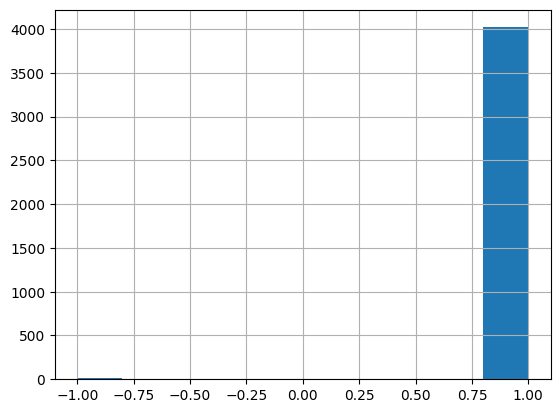

In [25]:
spearman_pairwise['coef'].hist(range=[-1, 1])

<Axes: >

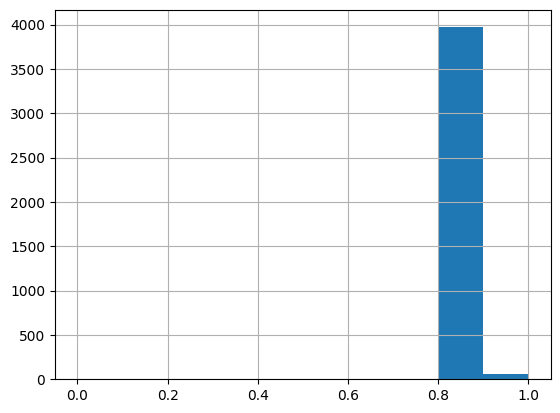

In [26]:
abs(spearman_pairwise['coef']).hist(range=[0, 1])

In [27]:
# filter for effect
df_no_effect = spearman_pairwise[abs(spearman_pairwise['coef'])<0.01]
df_very_small = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.01]
df_very_small = df_very_small[abs(df_very_small['coef'])<0.1]
df_effect = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.1]
print('\nNumber of analyte pairs whose effect size is at least weak: '.format(str(df_effect.shape[0])))


# evaluate effect size - cohen's d
df_small = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.1]
df_small = df_small[abs(df_small['coef'])<0.2]
df_medium = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.2]
df_medium  = df_medium[abs(df_medium['coef'])<0.3]
df_medium_large = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.3]
df_medium_large = df_medium_large[abs(df_medium_large['coef'])<0.5]
df_large = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.5]
df_large = df_large[abs(df_large['coef'])<0.7]
df_very_large = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.7]
df_very_large = df_very_large[abs(df_very_large['coef'])<0.9]
df_huge = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.9]

# print info on effect sizes
print('Number of Analyte Pairs with No Monotonic Relationship: {}'.format(str(df_no_effect.shape[0])))
print('Number of Analyte Pairs with Very Weak Monotonic Relationship: {}'.format(str(df_very_small.shape[0])))
print('Number of Analyte Pairs with Weak Monotonic Relationship: {}'.format(str(df_small.shape[0])))
print('Number of Analyte Pairs with Moderate Monotonic Relationship: {}'.format(str(df_medium.shape[0])))
print('Number of Analyte Pairs with Moderate Strong Monotonic Relationship: {}'.format(str(df_medium_large.shape[0])))
print('Number of Analyte Pairs with Strong Monotonic Relationship: {}'.format(str(df_large.shape[0])))
print('Number of Analyte Pairs with Very Strong Monotonic Relationship: {}'.format(str(df_very_large.shape[0])))
print('Number of Analyte Pairs with Near Perfect Monotonic Relationship: {}'.format(str(df_huge.shape[0])))


Number of analyte pairs whose effect size is at least weak: 
Number of Analyte Pairs with No Monotonic Relationship: 0
Number of Analyte Pairs with Very Weak Monotonic Relationship: 0
Number of Analyte Pairs with Weak Monotonic Relationship: 0
Number of Analyte Pairs with Moderate Monotonic Relationship: 0
Number of Analyte Pairs with Moderate Strong Monotonic Relationship: 0
Number of Analyte Pairs with Strong Monotonic Relationship: 0
Number of Analyte Pairs with Very Strong Monotonic Relationship: 3969
Number of Analyte Pairs with Near Perfect Monotonic Relationship: 63
